# Introduction

**Contexte Professionnel :** Ce notebook s'inscrit dans le cadre d'une mission pour *Air Paradis*, une compagnie aérienne cherchant à mieux gérer sa réputation en ligne. L'objectif principal du projet est de développer un prototype d'outil IA capable d'**anticiper les "bad buzz"** en détectant automatiquement les sentiments négatifs exprimés dans les tweets concernant la compagnie.

**Objectif de ce Notebook :** Ce document constitue le cœur de la phase de **modélisation et d'expérimentation**. Notre but est de construire, entraîner et évaluer différents modèles d'analyse de sentiments, allant d'une approche classique à des réseaux de neurones profonds, afin d'identifier la solution la plus performante pour prédire si un tweet exprime un sentiment négatif (0) ou non (1). Nous mettrons un accent particulier sur le développement d'un "modèle sur mesure avancé" (basé LSTM/BiLSTM) et évaluerons l'apport de différentes techniques d'**embedding** (Word2Vec/GloVe/FastText, BERT, USE) ainsi que l'impact de différentes stratégies de **prétraitement de texte** (lemmatisation, stemming).

**Méthodologie :**
1.  **Exploration des Données (EDA) :** Chargement et analyse initiale du dataset open-source de 1.6 million de tweets.
2.  **Prétraitement du Texte :** Nettoyage des tweets et application de techniques de normalisation (lemmatisation, stemming).
3.  **Échantillonnage Stratégique :** Réalisation de la majorité des expérimentations initiales sur un **échantillon représentatif (5%)** des données pour accélérer les itérations.
4.  **Modélisation et Expérimentation (sur échantillon) :**
    *   Établissement d'une **baseline** (TF-IDF + Régression Logistique).
    *   Test de modèles Deep Learning simples (Keras Embedding).
    *   Développement de modèles séquentiels (LSTM/BiLSTM) avec embeddings pré-entraînés (GloVe, **FastText**).
    *   Évaluation comparative de modèles basés sur le **Transfer Learning** (BERT Feature Extraction, Universal Sentence Encoder - USE).
    *   Suivi rigoureux de chaque expérience via **MLflow**.
5.  **Optimisation & Sélection :** Choix de la métrique principale (F1-Score), optimisation des hyperparamètres du meilleur modèle "sur mesure avancé" (LSTM+FastText) via des essais ciblés sur l'échantillon.
6.  **Entraînement Final sur Données Complètes :** Ré-entraînement du modèle optimisé sélectionné sur **l'intégralité du jeu de données d'entraînement** pour obtenir les performances finales les plus fiables.
7.  **Évaluation Finale :** Mesure des performances du modèle final sur le jeu de test complet.

**Résultat Attendu :** Ce notebook aboutit à un modèle final entraîné, évalué, et prêt à être packagé pour le déploiement via une API. Les composants essentiels (modèle sérialisé, tokenizer, configuration) sont également sauvegardés pour faciliter la transition vers les prochaines étapes MLOps.

# Phase 1 : Exploration & Préparation des Données 📊

In [2]:
# Cloner le dépôt GitHub dans l'environnement Colab
!git clone https://github.com/M-Carre/OC.git

Cloning into 'OC'...
remote: Enumerating objects: 20, done.
remote: Counting objects: 100% (20/20), done.
remote: Compressing objects: 100% (15/15), done.
remote: Total 20 (delta 8), reused 17 (delta 5), pack-reused 0 (from 0)
Receiving objects: 100% (20/20), 1.92 MiB | 5.88 MiB/s, done.
Resolving deltas: 100% (8/8), done.


On commence par les importations.

In [3]:
# Accédez au contenu du drive depuis le notebook
from google.colab import drive
drive.mount('/content/drive')

# Manipulation de données
import pandas as pd
import numpy as np

# Traitement de texte (sera utilisé plus tard pour le prétraitement)
import nltk
import re # Pour les expressions régulières (utile pour le nettoyage)

# Visualisation (utile pour l'Analyse Exploratoire des Données - EDA)
import matplotlib.pyplot as plt
import seaborn as sns

# Utilitaires Scikit-learn (pour la division des données, métriques, etc.)
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# --- Configuration MLflow Persistante ---
# Définir le chemin persistant sur Drive
# --- Importation MLflow et autres ---
try:
    import mlflow
    import mlflow.sklearn
except ImportError:
    import subprocess
    import sys
    print("MLflow non trouvé. Installation en cours...")
    subprocess.check_call([sys.executable, "-m", "pip", "install", "mlflow"])
    import mlflow
    import mlflow.sklearn
import os
mlflow_persistent_path = '/content/drive/MyDrive/Colab Notebooks/OC/P7/mlflow_runs_persistent'
os.makedirs(mlflow_persistent_path, exist_ok=True)

# Définir le Tracking URI AVANT TOUTE EXPÉRIMENTATION
mlflow.set_tracking_uri(f"file:{mlflow_persistent_path}")
print(f"MLflow Tracking URI configuré sur : {mlflow.get_tracking_uri()}")

# --- Définir le nom de l'expérience une seule fois aussi ---
mlflow.set_experiment("AirParadis_Sentiment_Analysis")
print(f"MLflow Expérience définie sur : AirParadis_Sentiment_Analysis")

# Configuration pour les visualisations (optionnel mais améliore le rendu)
sns.set_theme(style="whitegrid")

print("Bibliothèques de base importées.")
# Note : TensorFlow/Keras, PyTorch, Transformers seront importés/installés plus tard
# Note : NLTK pourrait nécessiter un téléchargement de données (ex: nltk.download('stopwords'))

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
MLflow non trouvé. Installation en cours...
MLflow Tracking URI configuré sur : file:/content/drive/MyDrive/Colab Notebooks/OC/P7/mlflow_runs_persistent
MLflow Expérience définie sur : AirParadis_Sentiment_Analysis
Bibliothèques de base importées.
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
MLflow Tracking URI configuré sur : file:/content/drive/MyDrive/Colab Notebooks/OC/P7/mlflow_runs_persistent
MLflow Expérience définie sur : AirParadis_Sentiment_Analysis
Bibliothèques de base importées.


## Analyse exploratoire

On charge ensuite les données.

In [ ]:
# Définition du chemin d'accès
file_path = '/content/drive/MyDrive/Colab Notebooks/OC/P7/training.1600000.processed.noemoticon.csv'

# Définir les noms de colonnes car le fichier n'a pas d'en-tête
column_names = ['target', 'id', 'date', 'flag', 'user', 'text']

# Charger le dataset
df = pd.read_csv(
    file_path,
    encoding='ISO-8859-1', # ou 'latin1'
    header=None,
    names=column_names
)

# Afficher les 5 premières lignes et la forme du DataFrame pour vérifier
print(f"Dataset chargé. Forme : {df.shape}")
print(display(df.head()))

Dataset chargé. Forme : (1600000, 6)


,target,id,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


None


Les données ont bien été importées.
On a la target 0 qui correspond à des commentaires négatifs situés dans la colonne text et le 4 qui correspond à des commentaires positifs.

Commençons par quelques vérifications fondamentales :

- Informations Générales et Types de Données

- Valeurs Manquantes

- Distribution de la Cible

Informations Générales sur le DataFrame:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600000 entries, 0 to 1599999
Data columns (total 6 columns):
 #   Column  Non-Null Count    Dtype 
---  ------  --------------    ----- 
 0   target  1600000 non-null  int64 
 1   id      1600000 non-null  int64 
 2   date    1600000 non-null  object
 3   flag    1600000 non-null  object
 4   user    1600000 non-null  object
 5   text    1600000 non-null  object
dtypes: int64(2), object(4)
memory usage: 73.2+ MB


Nombre de valeurs manquantes par colonne:
target    0
id        0
date      0
flag      0
user      0
text      0
dtype: int64


Distribution de la variable 'target':
target
0    800000
4    800000
Name: count, dtype: int64


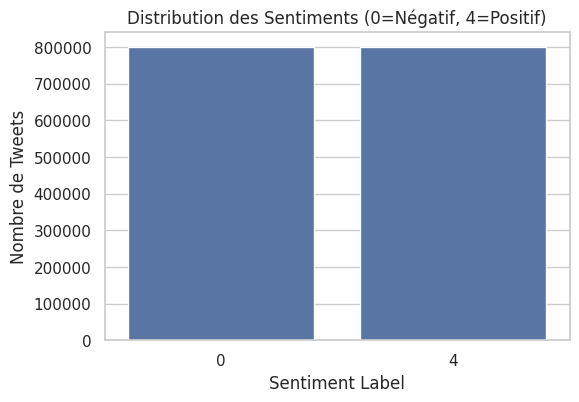

In [ ]:
# 1. Informations Générales et Types de Données
print("Informations Générales sur le DataFrame:")
df.info()

print("\n" + "="*50 + "\n") # Séparateur visuel

# 2. Vérification des Valeurs Manquantes
print("Nombre de valeurs manquantes par colonne:")
print(df.isnull().sum())

print("\n" + "="*50 + "\n") # Séparateur visuel

# 3. Distribution de la variable cible 'target'
print("Distribution de la variable 'target':")
print(df['target'].value_counts())

# Visualisation de la distribution de la cible
plt.figure(figsize=(6, 4))
sns.countplot(x='target', data=df)
plt.title('Distribution des Sentiments (0=Négatif, 4=Positif)')
plt.xlabel('Sentiment Label')
plt.ylabel('Nombre de Tweets')
plt.show()

**Résultats :**

- **Pas de valeurs manquantes**

- Types de données : Les **colonnes sont correctement lues**, bien que date soit un object (chaîne de caractères). Pour notre objectif d'analyse de sentiment basée sur le text, nous n'aurons probablement pas besoin de la convertir en type date/heure. Les colonnes id, flag et user ne seront probablement pas utiles pour la modélisation initiale basée sur le texte.

- **Cible parfaitement équilibrée** : 800 000 tweets négatifs (0) et 800 000 positifs (4). C'est idéal, car cela signifie que les métriques comme l'accuracy seront fiables et que le modèle n'aura pas de biais naturel vers une classe majoritaire.

**Prochaines étapes :**

- **Simplifier la colonne 'target'**: Convertir les valeurs 4 en 1 pour avoir une cible binaire standard (0: Négatif, 1: Positif).

- **Supprimer les colonnes inutiles**: Éliminer id, date, flag, user.

- **Analyser la longueur des tweets**: Examiner la distribution du nombre de caractères par tweet. Cela peut donner une idée de la taille des séquences que nos modèles (surtout les réseaux de neurones) devront gérer.

- **Afficher quelques exemples de tweets**: Regarder quelques textes bruts pour chaque classe (0 et 1) pour avoir une intuition qualitative.

Distribution de la nouvelle variable 'target' (0=Négatif, 1=Positif):
target
0    800000
1    800000
Name: count, dtype: int64


Colonnes après suppression:
Index(['target', 'text'], dtype='object')
Nouvelle forme du DataFrame: (1600000, 2)


Statistiques descriptives de la longueur des tweets:
count    1.600000e+06
mean     7.409011e+01
std      3.644114e+01
min      6.000000e+00
25%      4.400000e+01
50%      6.900000e+01
75%      1.040000e+02
max      3.740000e+02
Name: text_length, dtype: float64


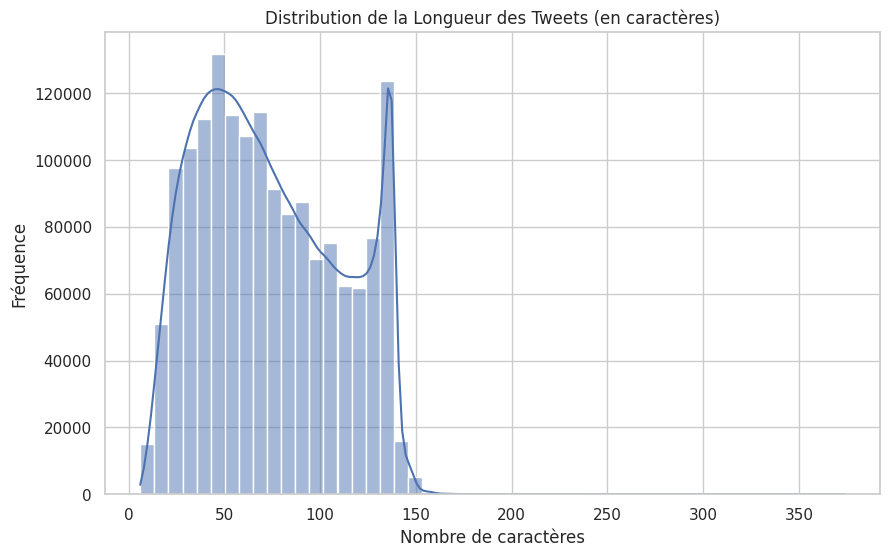



Exemples de Tweets Négatifs (target=0):
["@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer.  You shoulda got David Carr of Third Day to do it. ;D", "is upset that he can't update his Facebook by texting it... and might cry as a result  School today also. Blah!", '@Kenichan I dived many times for the ball. Managed to save 50%  The rest go out of bounds', 'my whole body feels itchy and like its on fire ', "@nationwideclass no, it's not behaving at all. i'm mad. why am i here? because I can't see you all over there. "]

Exemples de Tweets Positifs (target=1):
['I LOVE @Health4UandPets u guys r the best!! ', 'im meeting up with one of my besties tonight! Cant wait!!  - GIRL TALK!!', '@DaRealSunisaKim Thanks for the Twitter add, Sunisa! I got to meet you once at a HIN show here in the DC area and you were a sweetheart. ', 'Being sick can be really cheap when it hurts too much to eat real food  Plus, your friends make you soup', '@LovesBrooklyn2 he has that effect on everyone '

In [ ]:
# 1. Simplifier la colonne 'target' (Mapper 4 -> 1)
# Crée une copie pour éviter le SettingWithCopyWarning
df_processed = df.copy()
df_processed['target'] = df_processed['target'].replace(4, 1)

# Vérifier le changement
print("Distribution de la nouvelle variable 'target' (0=Négatif, 1=Positif):")
print(df_processed['target'].value_counts())

print("\n" + "="*50 + "\n")

# 2. Supprimer les colonnes inutiles
columns_to_drop = ['id', 'date', 'flag', 'user']
df_processed = df_processed.drop(columns=columns_to_drop)

print("Colonnes après suppression:")
print(df_processed.columns)
print(f"Nouvelle forme du DataFrame: {df_processed.shape}")

print("\n" + "="*50 + "\n")

# 3. Analyser la longueur des tweets
df_processed['text_length'] = df_processed['text'].apply(len)

print("Statistiques descriptives de la longueur des tweets:")
print(df_processed['text_length'].describe())

# Visualiser la distribution de la longueur des tweets
plt.figure(figsize=(10, 6))
sns.histplot(df_processed['text_length'], bins=50, kde=True)
plt.title('Distribution de la Longueur des Tweets (en caractères)')
plt.xlabel('Nombre de caractères')
plt.ylabel('Fréquence')
plt.show()

print("\n" + "="*50 + "\n")

# 4. Afficher quelques exemples de tweets
print("Exemples de Tweets Négatifs (target=0):")
print(df_processed[df_processed['target'] == 0]['text'].head().tolist())

print("\nExemples de Tweets Positifs (target=1):")
print(df_processed[df_processed['target'] == 1]['text'].head().tolist())

# Optionnel: Supprimer la colonne de longueur si non nécessaire plus tard
# df_processed = df_processed.drop(columns=['text_length'])

Les résultats confirment que nous avons un **DataFrame propre** avec nos deux colonnes essentielles (target et text) et que la **cible** est bien binaire (0/1) et **équilibrée**. Les statistiques sur la longueur des tweets sont aussi très utiles :

- La longueur moyenne est d'environ 74 caractères.

- La plupart des tweets (entre le 25e et 75e percentile) font entre 44 et 104 caractères.

- Le tweet le plus long fait 374 caractères,

Avant de passer au prétraitement formel, explorons un peu les mots eux-mêmes. Une technique visuelle très parlante est le **nuage de mots** (Word Cloud). Il permet de voir rapidement les mots les plus fréquents dans un corpus de texte. Faisons-en un pour les tweets **positifs** et un pour les **négatifs**.

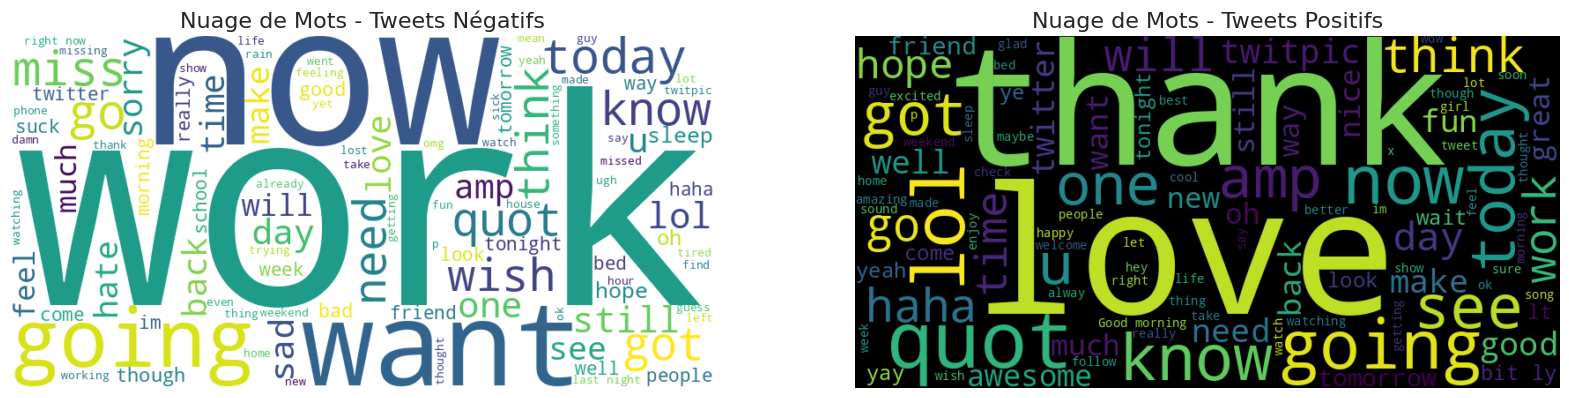

In [ ]:
# Installation de la bibliothèque wordcloud
!pip install wordcloud -q # -q pour une installation silencieuse

from wordcloud import WordCloud

# Séparer les textes positifs et négatifs
text_negatif = " ".join(tweet for tweet in df_processed[df_processed['target'] == 0]['text'])
text_positif = " ".join(tweet for tweet in df_processed[df_processed['target'] == 1]['text'])

# Générer le nuage de mots pour les tweets négatifs
wordcloud_neg = WordCloud(max_words=100, background_color="white", width=800, height=400).generate(text_negatif)

# Générer le nuage de mots pour les tweets positifs
wordcloud_pos = WordCloud(max_words=100, background_color="black", width=800, height=400).generate(text_positif)

# Afficher les nuages de mots
plt.figure(figsize=(20, 10))

plt.subplot(1, 2, 1) # Ligne 1, colonne 2, index 1
plt.imshow(wordcloud_neg, interpolation='bilinear')
plt.axis("off")
plt.title("Nuage de Mots - Tweets Négatifs", fontsize=16)

plt.subplot(1, 2, 2) # Ligne 1, colonne 2, index 2
plt.imshow(wordcloud_pos, interpolation='bilinear')
plt.axis("off")
plt.title("Nuage de Mots - Tweets Positifs", fontsize=16)

plt.show()

On remarque beaucoup de mots courants (**stopwords**) comme nous n'avons pas encore nettoyé le texte. C'est normal à ce stade, le but est d'avoir une première impression brute.

## Séparation des ensembles de données

Afin d’évaluer correctement les performances de nos modèles tout en évitant le surapprentissage, nous divisons notre jeu de données en trois sous-ensembles :

    Jeu d’entraînement (70%) – utilisé pour l’apprentissage du modèle.

    Jeu de validation (15%) – utilisé pour ajuster les hyperparamètres et évaluer les performances durant le développement.

    Jeu de test (15%) – utilisé pour mesurer la performance finale sur des données totalement inédites.

La division s’effectue en deux temps via train_test_split, tout en maintenant la proportion des classes (stratification) dans chaque ensemble. Cela garantit que le modèle est testé sur des échantillons représentatifs de la distribution initiale des données. Voici le code de séparation :

In [ ]:
from sklearn.model_selection import train_test_split
import pandas as pd # Assurer que pandas est importé

# Définir les features (X) et la cible (y)
# Assurez-vous que df_processed est défini et contient 'text', 'target'
X = df_processed['text']
y = df_processed['target']

# Taille du jeu de test (15% du total)
test_size = 0.15
# Taille du jeu de validation (15% du total, soit 50% du reste)
validation_size_relative_to_temp = 0.50 # 15% / (100% - 70%) = 15% / 30%

# Étape 1: Séparer Train (70%) et un jeu temporaire (30%)
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y,
    test_size=(test_size * 2), # 0.30 pour le jeu temporaire
    random_state=42,
    stratify=y
)

# Étape 2: Séparer le jeu temporaire (30%) en Validation (15%) et Test (15%)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp,
    test_size=validation_size_relative_to_temp,
    random_state=42,
    stratify=y_temp
)

# --- Affichage des tailles des jeux COMPLETS ---
print("--- Tailles des Ensembles Complets ---")
print(f"Taille du jeu d'entraînement complet (X_train): {X_train.shape[0]}")
print(f"Taille du jeu de validation complet (X_val):   {X_val.shape[0]}")
print(f"Taille du jeu de test complet (X_test):      {X_test.shape[0]}")

# --- Recombiner en DataFrames COMPLETS ---
# Ces DataFrames serviront de base avant le prétraitement ou l'échantillonnage
train_df_full = pd.DataFrame({'text': X_train, 'target': y_train})
val_df_full = pd.DataFrame({'text': X_val, 'target': y_val})
test_df_full = pd.DataFrame({'text': X_test, 'target': y_test})
print("\nDataFrames complets (train_df_full, val_df_full, test_df_full) créés.")


# ==================================================
# === NOUVEAU : Étape d'Échantillonnage (Sampling) ===
# ==================================================
# Définir la fraction ou le nombre d'échantillons souhaité
# --- Option 1: Fraction ---
SAMPLE_FRACTION = 0.05 # Ex: 5% des données
USE_FRACTION = True # Mettre à True pour utiliser la fraction

# --- Option 2: Nombre fixe (commenter si utilisation de fraction) ---
# N_TRAIN_SAMPLE = 50000
# N_VAL_SAMPLE = 10000
# N_TEST_SAMPLE = 10000
# USE_FRACTION = False # Mettre à False pour utiliser les nombres fixes

print(f"\n--- Application de l'Échantillonnage ---")

if USE_FRACTION:
    print(f"Échantillonnage par fraction : {SAMPLE_FRACTION*100}%")
    # Utiliser frac sur les DataFrames complets
    train_df = train_df_full.sample(frac=SAMPLE_FRACTION, random_state=42)
    val_df = val_df_full.sample(frac=SAMPLE_FRACTION, random_state=42)
    test_df = test_df_full.sample(frac=SAMPLE_FRACTION, random_state=42)
else:
    # Assurer de ne pas demander plus que disponible
    n_train = min(N_TRAIN_SAMPLE, len(train_df_full))
    n_val = min(N_VAL_SAMPLE, len(val_df_full))
    n_test = min(N_TEST_SAMPLE, len(test_df_full))
    print(f"Échantillonnage par nombre fixe : Train={n_train}, Val={n_val}, Test={n_test}")
    # Utiliser n sur les DataFrames complets
    train_df = train_df_full.sample(n=n_train, random_state=42)
    val_df = val_df_full.sample(n=n_val, random_state=42)
    test_df = test_df_full.sample(n=n_test, random_state=42)

# --- Afficher les tailles des jeux ÉCHANTILLONNÉS ---
print("\n--- Tailles des Ensembles Échantillonnés ---")
print(f"Taille du jeu d'entraînement échantillonné (train_df): {len(train_df)}")
print(f"Taille du jeu de validation échantillonné (val_df):   {len(val_df)}")
print(f"Taille du jeu de test échantillonné (test_df):      {len(test_df)}")

# --- Vérifier la distribution des classes dans les échantillons ---
print("\nDistribution de la cible dans l'entraînement échantillonné:")
print(train_df['target'].value_counts(normalize=True))
print("\nDistribution de la cible dans la validation échantillonnée:")
print(val_df['target'].value_counts(normalize=True))
print("\nDistribution de la cible dans le test échantillonné:")
print(test_df['target'].value_counts(normalize=True))

print("\nDataFrames échantillonnés (train_df, val_df, test_df) prêts pour la suite.")
print("!!! Toutes les étapes suivantes doivent utiliser ces DataFrames échantillonnés !!!")

# Note: Les DataFrames train_df_full, val_df_full, test_df_full existent toujours
# si jamais vous voulez faire une évaluation finale sur l'ensemble complet plus tard
# (mais l'entraînement doit se faire sur les échantillons pour tenir dans les ressources).

--- Tailles des Ensembles Complets ---
Taille du jeu d'entraînement complet (X_train): 1120000
Taille du jeu de validation complet (X_val):   240000
Taille du jeu de test complet (X_test):      240000

DataFrames complets (train_df_full, val_df_full, test_df_full) créés.

--- Application de l'Échantillonnage ---
Échantillonnage par fraction : 5.0%

--- Tailles des Ensembles Échantillonnés ---
Taille du jeu d'entraînement échantillonné (train_df): 56000
Taille du jeu de validation échantillonné (val_df):   12000
Taille du jeu de test échantillonné (test_df):      12000

Distribution de la cible dans l'entraînement échantillonné:
target
0    0.501161
1    0.498839
Name: proportion, dtype: float64

Distribution de la cible dans la validation échantillonnée:
target
1    0.501583
0    0.498417
Name: proportion, dtype: float64

Distribution de la cible dans le test échantillonné:
target
1    0.5
0    0.5
Name: proportion, dtype: float64

DataFrames échantillonnés (train_df, val_df, test_df) 

# Phase 2 : Prétraitement du Texte (Multi-Stratégies) ⚙️

Maintenant, passons à la prochaine étape : appliquer le **nettoyage minimal** commun à la colonne text de chacun de ces **trois DataFrames**. Cela créera une base propre (text_cleaned) avant les prétraitements plus spécifiques (lemma, stem, etc.).

In [ ]:
import re

# Fonction pour le nettoyage minimal (URLs, mentions, et peut-être HTML entities)
def clean_minimal(text):
    # Supprimer les URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    # Supprimer les mentions (@utilisateur)
    text = re.sub(r'\@\w+', '', text)
    # Supprimer les caractères HTML (optionnel, ex: &)
    text = re.sub(r'&[a-z]+;', '', text)
    # Remplacer les espaces multiples par un seul et supprimer les espaces de début/fin
    text = re.sub(r'\s+', ' ', text).strip()
    return text

print("Fonction clean_minimal définie.")

Fonction clean_minimal définie.


In [ ]:
# Appliquer clean_minimal sur le jeu d'entraînement
print("Nettoyage minimal du jeu d'entraînement...")
train_df['text_cleaned'] = train_df['text'].apply(clean_minimal)

# Appliquer clean_minimal sur le jeu de validation
print("Nettoyage minimal du jeu de validation...")
val_df['text_cleaned'] = val_df['text'].apply(clean_minimal)

# Appliquer clean_minimal sur le jeu de test
print("Nettoyage minimal du jeu de test...")
test_df['text_cleaned'] = test_df['text'].apply(clean_minimal)

print("\nNettoyage minimal terminé. Colonne 'text_cleaned' ajoutée.")

# Afficher quelques exemples pour vérifier
print("\nExemple après nettoyage minimal (entraînement) :")
print(train_df[['text', 'text_cleaned']].head())

Nettoyage minimal du jeu d'entraînement...
Nettoyage minimal du jeu de validation...
Nettoyage minimal du jeu de test...

Nettoyage minimal terminé. Colonne 'text_cleaned' ajoutée.

Exemple après nettoyage minimal (entraînement) :
                                                      text  \
222921   My must I be so unlucky in love, I mean also I...   
841791   I'm currently trying to understand this site. ...   
49912    this is boring coz no one's really tweeting wh...   
1365171  happppppyyyy hourrrrrr with @laaaceface &amp; ...   
1365343  @tiadantzler U mean in a few weeks? YAY!! Can'...   

                                              text_cleaned  
222921   My must I be so unlucky in love, I mean also I...  
841791   I'm currently trying to understand this site. ...  
49912    this is boring coz no one's really tweeting wh...  
1365171  happppppyyyy hourrrrrr with non tweets Luzana,...  
1365343  U mean in a few weeks? YAY!! Can't wait to see...  


On a bien une colonne text_cleaned qui a été ajoutée, qui nous a permis d'enlever les URL et les mentions entre autres. On va maintenant pouvoir définir la fonction de lemmatisation.

In [ ]:
import spacy
import string # Pour la ponctuation

# Chargement du modèle spaCy (léger et rapide)
# Désactiver les composants non nécessaires (parser, ner) pour accélérer
try:
    nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])
    print("Modèle spaCy 'en_core_web_sm' chargé (composants désactivés: parser, ner).")
except OSError:
    print("Téléchargement du modèle spaCy 'en_core_web_sm'...")
    # Utilisation de -q pour quiet/silencieux
    !python -m spacy download en_core_web_sm -q
    nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])
    print("Modèle spaCy 'en_core_web_sm' chargé après téléchargement.")

# Vérifier les composants chargés
print(f"Pipeline spaCy actif : {nlp.pipe_names}")

Modèle spaCy 'en_core_web_sm' chargé (composants désactivés: parser, ner).
Pipeline spaCy actif : ['tok2vec', 'tagger', 'attribute_ruler', 'lemmatizer']


In [ ]:
def lemmatize_doc(doc):
    """
    Prend un objet Doc spaCy et retourne une chaîne de lemmes.
    - Convertit en minuscules (via .lemma_ qui est souvent déjà en minuscules)
    - Supprime les stopwords spaCy
    - Supprime la ponctuation spaCy
    - Supprime les tokens qui sont juste des espaces
    """
    lemmas = []
    for token in doc:
        # Filtrer stopwords, ponctuation, et tokens vides/espaces
        if not token.is_stop and not token.is_punct and token.text.strip():
            lemmas.append(token.lemma_.lower()) # Assurer les minuscules
    return " ".join(lemmas)

print("Fonction lemmatize_doc définie.")

Fonction lemmatize_doc définie.


In [ ]:
import time # Pour mesurer le temps

print(f"Traitement de {len(train_df)} textes du jeu d'entraînement avec nlp.pipe...")
start_time = time.time()

# Utiliser nlp.pipe sur la colonne text_cleaned
# as_tuples=True peut être légèrement plus rapide si on n'a pas besoin de l'objet Doc complet plus tard
# batch_size peut être ajusté en fonction de la RAM disponible (par défaut, spaCy choisit une taille raisonnable)
processed_docs = nlp.pipe(train_df['text_cleaned'], batch_size=10000)

# Appliquer notre fonction lemmatize_doc à chaque doc généré par nlp.pipe
# Utiliser une list comprehension pour l'efficacité
train_lemmas = [lemmatize_doc(doc) for doc in processed_docs]

end_time = time.time()
print(f"Lemmatisation du jeu d'entraînement terminée en {end_time - start_time:.2f} secondes.")

# Ajouter les résultats comme nouvelle colonne dans train_df
train_df['text_lemma'] = train_lemmas

print("Colonne 'text_lemma' ajoutée à train_df.")

# Afficher quelques exemples pour vérifier
print("\nExemple après lemmatisation (entraînement) :")
print(train_df[['text_cleaned', 'text_lemma']].head())

Traitement de 56000 textes du jeu d'entraînement avec nlp.pipe...
Lemmatisation du jeu d'entraînement terminée en 88.14 secondes.
Colonne 'text_lemma' ajoutée à train_df.

Exemple après lemmatisation (entraînement) :
                                              text_cleaned  \
222921   My must I be so unlucky in love, I mean also I...   
841791   I'm currently trying to understand this site. ...   
49912    this is boring coz no one's really tweeting wh...   
1365171  happppppyyyy hourrrrrr with non tweets Luzana,...   
1365343  U mean in a few weeks? YAY!! Can't wait to see...   

                                                text_lemma  
222921   unlucky love mean find crush forever get ex lo...  
841791   currently try understand site use spam faceboo...  
49912      bore coz tweet tweet coz m stuck australia fair  
1365171  happppppyyyy hourrrrrr non tweets luzana maris...  
1365343  u mean week yay wait bat time bat channel lol ...  


La lemmatisation a bien été appliquée sur notre df_train, avec une nouvelle colonne créée. On peut maintenant passer à la fonction de stemming.

In [ ]:
import nltk
# Télécharger les ressources nltk nécessaires si ce n'est pas déjà fait
# (stopwords sont utiles même si spaCy les gère, au cas où)
try:
    nltk.data.find('corpora/stopwords')
except LookupError:
    nltk.download('stopwords', quiet=True)


from nltk.stem.snowball import SnowballStemmer

# Initialiser le stemmer pour l'anglais
stemmer = SnowballStemmer(language='english')

print("Stemmer NLTK (Snowball) initialisé.")

Stemmer NLTK (Snowball) initialisé.


In [ ]:
def stem_doc(doc):
    """
    Prend un objet Doc spaCy et retourne une chaîne de stems (racines).
    - Convertit en minuscules AVANT le stemming.
    - Supprime les stopwords spaCy.
    - Supprime la ponctuation spaCy.
    - Supprime les tokens qui sont juste des espaces.
    - Applique le stemmer NLTK (Snowball).
    """
    stems = []
    for token in doc:
        # Filtrer stopwords, ponctuation, et tokens vides/espaces
        if not token.is_stop and not token.is_punct and token.text.strip():
            # Appliquer le stemmer sur le texte du token en minuscules
            stems.append(stemmer.stem(token.text.lower()))
    return " ".join(stems)

print("Fonction stem_doc définie.")

Fonction stem_doc définie.


In [ ]:
import time # Pour mesurer le temps

print(f"\nTraitement de {len(train_df)} textes du jeu d'entraînement pour le stemming avec nlp.pipe...")
start_time_stem = time.time()

# Utiliser nlp.pipe sur la colonne text_cleaned
processed_docs_stem = nlp.pipe(train_df['text_cleaned'], batch_size=10000)

# Appliquer notre fonction stem_doc à chaque doc généré par nlp.pipe
train_stems = [stem_doc(doc) for doc in processed_docs_stem]

end_time_stem = time.time()
print(f"Stemming du jeu d'entraînement terminé en {end_time_stem - start_time_stem:.2f} secondes.")

# Ajouter les résultats comme nouvelle colonne dans train_df
train_df['text_stem'] = train_stems

print("Colonne 'text_stem' ajoutée à train_df.")

# Afficher quelques exemples pour vérifier la différence avec lemma
print("\nExemple après stemming (entraînement) :")
print(train_df[['text_cleaned', 'text_lemma', 'text_stem']].head())


Traitement de 56000 textes du jeu d'entraînement pour le stemming avec nlp.pipe...
Stemming du jeu d'entraînement terminé en 94.97 secondes.
Colonne 'text_stem' ajoutée à train_df.

Exemple après stemming (entraînement) :
                                              text_cleaned  \
222921   My must I be so unlucky in love, I mean also I...   
841791   I'm currently trying to understand this site. ...   
49912    this is boring coz no one's really tweeting wh...   
1365171  happppppyyyy hourrrrrr with non tweets Luzana,...   
1365343  U mean in a few weeks? YAY!! Can't wait to see...   

                                                text_lemma  \
222921   unlucky love mean find crush forever get ex lo...   
841791   currently try understand site use spam faceboo...   
49912      bore coz tweet tweet coz m stuck australia fair   
1365171  happppppyyyy hourrrrrr non tweets luzana maris...   
1365343  u mean week yay wait bat time bat channel lol ...   

                               

In [ ]:
train_df

,text,target,text_cleaned,text_lemma,text_stem
222921,"My must I be so unlucky in love, I mean also I...",0,"My must I be so unlucky in love, I mean also I...",unlucky love mean find crush forever get ex lo...,unlucki love mean find crush forev got ex love...
841791,I'm currently trying to understand this site. ...,1,I'm currently trying to understand this site. ...,currently try understand site use spam faceboo...,current tri understand site use spam facebook xd
49912,this is boring coz no one's really tweeting wh...,0,this is boring coz no one's really tweeting wh...,bore coz tweet tweet coz m stuck australia fair,bore coz tweet tweet coz m stuck australia fair
1365171,happppppyyyy hourrrrrr with @laaaceface &amp; ...,1,"happppppyyyy hourrrrrr with non tweets Luzana,...",happppppyyyy hourrrrrr non tweets luzana maris...,happppppyyyy hourrrrrr non tweet luzana marisa...
1365343,@tiadantzler U mean in a few weeks? YAY!! Can'...,1,U mean in a few weeks? YAY!! Can't wait to see...,u mean week yay wait bat time bat channel lol ...,u mean week yay wait bat time bat channel lol ...
...,...,...,...,...,...
50309,I am $75 richer! But my legs hurts,0,I am $75 richer! But my legs hurts,$ 75 rich leg hurt,$ 75 richer leg hurt
1562657,@BekahLouTaylor It's good to see you relaxing ...,1,It's good to see you relaxing now.,good relax,good relax
507013,"busy, busy week still lovin the pens victory!...",0,"busy, busy week still lovin the pens victory! ...",busy busy week lovin pen victory woo hoo,busi busi week lovin pen victori woo hoo
141539,@FuchsiaStiletto no not really,0,no not really,,


Le stemming a bien été appliqué sur l'ensemble d'entraînement. Maintenant, on va pouvoir appliquer les 2 fonctions de lemmatisation et de stemming sur les ensembles de validation et de test.

In [ ]:
import time

# Lemmatisation pour le jeu de validation
print(f"\nTraitement de {len(val_df)} textes du jeu de validation pour la lemmatisation...")
start_time_val_lemma = time.time()

processed_docs_val = nlp.pipe(val_df['text_cleaned'], batch_size=5000) # Utiliser la même taille de batch
val_lemmas = [lemmatize_doc(doc) for doc in processed_docs_val]

end_time_val_lemma = time.time()
print(f"Lemmatisation du jeu de validation terminée en {end_time_val_lemma - start_time_val_lemma:.2f} secondes.")
val_df['text_lemma'] = val_lemmas
print("Colonne 'text_lemma' ajoutée à val_df.")

# Lemmatisation pour le jeu de test
print(f"\nTraitement de {len(test_df)} textes du jeu de test pour la lemmatisation...")
start_time_test_lemma = time.time()

processed_docs_test = nlp.pipe(test_df['text_cleaned'], batch_size=5000) # Utiliser la même taille de batch
test_lemmas = [lemmatize_doc(doc) for doc in processed_docs_test]

end_time_test_lemma = time.time()
print(f"Lemmatisation du jeu de test terminée en {end_time_test_lemma - start_time_test_lemma:.2f} secondes.")
test_df['text_lemma'] = test_lemmas
print("Colonne 'text_lemma' ajoutée à test_df.")

# Vérification rapide (optionnelle)
print("\nExemple val_df après lemmatisation:")
print(val_df[['text_cleaned', 'text_lemma']].head())
print("\nExemple test_df après lemmatisation:")
print(test_df[['text_cleaned', 'text_lemma']].head())


Traitement de 12000 textes du jeu de validation pour la lemmatisation...
Lemmatisation du jeu de validation terminée en 16.56 secondes.
Colonne 'text_lemma' ajoutée à val_df.

Traitement de 12000 textes du jeu de test pour la lemmatisation...
Lemmatisation du jeu de test terminée en 17.54 secondes.
Colonne 'text_lemma' ajoutée à test_df.

Exemple val_df après lemmatisation:
                                              text_cleaned  \
611162                            that daddy jeff stuff...   
1503526                                   no problem camii   
755539   Fyi I hate this curve! I miss my 8900 watching...   
445656   Yes. Looks like I'll be here for awhile yet We...   
1425048  well next time try it......you will get hooked...   

                                                text_lemma  
611162                                    daddy jeff stuff  
1503526                                      problem camii  
755539   fyi hate curve miss 8900 watch sin senos hay p...  
44565

In [ ]:
import time

# Stemming pour le jeu de validation
print(f"\nTraitement de {len(val_df)} textes du jeu de validation pour le stemming...")
start_time_val_stem = time.time()

processed_docs_val_stem = nlp.pipe(val_df['text_cleaned'], batch_size=5000)
val_stems = [stem_doc(doc) for doc in processed_docs_val_stem]

end_time_val_stem = time.time()
print(f"Stemming du jeu de validation terminée en {end_time_val_stem - start_time_val_stem:.2f} secondes.")
val_df['text_stem'] = val_stems
print("Colonne 'text_stem' ajoutée à val_df.")

# Stemming pour le jeu de test
print(f"\nTraitement de {len(test_df)} textes du jeu de test pour le stemming...")
start_time_test_stem = time.time()

processed_docs_test_stem = nlp.pipe(test_df['text_cleaned'], batch_size=5000)
test_stems = [stem_doc(doc) for doc in processed_docs_test_stem]

end_time_test_stem = time.time()
print(f"Stemming du jeu de test terminée en {end_time_test_stem - start_time_test_stem:.2f} secondes.")
test_df['text_stem'] = test_stems
print("Colonne 'text_stem' ajoutée à test_df.")

# Vérification rapide (optionnelle)
print("\nExemple val_df après stemming:")
print(val_df[['text_lemma', 'text_stem']].head())
print("\nExemple test_df après stemming:")
print(test_df[['text_lemma', 'text_stem']].head())


Traitement de 12000 textes du jeu de validation pour le stemming...
Stemming du jeu de validation terminée en 18.42 secondes.
Colonne 'text_stem' ajoutée à val_df.

Traitement de 12000 textes du jeu de test pour le stemming...
Stemming du jeu de test terminée en 16.74 secondes.
Colonne 'text_stem' ajoutée à test_df.

Exemple val_df après stemming:
                                                text_lemma  \
611162                                    daddy jeff stuff   
1503526                                      problem camii   
755539   fyi hate curve miss 8900 watch sin senos hay p...   
445656                 yes look like awhile time free time   
1425048  time try hook b c real cane sugar apparently g...   

                                                 text_stem  
611162                                    daddi jeff stuff  
1503526                                      problem camii  
755539   fyi hate curv miss 8900 watch sin seno hay par...  
445656                  yes look

In [ ]:
import os # Pour manipuler les chemins de fichiers

# Définir le dossier de sauvegarde sur Google Drive
save_dir = '/content/drive/MyDrive/Colab Notebooks/OC/P7/'

# Créer le dossier s'il n'existe pas
os.makedirs(save_dir, exist_ok=True)

# Définir les chemins complets pour chaque fichier
train_pickle_path = os.path.join(save_dir, 'train_processed.pkl')
val_pickle_path = os.path.join(save_dir, 'val_processed.pkl')
test_pickle_path = os.path.join(save_dir, 'test_processed.pkl')

# Sauvegarder train_df
print(f"Sauvegarde de train_df en Pickle à : {train_pickle_path}")
train_df.to_pickle(train_pickle_path)
print("Sauvegarde de train_df terminée.")

# Sauvegarder val_df
print(f"\nSauvegarde de val_df en Pickle à : {val_pickle_path}")
val_df.to_pickle(val_pickle_path)
print("Sauvegarde de val_df terminée.")

# Sauvegarder test_df
print(f"\nSauvegarde de test_df en Pickle à : {test_pickle_path}")
test_df.to_pickle(test_pickle_path)
print("Sauvegarde de test_df terminée.")

Sauvegarde de train_df en Pickle à : /content/drive/MyDrive/Colab Notebooks/OC/P7/train_processed.pkl
Sauvegarde de train_df terminée.

Sauvegarde de val_df en Pickle à : /content/drive/MyDrive/Colab Notebooks/OC/P7/val_processed.pkl
Sauvegarde de val_df terminée.

Sauvegarde de test_df en Pickle à : /content/drive/MyDrive/Colab Notebooks/OC/P7/test_processed.pkl
Sauvegarde de test_df terminée.


# Phase 3 : Modélisation & Expérimentation (avec MLflow) 🧪

## Imports

In [ ]:
import pandas as pd
import os

# Définir le dossier de chargement (doit correspondre au dossier de sauvegarde)
load_dir = '/content/drive/MyDrive/Colab Notebooks/OC/P7/'

# Définir les chemins complets pour chaque fichier
train_pickle_path = os.path.join(load_dir, 'train_processed.pkl')
val_pickle_path = os.path.join(load_dir, 'val_processed.pkl')
test_pickle_path = os.path.join(load_dir, 'test_processed.pkl')

# Charger train_df
print(f"Chargement de train_df depuis Pickle : {train_pickle_path}")
train_df = pd.read_pickle(train_pickle_path)
print("Chargement de train_df terminé.")
print("Info train_df:")
train_df.info()

# Charger val_df
print(f"\nChargement de val_df depuis Pickle : {val_pickle_path}")
val_df = pd.read_pickle(val_pickle_path)
print("Chargement de val_df terminé.")
print("Info val_df:")
val_df.info()

# Charger test_df
print(f"\nChargement de test_df depuis Pickle : {test_pickle_path}")
test_df = pd.read_pickle(test_pickle_path)
print("Chargement de test_df terminé.")
print("Info test_df:")
test_df.info()

print("\nLes trois DataFrames prétraités ont été rechargés.")

Chargement de train_df depuis Pickle : /content/drive/MyDrive/Colab Notebooks/OC/P7/train_processed.pkl
Chargement de train_df terminé.
Info train_df:
<class 'pandas.core.frame.DataFrame'>
Index: 56000 entries, 222921 to 922105
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   text          56000 non-null  object
 1   target        56000 non-null  int64 
 2   text_cleaned  56000 non-null  object
 3   text_lemma    56000 non-null  object
 4   text_stem     56000 non-null  object
dtypes: int64(1), object(4)
memory usage: 2.6+ MB

Chargement de val_df depuis Pickle : /content/drive/MyDrive/Colab Notebooks/OC/P7/val_processed.pkl
Chargement de val_df terminé.
Info val_df:
<class 'pandas.core.frame.DataFrame'>
Index: 12000 entries, 611162 to 1043703
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   text          12000 non-null  object
 1   target     

## Expérimentation 1 : Modèle de Référence (Bag-of-Words)

Le premier modèle utilisera une approche classique **Bag-of-Words**, spécifiquement **TF-IDF**, et un classifieur simple comme la **Régression Logistique.** Nous utiliserons la colonne text_lemma comme input textuel. C'est un excellent point de départ pour établir une **performance de base** à battre avec les modèles plus complexes.

Assurons-nous d'avoir les importations pour la vectorisation, le modèle, les métriques, et MLflow.

Démarrage du run MLflow : Baseline_TFIDF_LogisticRegression
Entraînement du pipeline...
Entraînement terminé en 2.83 secondes.
Évaluation sur le jeu d'entraînement...
Train - Accuracy: 0.7833, F1: 0.7869, Precision: 0.7723, Recall: 0.8021
Évaluation sur le jeu de validation...
Validation - Accuracy: 0.7468, F1: 0.7534, Precision: 0.7366, Recall: 0.7709
Évaluation sur le jeu de test...
Test - Accuracy: 0.7531, F1: 0.7584, Precision: 0.7425, Recall: 0.7750
Génération de la matrice de confusion pour le jeu de test...


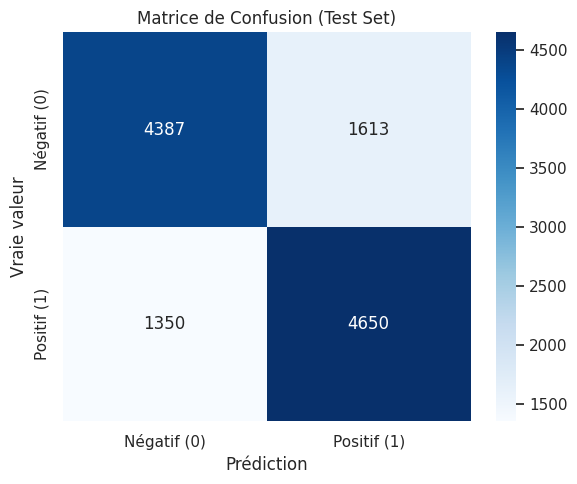

Matrice de confusion sauvegardée dans MLflow.
Sauvegarde du pipeline avec MLflow...


2025/04/29 11:47:49 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Pipeline sauvegardé.

Run MLflow (v2) terminé.


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import (accuracy_score, f1_score, precision_score,
                             recall_score, confusion_matrix) # Ajout confusion_matrix

# --- Importation sécurisée de MLflow ---
try:
    import mlflow
    import mlflow.sklearn
except ImportError:
    import subprocess
    import sys
    print("MLflow non trouvé. Installation en cours...")
    subprocess.check_call([sys.executable, "-m", "pip", "install", "mlflow"])
    import mlflow
    import mlflow.sklearn

import time
import matplotlib.pyplot as plt # Ajout pour visualisation
import seaborn as sns          # Ajout pour visualisation

# --- Configuration MLflow ---
mlflow.set_experiment("AirParadis_Sentiment_Analysis")
run_name = "Baseline_TFIDF_LogisticRegression"

# --- Démarrage du Run MLflow ---
with mlflow.start_run(run_name=run_name):
    print(f"Démarrage du run MLflow : {run_name}")
    start_time = time.time()

    # --- Paramètres (identiques à avant) ---
    vectorizer_params = {'max_features': 5000, 'ngram_range': (1, 2)}
    model_params = {'C': 1.0, 'solver': 'liblinear'}
    text_column_used = 'text_lemma'

    mlflow.log_param("text_preprocessing", text_column_used)
    mlflow.log_params(vectorizer_params)
    mlflow.log_params(model_params)
    mlflow.log_param("model_type", "LogisticRegression")
    mlflow.log_param("vectorizer_type", "TfidfVectorizer")

    # --- Pipeline (identique) ---
    pipeline = Pipeline([
        ('tfidf', TfidfVectorizer(**vectorizer_params)),
        ('clf', LogisticRegression(**model_params, random_state=42))
    ])

    # --- Entraînement ---
    print("Entraînement du pipeline...")
    pipeline.fit(train_df[text_column_used], train_df['target'])
    training_time = time.time() - start_time
    print(f"Entraînement terminé en {training_time:.2f} secondes.")
    mlflow.log_metric("training_time_seconds", training_time)

    # --- Évaluation sur le JEU D'ENTRAÎNEMENT ---
    print("Évaluation sur le jeu d'entraînement...")
    y_train_pred = pipeline.predict(train_df[text_column_used])
    train_accuracy = accuracy_score(train_df['target'], y_train_pred)
    train_f1 = f1_score(train_df['target'], y_train_pred)
    train_precision = precision_score(train_df['target'], y_train_pred)
    train_recall = recall_score(train_df['target'], y_train_pred)
    print(f"Train - Accuracy: {train_accuracy:.4f}, F1: {train_f1:.4f}, Precision: {train_precision:.4f}, Recall: {train_recall:.4f}")
    mlflow.log_metric("train_accuracy", train_accuracy)
    mlflow.log_metric("train_f1", train_f1)
    mlflow.log_metric("train_precision", train_precision)
    mlflow.log_metric("train_recall", train_recall)

    # --- Évaluation sur Validation Set ---
    print("Évaluation sur le jeu de validation...")
    y_val_pred = pipeline.predict(val_df[text_column_used])
    val_accuracy = accuracy_score(val_df['target'], y_val_pred)
    val_f1 = f1_score(val_df['target'], y_val_pred)
    val_precision = precision_score(val_df['target'], y_val_pred)
    val_recall = recall_score(val_df['target'], y_val_pred)
    print(f"Validation - Accuracy: {val_accuracy:.4f}, F1: {val_f1:.4f}, Precision: {val_precision:.4f}, Recall: {val_recall:.4f}")
    mlflow.log_metric("validation_accuracy", val_accuracy)
    mlflow.log_metric("validation_f1", val_f1)
    mlflow.log_metric("validation_precision", val_precision)
    mlflow.log_metric("validation_recall", val_recall)

    # --- Évaluation sur Test Set ---
    print("Évaluation sur le jeu de test...")
    y_test_pred = pipeline.predict(test_df[text_column_used])
    test_accuracy = accuracy_score(test_df['target'], y_test_pred)
    test_f1 = f1_score(test_df['target'], y_test_pred)
    test_precision = precision_score(test_df['target'], y_test_pred)
    test_recall = recall_score(test_df['target'], y_test_pred)
    print(f"Test - Accuracy: {test_accuracy:.4f}, F1: {test_f1:.4f}, Precision: {test_precision:.4f}, Recall: {test_recall:.4f}")
    mlflow.log_metric("test_accuracy", test_accuracy)
    mlflow.log_metric("test_f1", test_f1)
    mlflow.log_metric("test_precision", test_precision)
    mlflow.log_metric("test_recall", test_recall)

    # --- Visualisation: Matrice de Confusion (sur Test Set) ---
    print("Génération de la matrice de confusion pour le jeu de test...")
    cm = confusion_matrix(test_df['target'], y_test_pred)
    fig_cm, ax_cm = plt.subplots(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax_cm,
                xticklabels=['Négatif (0)', 'Positif (1)'],
                yticklabels=['Négatif (0)', 'Positif (1)'])
    ax_cm.set_xlabel('Prédiction')
    ax_cm.set_ylabel('Vraie valeur')
    ax_cm.set_title('Matrice de Confusion (Test Set)')
    plt.tight_layout()
    plt.show()

    # Logguer la figure dans MLflow comme artefact
    mlflow.log_figure(fig_cm, "confusion_matrix_test_set.png")
    print("Matrice de confusion sauvegardée dans MLflow.")
    plt.close(fig_cm) # Fermer la figure pour éviter l'affichage automatique multiple


    # --- Sauvegarde du Modèle (Pipeline) avec MLflow ---
    print("Sauvegarde du pipeline avec MLflow...")
    mlflow.sklearn.log_model(
        sk_model=pipeline,
        artifact_path="tfidf-logistic-regression-model",
        # signature=signature # On pourrait ajouter une signature ici
        # input_example=train_df[text_column_used].iloc[:5] # Et/ou un exemple d'input
    )
    print("Pipeline sauvegardé.")

print("\nRun MLflow (v2) terminé.")

L'approche classique TF-IDF + Régression Logistique établit une **baseline solide** avec un F1-score de **0.758** sur le jeu de test. Ce modèle, très rapide à entraîner (~2s), montre une bonne généralisation (performances similaires sur train/val/test) et servira de référence pour les approches plus complexes.

## Expérimentation 2 : Modèle DL Simple (Embedding Keras)

Nous passons à l'**Expérimentation 2** :** Modèle DL Simple** (Embedding Keras), ,ous allons donc :

    Choisir la colonne text_lemma.

    Créer et ajuster (fit) un Tokenizer Keras uniquement sur les données d'entraînement (train_df['text_lemma']).

    Convertir les textes de train_df, val_df et test_df en séquences d'entiers en utilisant ce tokenizer.

    Déterminer une longueur de séquence maximale (maxlen) basée sur la distribution des longueurs dans le jeu d'entraînement.

    Appliquer le padding (pad_sequences) à toutes les séquences (train, val, test) pour les amener à cette maxlen.

Initialisation et ajustement du Tokenizer sur 'text_lemma' du jeu d'entraînement...
Conversion des textes en séquences d'entiers...
Vérification des séquences vides après tokenisation...
Nombre de séquences vides dans train: 414
Nombre de séquences vides dans val: 75
Nombre de séquences vides dans test: 73
Analyse de la longueur des séquences d'entraînement...


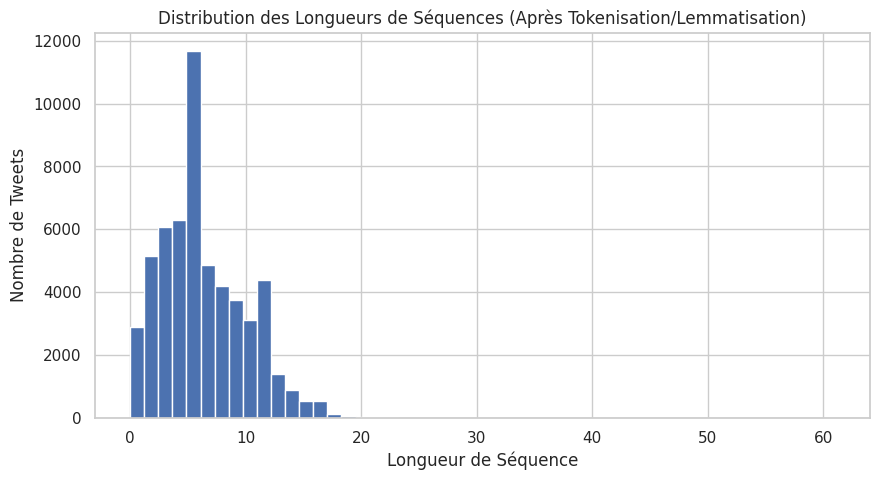

Longueur maximale de séquence choisie (95ème percentile) : 13
Application du padding aux séquences...

Forme des données d'entraînement paddées (X_train_pad): (56000, 13)
Forme des données de validation paddées (X_val_pad):   (12000, 13)
Forme des données de test paddées (X_test_pad):      (12000, 13)

Forme des cibles d'entraînement (y_train): (56000,)
Forme des cibles de validation (y_val):   (12000,)
Forme des cibles de test (y_test):      (12000,)

Préparation des données pour Keras terminée.


In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np
import matplotlib.pyplot as plt # Pour visualiser la distribution des longueurs

# --- Paramètres pour la tokenisation et le padding ---
VOCAB_SIZE = 10000   # Taille du vocabulaire (hyperparamètre à potentiellement ajuster plus tard)
OOV_TOKEN = "<OOV>"  # Token pour les mots hors vocabulaire
TEXT_COLUMN = 'text_lemma' # Colonne à utiliser

# --- 1. Initialiser et Ajuster le Tokenizer ---
print(f"Initialisation et ajustement du Tokenizer sur '{TEXT_COLUMN}' du jeu d'entraînement...")
tokenizer = Tokenizer(num_words=VOCAB_SIZE, oov_token=OOV_TOKEN)

# Ajuster UNIQUEMENT sur les données d'entraînement pour éviter la fuite d'information
tokenizer.fit_on_texts(train_df[TEXT_COLUMN])

# --- 2. Convertir les Textes en Séquences d'Entiers ---
print("Conversion des textes en séquences d'entiers...")
train_sequences = tokenizer.texts_to_sequences(train_df[TEXT_COLUMN])
val_sequences = tokenizer.texts_to_sequences(val_df[TEXT_COLUMN])
test_sequences = tokenizer.texts_to_sequences(test_df[TEXT_COLUMN])

# *** NOUVELLE VÉRIFICATION ***
print("Vérification des séquences vides après tokenisation...")
empty_train_sequences = sum(1 for seq in train_sequences if not seq)
empty_val_sequences = sum(1 for seq in val_sequences if not seq)
empty_test_sequences = sum(1 for seq in test_sequences if not seq)
print(f"Nombre de séquences vides dans train: {empty_train_sequences}")
print(f"Nombre de séquences vides dans val: {empty_val_sequences}")
print(f"Nombre de séquences vides dans test: {empty_test_sequences}")
# Si ce nombre est > 0, cela pourrait être une cause de NaN avec GlobalAveragePooling et mask_zero.
# Une solution simple serait de s'assurer qu'aucune séquence vide n'est passée au padding,
# ou de changer de couche de pooling (ex: GlobalMaxPooling1D).
# Pour l'instant, notons juste si c'est le cas.


# --- 3. Déterminer la Longueur Maximale (maxlen) ---
print("Analyse de la longueur des séquences d'entraînement...")
sequence_lengths = [len(seq) for seq in train_sequences]

# Visualiser la distribution (optionnel mais utile)
plt.figure(figsize=(10, 5))
plt.hist(sequence_lengths, bins=50)
plt.title('Distribution des Longueurs de Séquences (Après Tokenisation/Lemmatisation)')
plt.xlabel('Longueur de Séquence')
plt.ylabel('Nombre de Tweets')
plt.show()

# Choisir maxlen basé sur un percentile (ex: 95ème) pour éviter les extrêmes
# Ceci est un hyperparamètre important
MAX_LEN_PERCENTILE = 95
maxlen = int(np.percentile(sequence_lengths, MAX_LEN_PERCENTILE))
print(f"Longueur maximale de séquence choisie ({MAX_LEN_PERCENTILE}ème percentile) : {maxlen}")
# On pourrait aussi prendre max(sequence_lengths) mais c'est souvent moins efficace

# --- 4. Appliquer le Padding ---
print("Application du padding aux séquences...")
# 'pre' padding est souvent préféré pour les RNNs, mais ok pour le pooling aussi
padding_type = 'pre'
truncating_type = 'post' # Enlever la fin si trop long

X_train_pad = pad_sequences(train_sequences, maxlen=maxlen, padding=padding_type, truncating=truncating_type)
X_val_pad = pad_sequences(val_sequences, maxlen=maxlen, padding=padding_type, truncating=truncating_type)
X_test_pad = pad_sequences(test_sequences, maxlen=maxlen, padding=padding_type, truncating=truncating_type)

# Afficher les formes et un exemple après padding
print(f"\nForme des données d'entraînement paddées (X_train_pad): {X_train_pad.shape}")
print(f"Forme des données de validation paddées (X_val_pad):   {X_val_pad.shape}")
print(f"Forme des données de test paddées (X_test_pad):      {X_test_pad.shape}")
# print("\nExemple de séquence après padding:", X_train_pad[0])


# --- 5. Préparer les cibles (y) ---
# Convertir les cibles en tableaux NumPy est une bonne pratique pour Keras
y_train = np.array(train_df['target'])
y_val = np.array(val_df['target'])
y_test = np.array(test_df['target'])

print(f"\nForme des cibles d'entraînement (y_train): {y_train.shape}")
print(f"Forme des cibles de validation (y_val):   {y_val.shape}")
print(f"Forme des cibles de test (y_test):      {y_test.shape}")

print("\nPréparation des données pour Keras terminée.")

Maintenant que nos données sont préparées (X_train_pad, X_val_pad, X_test_pad, y_train, y_val, y_test), passons à la définition, compilation, entraînement et évaluation de notre premier modèle Deep Learning simple avec Keras, tout en intégrant MLflow.

Démarrage du run MLflow : DL_Simple_Embedding_Keras_MaxPool (ID: e34abc552a72410d916e32dc4aa8560f)
Définition du modèle Keras avec GlobalMaxPooling1D...
Compilation du modèle...


/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:938: UserWarning: Layer 'global_max_pooling1d' (of type GlobalMaxPooling1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 13, 128)        │     1,280,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d            │ (None, 128)            │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,280,129 (4.88 MB)

 Trainable params: 1,280,129 (4.88 MB)

 Non-trainable params: 0 (0.00 B)


Entraînement du modèle...
Epoch 1/10
436/438 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.5583 - loss: 0.6890
Epoch 1: val_loss improved from inf to 0.67238, saving model to ./best_simple_dl_model.keras
438/438 ━━━━━━━━━━━━━━━━━━━━ 12s 24ms/step - accuracy: 0.5586 - loss: 0.6890 - val_accuracy: 0.7085 - val_loss: 0.6724
Epoch 2/10
438/438 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.7013 - loss: 0.6650
Epoch 2: val_loss improved from 0.67238 to 0.63898, saving model to ./best_simple_dl_model.keras
438/438 ━━━━━━━━━━━━━━━━━━━━ 11s 25ms/step - accuracy: 0.7013 - loss: 0.6650 - val_accuracy: 0.7220 - val_loss: 0.6390
Epoch 3/10
438/438 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.7395 - loss: 0.6279
Epoch 3: val_loss improved from 0.63898 to 0.60167, saving model to ./best_simple_dl_model.keras
438/438 ━━━━━━━━━━━━━━━━━━━━ 19s 21ms/step - accuracy: 0.7396 - loss: 0.6279 - val_accuracy: 0.7297 - val_loss: 0.6017
Epoch 4/10
438/438 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.7

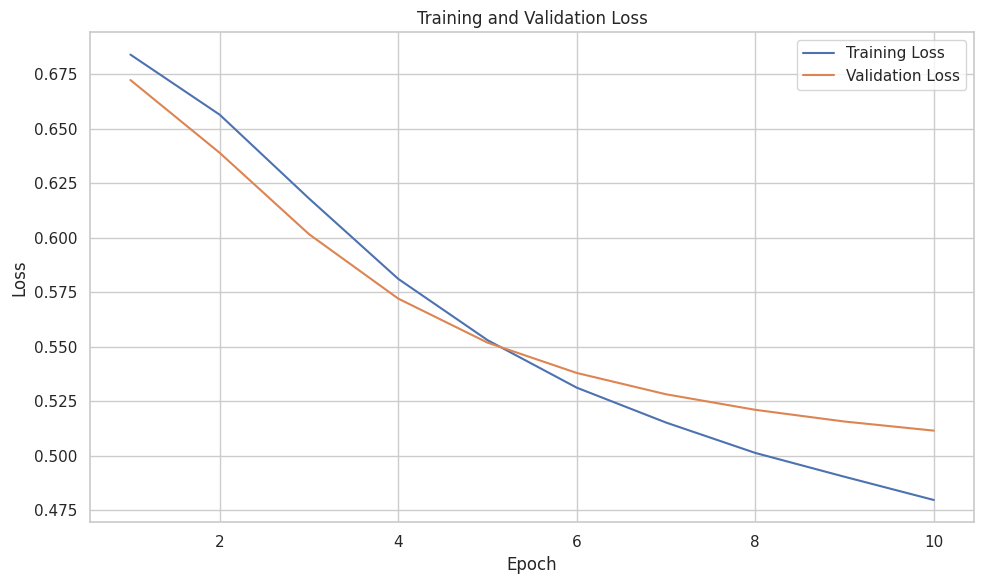

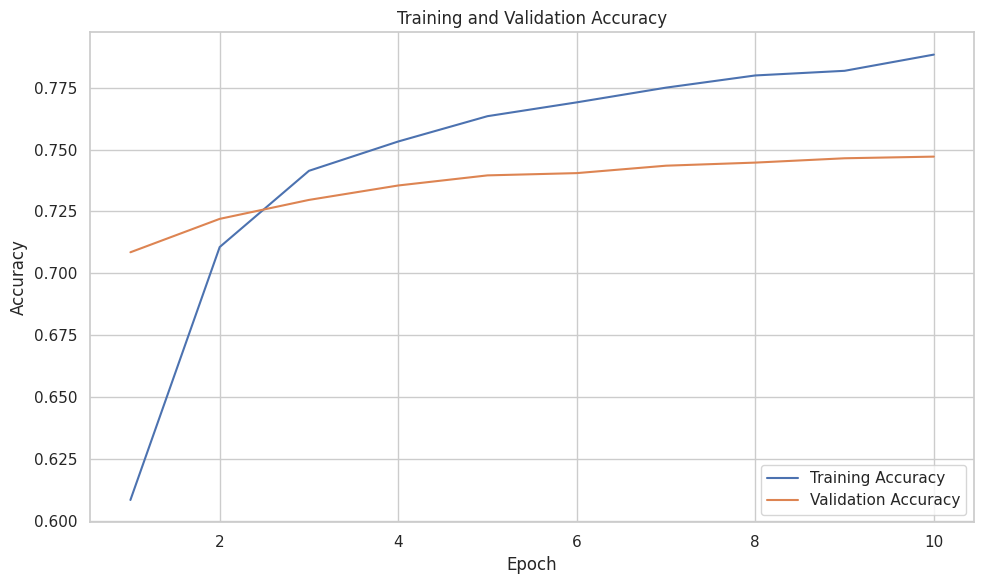

Courbes d'apprentissage sauvegardées dans MLflow.

Génération et sauvegarde de la matrice de confusion (Test Set)...
Matrice de confusion sauvegardée dans MLflow.


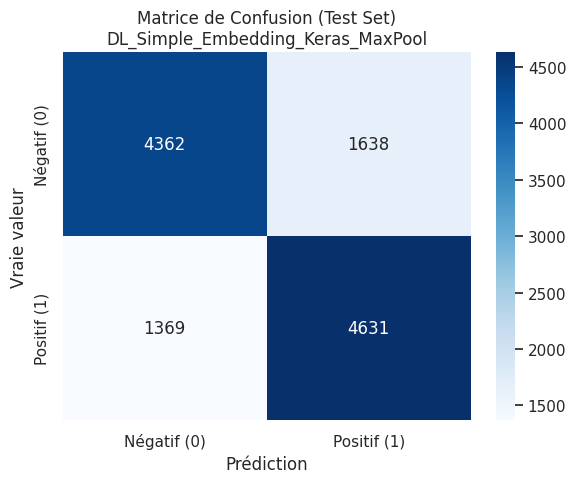

2025/04/29 07:22:43 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.



Sauvegarde du modèle Keras avec MLflow...


2025/04/29 07:22:57 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Modèle Keras sauvegardé dans MLflow.
Fichier checkpoint local './best_simple_dl_model.keras' supprimé.

Run MLflow (DL_Simple_Embedding_Keras_MaxPool) terminé.


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, GlobalMaxPooling1D, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import (accuracy_score, f1_score, precision_score,
                             recall_score, confusion_matrix) # Ajout confusion_matrix

import mlflow
import mlflow.tensorflow
import time
import os
import numpy as np
import matplotlib.pyplot as plt # Nécessaire pour les graphiques
import seaborn as sns          # Pour la heatmap

# --- Assurez-vous que les variables suivantes sont définies ---
# X_train_pad, y_train, X_val_pad, y_val, X_test_pad, y_test
# VOCAB_SIZE, maxlen
if 'X_train_pad' not in locals(): raise NameError("X_train_pad n'est pas défini")
if 'y_train' not in locals(): raise NameError("y_train n'est pas défini")
if 'X_val_pad' not in locals(): raise NameError("X_val_pad n'est pas défini")
if 'y_val' not in locals(): raise NameError("y_val n'est pas défini")
if 'X_test_pad' not in locals(): raise NameError("X_test_pad n'est pas défini")
if 'y_test' not in locals(): raise NameError("y_test n'est pas défini")
if 'VOCAB_SIZE' not in locals(): raise NameError("VOCAB_SIZE n'est pas défini")
if 'maxlen' not in locals(): raise NameError("maxlen n'est pas défini")
if 'TEXT_COLUMN' not in locals(): TEXT_COLUMN = 'text_lemma' # Default

# --- Paramètres (identiques à votre code) ---
EMBEDDING_DIM = 128
DROPOUT_RATE = 0.3
EPOCHS = 10
BATCH_SIZE = 128
EARLY_STOPPING_PATIENCE = 2
LEARNING_RATE = 0.0001
CLIPNORM = 1.0
best_model_filepath = './best_simple_dl_model.keras'

# --- Configuration et Lancement MLflow ---
mlflow.set_experiment("AirParadis_Sentiment_Analysis")
run_name = "DL_Simple_Embedding_Keras_MaxPool"

with mlflow.start_run(run_name=run_name) as run: # Utiliser 'as run' pour obtenir l'ID si besoin
    print(f"Démarrage du run MLflow : {run_name} (ID: {run.info.run_id})")
    start_time = time.time()

    # --- Log des Paramètres ---
    mlflow.log_param("text_preprocessing", TEXT_COLUMN)
    mlflow.log_param("model_type", "Sequential_Embedding_MaxPool_Dense")
    mlflow.log_param("pooling_layer", "GlobalMaxPooling1D")
    mlflow.log_param("embedding_type", "Keras_trainable")
    mlflow.log_param("vocab_size_limit", VOCAB_SIZE)
    mlflow.log_param("maxlen", maxlen)
    mlflow.log_param("embedding_dim", EMBEDDING_DIM)
    mlflow.log_param("dropout_rate", DROPOUT_RATE)
    mlflow.log_param("learning_rate", LEARNING_RATE)
    mlflow.log_param("optimizer_clipnorm", CLIPNORM)
    mlflow.log_param("epochs_max", EPOCHS) # Renommé pour clarté
    mlflow.log_param("batch_size", BATCH_SIZE)
    mlflow.log_param("early_stopping_patience", EARLY_STOPPING_PATIENCE)

    # --- Définition du Modèle Keras ---
    print("Définition du modèle Keras avec GlobalMaxPooling1D...")
    model = Sequential([
        Embedding(input_dim=VOCAB_SIZE, output_dim=EMBEDDING_DIM, mask_zero=True), # mask_zero est souvent utile
        GlobalMaxPooling1D(),
        Dropout(DROPOUT_RATE),
        Dense(1, activation='sigmoid')
    ])

    # --- Compilation du Modèle ---
    print("Compilation du modèle...")
    optimizer = Adam(learning_rate=LEARNING_RATE, clipnorm=CLIPNORM)
    model.compile(
        loss='binary_crossentropy',
        optimizer=optimizer,
        metrics=['accuracy']
    )
    model.build(input_shape=(None, maxlen)) # Construire pour avoir le summary
    model.summary()
    mlflow.log_param("model_summary_json", model.to_json()) # Log le summary JSON

    # --- Callbacks ---
    early_stopping = EarlyStopping(monitor='val_loss', patience=EARLY_STOPPING_PATIENCE, restore_best_weights=True, verbose=1)
    model_checkpoint = ModelCheckpoint(filepath=best_model_filepath, monitor='val_loss', save_best_only=True, verbose=1)

    # --- Entraînement du Modèle ---
    print("\nEntraînement du modèle...")
    history = model.fit(
        X_train_pad, y_train,
        epochs=EPOCHS,
        batch_size=BATCH_SIZE,
        validation_data=(X_val_pad, y_val),
        callbacks=[early_stopping, model_checkpoint],
        verbose=1
    )
    training_time = time.time() - start_time
    print(f"Entraînement terminé en {training_time:.2f} secondes.")
    mlflow.log_metric("training_time_seconds", training_time)
    actual_epochs = len(history.history['loss'])
    mlflow.log_param("actual_epochs_trained", actual_epochs)

    # --- Utilisation du Meilleur Modèle ---
    best_model = model # Car restore_best_weights=True

    # --- Évaluation Finale ---
    print("\nÉvaluation finale du meilleur modèle...")
    train_loss, train_accuracy = best_model.evaluate(X_train_pad, y_train, verbose=0, batch_size=1024)
    val_loss, val_accuracy = best_model.evaluate(X_val_pad, y_val, verbose=0, batch_size=1024)
    test_loss, test_accuracy = best_model.evaluate(X_test_pad, y_test, verbose=0, batch_size=1024)

    print(f"Train - Loss: {train_loss:.4f}, Accuracy: {train_accuracy:.4f}")
    mlflow.log_metric("best_train_loss", train_loss)
    mlflow.log_metric("best_train_accuracy", train_accuracy)
    print(f"Validation - Loss: {val_loss:.4f}, Accuracy: {val_accuracy:.4f}")
    mlflow.log_metric("best_val_loss", val_loss)
    mlflow.log_metric("best_val_accuracy", val_accuracy)
    print(f"Test - Loss: {test_loss:.4f}, Accuracy: {test_accuracy:.4f}")
    mlflow.log_metric("best_test_loss", test_loss)
    mlflow.log_metric("best_test_accuracy", test_accuracy)

    # --- Calcul et Log des Métriques Détaillées (F1, P, R) ---
    print("\nCalcul des métriques détaillées (F1, Precision, Recall)...")
    y_train_proba = best_model.predict(X_train_pad, batch_size=1024)
    y_val_proba = best_model.predict(X_val_pad, batch_size=1024)
    y_test_proba = best_model.predict(X_test_pad, batch_size=1024)
    y_train_pred_class = (y_train_proba > 0.5).astype(int)
    y_val_pred_class = (y_val_proba > 0.5).astype(int)
    y_test_pred_class = (y_test_proba > 0.5).astype(int)

    # Calcul des métriques
    metrics = {}
    metrics['train_f1'] = f1_score(y_train, y_train_pred_class)
    metrics['train_precision'] = precision_score(y_train, y_train_pred_class)
    metrics['train_recall'] = recall_score(y_train, y_train_pred_class)
    metrics['val_f1'] = f1_score(y_val, y_val_pred_class)
    metrics['val_precision'] = precision_score(y_val, y_val_pred_class)
    metrics['val_recall'] = recall_score(y_val, y_val_pred_class)
    metrics['test_f1'] = f1_score(y_test, y_test_pred_class)
    metrics['test_precision'] = precision_score(y_test, y_test_pred_class)
    metrics['test_recall'] = recall_score(y_test, y_test_pred_class)

    print(f"Train      - F1: {metrics['train_f1']:.4f}, Precision: {metrics['train_precision']:.4f}, Recall: {metrics['train_recall']:.4f}")
    print(f"Validation - F1: {metrics['val_f1']:.4f}, Precision: {metrics['val_precision']:.4f}, Recall: {metrics['val_recall']:.4f}")
    print(f"Test       - F1: {metrics['test_f1']:.4f}, Precision: {metrics['test_precision']:.4f}, Recall: {metrics['test_recall']:.4f}")

    # Logguer toutes les métriques détaillées
    mlflow.log_metrics({f"best_{k}": v for k, v in metrics.items()}) # Préfixe 'best_' pour clarté

    # ***********************************************
    # ***** NOUVEAU : VISUALISATION DES COURBES *****
    # ***********************************************
    print("\nGénération et sauvegarde des courbes d'apprentissage...")
    epochs_range = range(1, actual_epochs + 1)

    # --- Courbe de Loss ---
    fig_loss, ax_loss = plt.subplots(figsize=(10, 6))
    ax_loss.plot(epochs_range, history.history['loss'], label='Training Loss')
    ax_loss.plot(epochs_range, history.history['val_loss'], label='Validation Loss')
    ax_loss.set_title('Training and Validation Loss')
    ax_loss.set_xlabel('Epoch')
    ax_loss.set_ylabel('Loss')
    ax_loss.legend(loc='upper right')
    ax_loss.grid(True)
    plt.tight_layout()
    # Sauvegarder dans MLflow
    mlflow.log_figure(fig_loss, "learning_curves_loss.png")
    plt.show()
    plt.close(fig_loss) # Fermer pour éviter l'affichage dans Colab

    # --- Courbe d'Accuracy ---
    fig_acc, ax_acc = plt.subplots(figsize=(10, 6))
    ax_acc.plot(epochs_range, history.history['accuracy'], label='Training Accuracy')
    ax_acc.plot(epochs_range, history.history['val_accuracy'], label='Validation Accuracy')
    ax_acc.set_title('Training and Validation Accuracy')
    ax_acc.set_xlabel('Epoch')
    ax_acc.set_ylabel('Accuracy')
    ax_acc.legend(loc='lower right')
    ax_acc.grid(True)
    plt.tight_layout()
    # Sauvegarder dans MLflow
    mlflow.log_figure(fig_acc, "learning_curves_accuracy.png")
    plt.show()
    plt.close(fig_acc) # Fermer pour éviter l'affichage dans Colab

    print("Courbes d'apprentissage sauvegardées dans MLflow.")
    # ***********************************************
    # ***** FIN NOUVEAU : VISUALISATION         *****
    # ***********************************************

    # --- Matrice de Confusion (code existant) ---
    print("\nGénération et sauvegarde de la matrice de confusion (Test Set)...")
    cm = confusion_matrix(y_test, y_test_pred_class)
    fig_cm, ax_cm = plt.subplots(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax_cm,
                xticklabels=['Négatif (0)', 'Positif (1)'],
                yticklabels=['Négatif (0)', 'Positif (1)'])
    ax_cm.set_xlabel('Prédiction')
    ax_cm.set_ylabel('Vraie valeur')
    ax_cm.set_title(f'Matrice de Confusion (Test Set)\n{run_name}') # Ajouter nom du run au titre
    plt.tight_layout()
    # plt.show() # Décommenter si vous voulez voir dans Colab aussi
    mlflow.log_figure(fig_cm, "confusion_matrix_test_set.png")
    print("Matrice de confusion sauvegardée dans MLflow.")
    plt.show()
    plt.close(fig_cm)

    # --- Sauvegarde du Modèle Keras avec MLflow ---
    print("\nSauvegarde du modèle Keras avec MLflow...")
    mlflow.tensorflow.log_model(
        model=best_model,
        artifact_path="keras-simple-embedding-maxpool-model" # Nom artefact
    )
    print("Modèle Keras sauvegardé dans MLflow.")

    # --- Nettoyage du Checkpoint ---
    if os.path.exists(best_model_filepath):
        os.remove(best_model_filepath)
        print(f"Fichier checkpoint local '{best_model_filepath}' supprimé.")

print(f"\nRun MLflow ({run_name}) terminé.")

Ce premier modèle Deep Learning simple (F1 Test: ~0.755) **diminue légèrement** la performance de la baseline TF-IDF/LogReg (F1 Test: ~0.758). Il **généralise bien** (peu d'écart entre train/val/test).

## Expérimentation 3 & 4 : Embeddings Pré-entraînés (Word2Vec/GloVe/FastText)

On passe à l'étape suivante : intégrer une couche **LSTM (Long Short-Term Memory)** et tester **deux approches d'embedding différentes** pour voir comment elles performent avec cette architecture plus avancée.

Nous allons donc mener deux expériences, toutes deux utilisant l'architecture LSTM, mais en variant l'initialisation de la couche Embedding :

**Expérimentation 3 : GloVe Pré-entraîné + LSTM**

    Télécharger les vecteurs GloVe (ex: glove.6B.100d.txt).

    Parser le fichier .txt.

    Créer la matrice d'embedding GloVe pour Keras.

    Entraîner le modèle Keras : Input -> Embedding(GloVe, trainable=False) -> LSTM -> Dense.

    Évaluer et logger sur MLflow (en indiquant clairement "GloVe_pretrained").

**Expérimentation 4 : FastText Pré-entraîné + LSTM**

    Télécharger les vecteurs FastText (ex: wiki-news-300d-1M.vec).

    Parser le fichier .vec.

    Créer la matrice d'embedding FastText pour Keras.

    Entraîner le modèle Keras : Input -> Embedding(FastText, trainable=False) -> LSTM -> Dense.

    Évaluer et logger sur MLflow (en indiquant clairement "FastText_pretrained").


Nous allons télécharger la version "glove.6B", qui contient des vecteurs entraînés sur 6 milliards de tokens (Wikipedia + Gigaword). Elle est disponible en différentes dimensions (50d, 100d, 200d, 300d). Utilisons la version 100d (100 dimensions), qui est un bon compromis taille/performance pour commencer.

In [ ]:
import os
import requests
import zipfile
import io # Pour gérer le zip en mémoire si possible, sinon fichier

# URL pour télécharger GloVe (peut changer, vérifier si besoin)
# Source alternative si Stanford est lent/bloqué: chercher "glove.6B.zip kaggle" ou autre miroir
# Cette URL provient directement de la page NLP de Stanford
glove_url = 'https://nlp.stanford.edu/data/glove.6B.zip'
# Chemin local où extraire le fichier .txt spécifique
glove_extract_path = './glove.6B.100d.txt' # On extraira directement dans le dossier courant Colab
zip_file_path = './glove.6B.zip'

# Vérifier si le fichier .txt existe déjà pour éviter de retélécharger/dézipper
if not os.path.exists(glove_extract_path):
    print(f"Téléchargement de {glove_url}...")
    try:
        response = requests.get(glove_url, stream=True)
        response.raise_for_status() # Vérifie si la requête a réussi

        # Écrire le contenu téléchargé dans un fichier zip local
        with open(zip_file_path, 'wb') as f:
            for chunk in response.iter_content(chunk_size=8192):
                f.write(chunk)
        print("Téléchargement terminé.")

        print(f"Extraction de '{os.path.basename(glove_extract_path)}' depuis {zip_file_path}...")
        with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
            # Extraire uniquement le fichier 100d
            zip_ref.extract('glove.6B.100d.txt', path='.') # Extrait dans le dossier courant
        print("Extraction terminée.")

        # Nettoyer le fichier zip téléchargé
        os.remove(zip_file_path)
        print(f"Fichier {zip_file_path} supprimé.")

    except requests.exceptions.RequestException as e:
        print(f"Erreur lors du téléchargement de GloVe : {e}")
        print("Veuillez vérifier l'URL ou votre connexion internet.")
        # Gérer l'erreur comme approprié
    except Exception as e:
        print(f"Erreur lors de l'extraction ou du nettoyage : {e}")

else:
    print(f"Le fichier '{glove_extract_path}' existe déjà. Saut du téléchargement/extraction.")

Téléchargement de https://nlp.stanford.edu/data/glove.6B.zip...
Téléchargement terminé.
Extraction de 'glove.6B.100d.txt' depuis ./glove.6B.zip...
Extraction terminée.
Fichier ./glove.6B.zip supprimé.


Maintenant, lisons le fichier glove.6B.100d.txt et créons un dictionnaire qui mappe chaque mot à son vecteur NumPy.

In [ ]:
import numpy as np
import time

# Dictionnaire pour stocker les embeddings mot -> vecteur
embeddings_index = {}
# Dimension des embeddings GloVe que nous utilisons (doit correspondre au fichier !)
GLOVE_EMBEDDING_DIM = 100

print(f"Parsing du fichier GloVe '{glove_extract_path}'...")
start_time_parse = time.time()

try:
    with open(glove_extract_path, 'r', encoding='utf-8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            try:
                # Tenter de convertir les coefficients en float
                coefs = np.asarray(values[1:], dtype='float32')
                # Vérifier si la dimension est correcte (parfois lignes corrompues)
                if len(coefs) == GLOVE_EMBEDDING_DIM:
                    embeddings_index[word] = coefs
                # else:
                    # print(f"Skipping line for word '{word}': incorrect dimension {len(coefs)}") # Debug
            except ValueError:
                # print(f"Skipping line for word '{word}': could not parse coefficients") # Debug
                # Ignorer les lignes où les coefficients ne sont pas des nombres valides
                pass

    parsing_time = time.time() - start_time_parse
    print(f"Parsing terminé en {parsing_time:.2f} secondes.")
    print(f"Trouvé {len(embeddings_index)} vecteurs de mots dans le fichier GloVe.")

    # Vérifier un vecteur exemple
    if 'the' in embeddings_index:
         print("Exemple de vecteur GloVe pour 'the' (premières 10 dims):", embeddings_index['the'][:10])
    else:
        print("'the' non trouvé dans l'index, vérifiez le parsing.")

except FileNotFoundError:
    print(f"Erreur : Le fichier '{glove_extract_path}' n'a pas été trouvé.")
    print("Veuillez exécuter la cellule de téléchargement/extraction d'abord.")
except Exception as e:
     print(f"Une erreur est survenue pendant le parsing : {e}")

Parsing du fichier GloVe './glove.6B.100d.txt'...
Parsing terminé en 12.25 secondes.
Trouvé 400000 vecteurs de mots dans le fichier GloVe.
Exemple de vecteur GloVe pour 'the' (premières 10 dims): [-0.038194 -0.24487   0.72812  -0.39961   0.083172  0.043953 -0.39141
  0.3344   -0.57545   0.087459]


In [ ]:
import numpy as np

# --- Prérequis ---
if 'tokenizer' not in locals():
    raise NameError("Le 'tokenizer' Keras n'est pas défini. Veuillez exécuter la cellule de préparation Keras.")
if 'embeddings_index' not in locals():
     raise NameError("'embeddings_index' GloVe n'est pas défini. Veuillez exécuter la cellule de parsing GloVe.")
if 'VOCAB_SIZE' not in locals():
     raise NameError("'VOCAB_SIZE' (pour le tokenizer Keras) n'est pas défini.")
if 'GLOVE_EMBEDDING_DIM' not in locals():
      raise NameError("'GLOVE_EMBEDDING_DIM' n'est pas défini.")


# Obtenir l'index mot -> entier du tokenizer Keras
word_index = tokenizer.word_index
# Note: Le tokenizer limite déjà aux VOCAB_SIZE mots les plus fréquents,
# mais word_index peut contenir plus de mots si fit_on_texts a vu plus
# de mots uniques au total avant de prendre le top VOCAB_SIZE.
# Nous ne préparons la matrice que pour les mots qui seront effectivement utilisés
# par la couche Embedding Keras (indices 1 à VOCAB_SIZE-1).

print(f"Préparation de la matrice d'embedding pour Keras...")
print(f"Taille cible du vocabulaire Keras (VOCAB_SIZE) : {VOCAB_SIZE}")
print(f"Dimension des embeddings GloVe : {GLOVE_EMBEDDING_DIM}")

# Initialiser la matrice d'embedding avec des zéros
# La taille est VOCAB_SIZE car l'input_dim de la couche Embedding sera VOCAB_SIZE
# (indices de 0 à VOCAB_SIZE-1)
embedding_matrix_glove = np.zeros((VOCAB_SIZE, GLOVE_EMBEDDING_DIM))

# Remplir la matrice
num_words_in_glove = 0
num_words_not_in_glove = 0
for word, i in word_index.items():
    # Ne considérer que les mots dans la limite de notre vocabulaire Keras
    if i < VOCAB_SIZE:
        embedding_vector = embeddings_index.get(word) # Récupérer le vecteur GloVe
        if embedding_vector is not None:
            # Mot trouvé dans GloVe, on l'ajoute à la matrice
            embedding_matrix_glove[i] = embedding_vector
            num_words_in_glove += 1
        else:
            # Mot non trouvé dans GloVe, il restera à zéro dans la matrice
            # (Alternative: initialiser avec de petites valeurs aléatoires)
            num_words_not_in_glove += 1

print(f"\nMatrice d'embedding GloVe créée avec la forme : {embedding_matrix_glove.shape}")
print(f"Nombre de mots du vocabulaire Keras trouvés dans GloVe : {num_words_in_glove}")
print(f"Nombre de mots du vocabulaire Keras NON trouvés dans GloVe : {num_words_not_in_glove}")
coverage = (num_words_in_glove / min(VOCAB_SIZE -1, len(word_index))) * 100 # -1 car index 0 non utilisé
print(f"Couverture approximative du vocabulaire par GloVe : {coverage:.2f}%")

# La variable 'embedding_matrix_glove' est maintenant prête à être utilisée
# dans la couche Embedding de Keras.

Préparation de la matrice d'embedding pour Keras...
Taille cible du vocabulaire Keras (VOCAB_SIZE) : 10000
Dimension des embeddings GloVe : 100

Matrice d'embedding GloVe créée avec la forme : (10000, 100)
Nombre de mots du vocabulaire Keras trouvés dans GloVe : 9000
Nombre de mots du vocabulaire Keras NON trouvés dans GloVe : 999
Couverture approximative du vocabulaire par GloVe : 90.01%


Avec une couverture de >91%, la plupart des mots fourniront un contexte riche, ce qui devrait permettre à l'LSTM de bien fonctionner malgré les quelques mots inconnus.

Démarrage du run MLflow : LSTM_GloVe_Pretrained (ID: 8a1bd56c511c499b9f4f907ea2a26faf)
Log des paramètres dans MLflow...

Définition du modèle Keras LSTM avec GloVe...
Compilation du modèle...


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ (None, 13, 100)        │     1,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 64)             │        42,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,042,305 (3.98 MB)

 Trainable params: 42,305 (165.25 KB)

 Non-trainable params: 1,000,000 (3.81 MB)


Entraînement du modèle LSTM + GloVe...
Epoch 1/10
438/438 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.6468 - loss: 0.6265
Epoch 1: val_loss improved from inf to 0.56818, saving model to ./best_lstm_glove_model.keras
438/438 ━━━━━━━━━━━━━━━━━━━━ 27s 49ms/step - accuracy: 0.6468 - loss: 0.6265 - val_accuracy: 0.7019 - val_loss: 0.5682
Epoch 2/10
437/438 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.6966 - loss: 0.5728
Epoch 2: val_loss improved from 0.56818 to 0.54437, saving model to ./best_lstm_glove_model.keras
438/438 ━━━━━━━━━━━━━━━━━━━━ 19s 43ms/step - accuracy: 0.6967 - loss: 0.5728 - val_accuracy: 0.7207 - val_loss: 0.5444
Epoch 3/10
437/438 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.7186 - loss: 0.5475
Epoch 3: val_loss improved from 0.54437 to 0.53542, saving model to ./best_lstm_glove_model.keras
438/438 ━━━━━━━━━━━━━━━━━━━━ 20s 43ms/step - accuracy: 0.7186 - loss: 0.5475 - val_accuracy: 0.7317 - val_loss: 0.5354
Epoch 4/10
438/438 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step

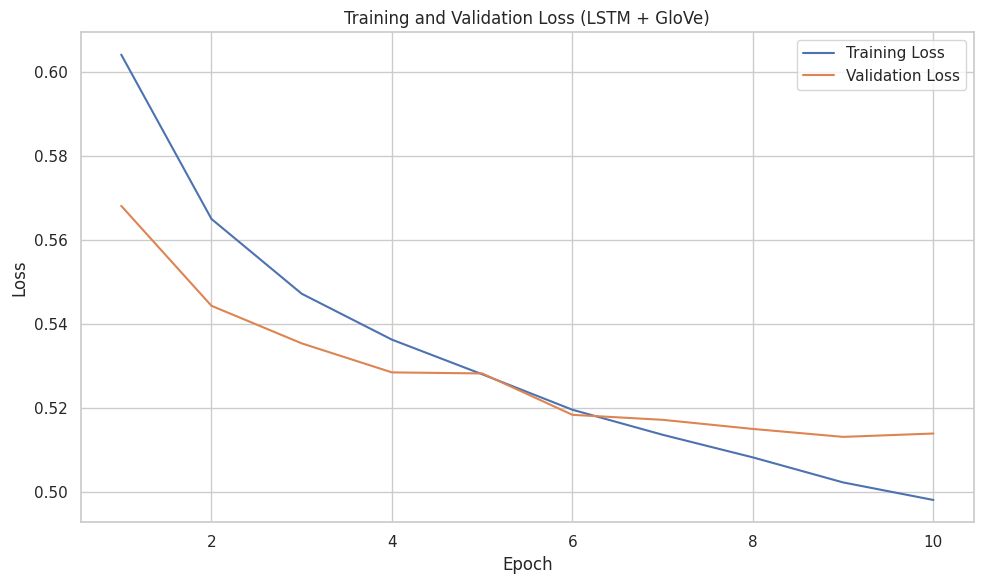

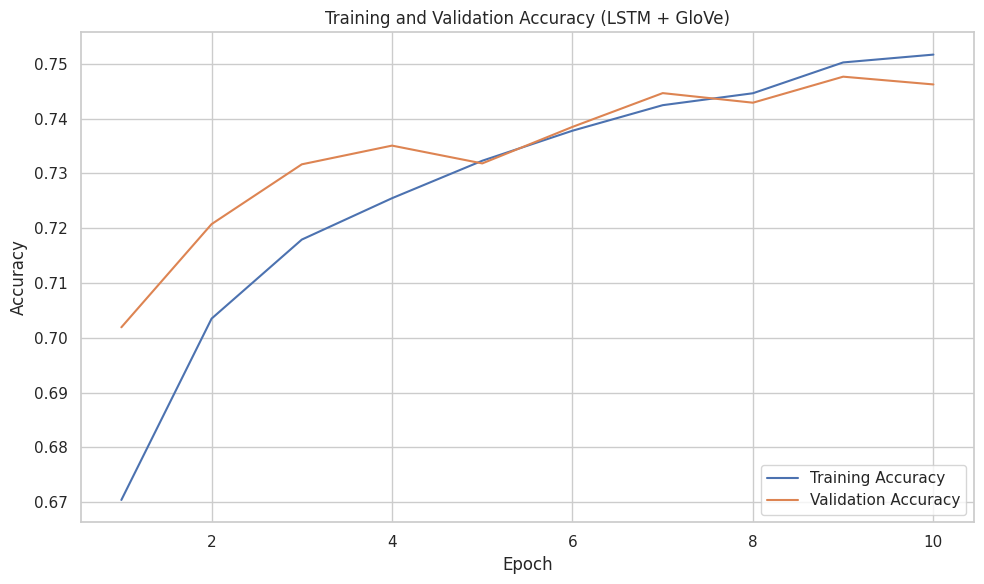

Courbes d'apprentissage sauvegardées dans MLflow.

Génération et sauvegarde de la matrice de confusion (Test Set)...
Matrice de confusion sauvegardée dans MLflow.


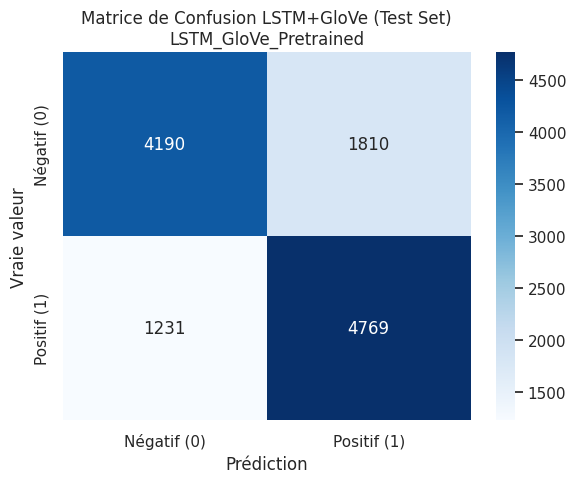

2025/04/29 07:30:24 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.



Sauvegarde du modèle Keras avec MLflow...


2025/04/29 07:30:38 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Modèle Keras sauvegardé dans MLflow.
Fichier checkpoint local './best_lstm_glove_model.keras' supprimé.

Run MLflow (LSTM_GloVe_Pretrained) terminé.


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout # Bidirectional retiré car non utilisé ici
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import (accuracy_score, f1_score, precision_score,
                             recall_score, confusion_matrix) # Métriques sklearn

# --- Importation MLflow et autres ---
import mlflow
import mlflow.tensorflow # Important pour Keras
import time
import os
import numpy as np
import matplotlib.pyplot as plt # Pour les graphiques
import seaborn as sns          # Pour la heatmap

# --- Prérequis (Vérification) ---
if 'X_train_pad' not in locals(): raise NameError("X_train_pad non défini")
if 'y_train' not in locals(): raise NameError("y_train non défini")
if 'X_val_pad' not in locals(): raise NameError("X_val_pad non défini")
if 'y_val' not in locals(): raise NameError("y_val non défini")
if 'X_test_pad' not in locals(): raise NameError("X_test_pad non défini")
if 'y_test' not in locals(): raise NameError("y_test non défini")
if 'embedding_matrix_glove' not in locals(): raise NameError("embedding_matrix_glove non définie.")
if 'VOCAB_SIZE' not in locals(): raise NameError("VOCAB_SIZE non défini")
if 'GLOVE_EMBEDDING_DIM' not in locals(): raise NameError("GLOVE_EMBEDDING_DIM non défini")
if 'maxlen' not in locals(): raise NameError("maxlen non défini")
if 'TEXT_COLUMN' not in locals(): TEXT_COLUMN = 'text_lemma' # Default

# --- Paramètres du Modèle LSTM (Déjà définis, vérification) ---
LSTM_UNITS = 64
DROPOUT_RATE_LSTM = 0.2

# --- Paramètres d'Entraînement (Déjà définis, vérification) ---
EPOCHS = 10
BATCH_SIZE = 128
EARLY_STOPPING_PATIENCE = 2
LEARNING_RATE = 0.001
CLIPNORM = 1.0
best_model_filepath_lstm_glove = './best_lstm_glove_model.keras' # Chemin Checkpoint

# --- Configuration et Lancement MLflow ---
mlflow.set_experiment("AirParadis_Sentiment_Analysis")
run_name = "LSTM_GloVe_Pretrained" # Garder le même nom si c'est une ré-exécution

with mlflow.start_run(run_name=run_name) as run: # Utiliser 'as run'
    print(f"Démarrage du run MLflow : {run_name} (ID: {run.info.run_id})")
    start_time_glove_exp = time.time() # Utiliser un nom de variable unique

    # --- Log des Paramètres ---
    print("Log des paramètres dans MLflow...")
    # (Reprendre les mêmes paramètres que dans votre code original)
    mlflow.log_param("text_preprocessing", TEXT_COLUMN)
    mlflow.log_param("model_type", "LSTM")
    mlflow.log_param("embedding_type", "GloVe_pretrained")
    mlflow.log_param("glove_embedding_dim", GLOVE_EMBEDDING_DIM)
    mlflow.log_param("vocab_size_limit", VOCAB_SIZE)
    mlflow.log_param("maxlen", maxlen)
    mlflow.log_param("lstm_units", LSTM_UNITS)
    mlflow.log_param("lstm_dropout", DROPOUT_RATE_LSTM)
    mlflow.log_param("learning_rate", LEARNING_RATE)
    mlflow.log_param("optimizer_clipnorm", CLIPNORM)
    mlflow.log_param("epochs_max", EPOCHS) # Renommé
    mlflow.log_param("batch_size", BATCH_SIZE)
    mlflow.log_param("early_stopping_patience", EARLY_STOPPING_PATIENCE)
    mlflow.log_param("embedding_trainable", False)

    # --- Définition du Modèle Keras ---
    print("\nDéfinition du modèle Keras LSTM avec GloVe...")
    model_lstm_glove = Sequential([
        Embedding(
            input_dim=VOCAB_SIZE,
            output_dim=GLOVE_EMBEDDING_DIM,
            weights=[embedding_matrix_glove],
            input_length=maxlen, # input_length est déprécié mais gardé pour cohérence avec le code fourni
            trainable=False,
            mask_zero=True
        ),
        LSTM(LSTM_UNITS, dropout=DROPOUT_RATE_LSTM, recurrent_dropout=DROPOUT_RATE_LSTM),
        Dense(1, activation='sigmoid')
    ])

    # --- Compilation du Modèle ---
    print("Compilation du modèle...")
    optimizer_glove = Adam(learning_rate=LEARNING_RATE, clipnorm=CLIPNORM) # Renommer pour éviter conflit potentiel
    model_lstm_glove.compile(
        loss='binary_crossentropy',
        optimizer=optimizer_glove,
        metrics=['accuracy']
    )
    model_lstm_glove.build(input_shape=(None, maxlen)) # Construire pour summary
    model_lstm_glove.summary()
    mlflow.log_param("model_summary_json", model_lstm_glove.to_json()) # Log summary

    # --- Callbacks ---
    early_stopping_glove = EarlyStopping(monitor='val_loss', patience=EARLY_STOPPING_PATIENCE, restore_best_weights=True, verbose=1) # Renommer
    model_checkpoint_glove = ModelCheckpoint(filepath=best_model_filepath_lstm_glove, monitor='val_loss', save_best_only=True, verbose=1) # Renommer

    # --- Entraînement du Modèle ---
    print("\nEntraînement du modèle LSTM + GloVe...")
    # Utiliser un nom de variable unique pour l'historique
    history_glove = model_lstm_glove.fit(
        X_train_pad, y_train,
        epochs=EPOCHS,
        batch_size=BATCH_SIZE,
        validation_data=(X_val_pad, y_val),
        callbacks=[early_stopping_glove, model_checkpoint_glove],
        verbose=1
    )
    training_time_glove = time.time() - start_time_glove_exp # Utiliser nom unique
    print(f"Entraînement terminé en {training_time_glove:.2f} secondes.")
    mlflow.log_metric("training_time_seconds", training_time_glove)
    actual_epochs_glove = len(history_glove.history['loss']) # Utiliser history_glove
    mlflow.log_param("actual_epochs_trained", actual_epochs_glove)

    # --- Utilisation du Meilleur Modèle ---
    best_model_lstm_glove = model_lstm_glove # Car restore_best_weights=True

    # --- Évaluation Finale ---
    print("\nÉvaluation finale (Loss, Accuracy Keras)...")
    train_loss, train_accuracy = best_model_lstm_glove.evaluate(X_train_pad, y_train, verbose=0, batch_size=1024)
    val_loss, val_accuracy = best_model_lstm_glove.evaluate(X_val_pad, y_val, verbose=0, batch_size=1024)
    test_loss, test_accuracy = best_model_lstm_glove.evaluate(X_test_pad, y_test, verbose=0, batch_size=1024)
    print(f"Train - Loss: {train_loss:.4f}, Accuracy: {train_accuracy:.4f}")
    mlflow.log_metric("best_train_loss", train_loss)
    mlflow.log_metric("best_train_accuracy", train_accuracy)
    print(f"Validation - Loss: {val_loss:.4f}, Accuracy: {val_accuracy:.4f}")
    mlflow.log_metric("best_val_loss", val_loss)
    mlflow.log_metric("best_val_accuracy", val_accuracy)
    print(f"Test - Loss: {test_loss:.4f}, Accuracy: {test_accuracy:.4f}")
    mlflow.log_metric("best_test_loss", test_loss)
    mlflow.log_metric("best_test_accuracy", test_accuracy)

    # --- Calcul et Log des Métriques Détaillées (F1, P, R) ---
    print("\nCalcul des métriques détaillées (F1, Precision, Recall)...")
    y_train_proba_glove = best_model_lstm_glove.predict(X_train_pad, batch_size=1024) # Utiliser nom unique
    y_val_proba_glove = best_model_lstm_glove.predict(X_val_pad, batch_size=1024)   # Utiliser nom unique
    y_test_proba_glove = best_model_lstm_glove.predict(X_test_pad, batch_size=1024)  # Utiliser nom unique
    y_train_pred_class_glove = (y_train_proba_glove > 0.5).astype(int) # Utiliser nom unique
    y_val_pred_class_glove = (y_val_proba_glove > 0.5).astype(int)     # Utiliser nom unique
    y_test_pred_class_glove = (y_test_proba_glove > 0.5).astype(int)    # Utiliser nom unique

    # Calcul des métriques
    metrics_glove = {} # Utiliser nom unique
    metrics_glove['train_f1'] = f1_score(y_train, y_train_pred_class_glove)
    metrics_glove['train_precision'] = precision_score(y_train, y_train_pred_class_glove)
    metrics_glove['train_recall'] = recall_score(y_train, y_train_pred_class_glove)
    metrics_glove['val_f1'] = f1_score(y_val, y_val_pred_class_glove)
    metrics_glove['val_precision'] = precision_score(y_val, y_val_pred_class_glove)
    metrics_glove['val_recall'] = recall_score(y_val, y_val_pred_class_glove)
    metrics_glove['test_f1'] = f1_score(y_test, y_test_pred_class_glove)
    metrics_glove['test_precision'] = precision_score(y_test, y_test_pred_class_glove)
    metrics_glove['test_recall'] = recall_score(y_test, y_test_pred_class_glove)

    print(f"Train      - F1: {metrics_glove['train_f1']:.4f}, Precision: {metrics_glove['train_precision']:.4f}, Recall: {metrics_glove['train_recall']:.4f}")
    print(f"Validation - F1: {metrics_glove['val_f1']:.4f}, Precision: {metrics_glove['val_precision']:.4f}, Recall: {metrics_glove['val_recall']:.4f}")
    print(f"Test       - F1: {metrics_glove['test_f1']:.4f}, Precision: {metrics_glove['test_precision']:.4f}, Recall: {metrics_glove['test_recall']:.4f}")

    # Logguer toutes les métriques détaillées
    mlflow.log_metrics({f"best_{k}": v for k, v in metrics_glove.items()}) # Préfixe 'best_'

    # ***********************************************
    # ***** NOUVEAU : VISUALISATION DES COURBES *****
    # ***********************************************
    print("\nGénération et sauvegarde des courbes d'apprentissage...")
    # Utiliser history_glove et actual_epochs_glove
    epochs_range_glove = range(1, actual_epochs_glove + 1) # Utiliser nom unique

    # --- Courbe de Loss ---
    fig_loss_glove, ax_loss_glove = plt.subplots(figsize=(10, 6)) # Utiliser noms uniques
    ax_loss_glove.plot(epochs_range_glove, history_glove.history['loss'], label='Training Loss')
    ax_loss_glove.plot(epochs_range_glove, history_glove.history['val_loss'], label='Validation Loss')
    ax_loss_glove.set_title('Training and Validation Loss (LSTM + GloVe)') # Titre spécifique
    ax_loss_glove.set_xlabel('Epoch')
    ax_loss_glove.set_ylabel('Loss')
    ax_loss_glove.legend(loc='upper right')
    ax_loss_glove.grid(True)
    plt.tight_layout()
    # Sauvegarder dans MLflow avec nom spécifique
    mlflow.log_figure(fig_loss_glove, "learning_curves_loss_glove.png") # Nom artefact spécifique
    plt.show()
    plt.close(fig_loss_glove)

    # --- Courbe d'Accuracy ---
    fig_acc_glove, ax_acc_glove = plt.subplots(figsize=(10, 6)) # Utiliser noms uniques
    ax_acc_glove.plot(epochs_range_glove, history_glove.history['accuracy'], label='Training Accuracy')
    ax_acc_glove.plot(epochs_range_glove, history_glove.history['val_accuracy'], label='Validation Accuracy')
    ax_acc_glove.set_title('Training and Validation Accuracy (LSTM + GloVe)') # Titre spécifique
    ax_acc_glove.set_xlabel('Epoch')
    ax_acc_glove.set_ylabel('Accuracy')
    ax_acc_glove.legend(loc='lower right')
    ax_acc_glove.grid(True)
    plt.tight_layout()
    # Sauvegarder dans MLflow avec nom spécifique
    mlflow.log_figure(fig_acc_glove, "learning_curves_accuracy_glove.png") # Nom artefact spécifique
    plt.show()
    plt.close(fig_acc_glove)

    print("Courbes d'apprentissage sauvegardées dans MLflow.")
    # ***********************************************
    # ***** FIN NOUVEAU : VISUALISATION         *****
    # ***********************************************

    # --- Matrice de Confusion ---
    print("\nGénération et sauvegarde de la matrice de confusion (Test Set)...")
    # Utiliser y_test_pred_class_glove
    cm_glove = confusion_matrix(y_test, y_test_pred_class_glove) # Utiliser nom unique
    fig_cm_glove, ax_cm_glove = plt.subplots(figsize=(6, 5)) # Utiliser noms uniques
    sns.heatmap(cm_glove, annot=True, fmt='d', cmap='Blues', ax=ax_cm_glove,
                xticklabels=['Négatif (0)', 'Positif (1)'],
                yticklabels=['Négatif (0)', 'Positif (1)'])
    ax_cm_glove.set_xlabel('Prédiction')
    ax_cm_glove.set_ylabel('Vraie valeur')
    ax_cm_glove.set_title(f'Matrice de Confusion LSTM+GloVe (Test Set)\n{run_name}') # Titre spécifique
    plt.tight_layout()
    # Sauvegarder dans MLflow avec nom spécifique
    mlflow.log_figure(fig_cm_glove, "confusion_matrix_lstm_glove_test_set.png") # Nom artefact spécifique
    print("Matrice de confusion sauvegardée dans MLflow.")
    plt.show()
    plt.close(fig_cm_glove)

    # --- Sauvegarde du Modèle Keras avec MLflow ---
    print("\nSauvegarde du modèle Keras avec MLflow...")
    mlflow.tensorflow.log_model(
        model=best_model_lstm_glove,
        artifact_path="keras-lstm-glove-model" # Garder ce nom d'artefact pour le modèle
    )
    print("Modèle Keras sauvegardé dans MLflow.")

    # --- Nettoyage Checkpoint ---
    if os.path.exists(best_model_filepath_lstm_glove):
        os.remove(best_model_filepath_lstm_glove)
        print(f"Fichier checkpoint local '{best_model_filepath_lstm_glove}' supprimé.")

print(f"\nRun MLflow ({run_name}) terminé.")

Le modèle LSTM combiné aux embeddings GloVe pré-entraînés atteint un score F1 d'environ 0.758 sur le jeu de test, légèrement derrières les approches précédentes. Ce modèle démontre une bonne capacité de généralisation. Explorons maintenant si l'utilisation d'embeddings FastText peut offrir de meilleures performances.

Nous allons maintenant tester une architecture similaire (LSTM) mais en initialisant la couche d'embedding avec des vecteurs **FastText** pré-entraînés. FastText est réputé pour sa capacité à générer des vecteurs même pour des mots hors vocabulaire, grâce à l'utilisation d'informations sous-jacentes aux mots (n-grammes de caractères), ce qui pourrait être bénéfique pour les tweets contenant de l'argot ou des fautes de frappe.

**Plan :**

1.  **Télécharger et Préparer FastText** (`wiki-news-300d-1M.vec.zip`).
2.  **Parser les Vecteurs** et créer `embeddings_index_fasttext`.
3.  **Créer la Matrice d'Embedding Keras** (`embedding_matrix_fasttext`).
4.  **Définir, Compiler** le modèle LSTM avec l'embedding FastText (figé).
5.  **Entraîner et Évaluer** via un nouveau run MLflow.

In [ ]:
# Etape 1: Téléchargement et Préparation FastText
import os
import requests
import zipfile
import time

# URL pour le fichier FastText wiki-news-300d-1M (vérifier si l'URL est toujours valide)
# Source: https://fasttext.cc/docs/en/english-vectors.html
fasttext_url = 'https://dl.fbaipublicfiles.com/fasttext/vectors-english/wiki-news-300d-1M.vec.zip'
zip_file_path_ft = './wiki-news-300d-1M.vec.zip'
extracted_file_path_ft = './wiki-news-300d-1M.vec'

# Vérifier si le fichier .vec existe déjà
if not os.path.exists(extracted_file_path_ft):
    print(f"Téléchargement de {fasttext_url}...")
    try:
        start_dl_time = time.time()
        response = requests.get(fasttext_url, stream=True)
        response.raise_for_status()

        total_size = int(response.headers.get('content-length', 0))
        block_size = 1024 # 1 Kbyte
        downloaded = 0

        with open(zip_file_path_ft, 'wb') as f:
            for data in response.iter_content(block_size):
                downloaded += len(data)
                f.write(data)
                # Afficher la progression (optionnel mais utile pour les gros fichiers)
                done = int(50 * downloaded / total_size)
                # sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {downloaded / (1024*1024):.2f}/{total_size / (1024*1024):.2f} MB")
                # sys.stdout.flush()

        dl_time = time.time() - start_dl_time
        print(f"\nTéléchargement terminé en {dl_time:.2f} secondes.")

        print(f"Extraction de '{os.path.basename(extracted_file_path_ft)}' depuis {zip_file_path_ft}...")
        start_extract_time = time.time()
        with zipfile.ZipFile(zip_file_path_ft, 'r') as zip_ref:
            zip_ref.extract(os.path.basename(extracted_file_path_ft), path='.') # Extrait dans le dossier courant
        extract_time = time.time() - start_extract_time
        print(f"Extraction terminée en {extract_time:.2f} secondes.")

        # Nettoyer le fichier zip téléchargé
        os.remove(zip_file_path_ft)
        print(f"Fichier {zip_file_path_ft} supprimé.")

    except requests.exceptions.RequestException as e:
        print(f"Erreur lors du téléchargement de FastText : {e}")
        print("Veuillez vérifier l'URL ou votre connexion internet.")
        # Gérer l'erreur
    except Exception as e:
        print(f"Erreur lors de l'extraction ou du nettoyage : {e}")

else:
    print(f"Le fichier '{extracted_file_path_ft}' existe déjà. Saut du téléchargement/extraction.")

print("\nPrêt pour le parsing du fichier .vec FastText.")

Téléchargement de https://dl.fbaipublicfiles.com/fasttext/vectors-english/wiki-news-300d-1M.vec.zip...

Téléchargement terminé en 11.41 secondes.
Extraction de 'wiki-news-300d-1M.vec' depuis ./wiki-news-300d-1M.vec.zip...
Extraction terminée en 19.93 secondes.
Fichier ./wiki-news-300d-1M.vec.zip supprimé.

Prêt pour le parsing du fichier .vec FastText.


Maintenant que le fichier wiki-news-300d-1M.vec est prêt, nous allons le parser pour créer notre dictionnaire d'embeddings FastText.

In [ ]:
# Etape 2: Parsing des Vecteurs FastText
import numpy as np
import time

# Dictionnaire pour stocker les embeddings FastText
embeddings_index_fasttext = {}
# Dimension attendue des embeddings FastText (basée sur le nom du fichier)
FASTTEXT_EMBEDDING_DIM = 300
# Chemin vers le fichier .vec extrait
fasttext_file_path = './wiki-news-300d-1M.vec' # Doit correspondre à extracted_file_path_ft

print(f"Parsing du fichier FastText '{fasttext_file_path}'...")
print(f"Dimension attendue : {FASTTEXT_EMBEDDING_DIM}")
start_time_parse_ft = time.time()
lines_processed = 0
errors_parsing = 0

try:
    with open(fasttext_file_path, 'r', encoding='utf-8') as f:
        # Lire (et ignorer) la première ligne si elle contient les métadonnées
        # Certaines implémentations incluent cette ligne, d'autres non.
        # Une approche robuste est de tenter de parser chaque ligne et de vérifier la dimension.
        first_line = f.readline().split()
        # Vérifier si la première ligne ressemble aux métadonnées
        if len(first_line) == 2 and first_line[0].isdigit() and first_line[1].isdigit():
            print(f"Ignoré la première ligne (métadonnées) : {first_line}")
        else:
            # Si ce n'est pas la ligne de métadonnées, la remettre au début pour traitement
            f.seek(0) # Rembobiner le fichier

        for line in f:
            lines_processed += 1
            values = line.split()
            word = values[0]
            try:
                # Tenter de convertir les coefficients en float32
                coefs = np.asarray(values[1:], dtype='float32')
                # Vérifier si la dimension est correcte
                if len(coefs) == FASTTEXT_EMBEDDING_DIM:
                    embeddings_index_fasttext[word] = coefs
                else:
                    # print(f"Skipping line {lines_processed} for word '{word}': incorrect dimension {len(coefs)}") # Debug
                    errors_parsing += 1
            except ValueError:
                # print(f"Skipping line {lines_processed} for word '{word}': could not parse coefficients") # Debug
                errors_parsing += 1
                # Ignorer les lignes où les coefficients ne sont pas des nombres valides
                pass

            # Afficher la progression toutes les N lignes (optionnel)
            if lines_processed % 100000 == 0:
                print(f"  Processed {lines_processed} lines...")


    parsing_time_ft = time.time() - start_time_parse_ft
    print(f"\nParsing terminé en {parsing_time_ft:.2f} secondes.")
    print(f"Trouvé {len(embeddings_index_fasttext)} vecteurs de mots dans le fichier FastText.")
    if errors_parsing > 0:
        print(f"Nombre de lignes ignorées en raison d'erreurs de parsing ou de dimension : {errors_parsing}")

    # Vérifier un vecteur exemple
    if 'the' in embeddings_index_fasttext:
         print("Exemple de vecteur FastText pour 'the' (premières 10 dims):", embeddings_index_fasttext['the'][:10])
         print(f"Dimension vérifiée du vecteur 'the': {len(embeddings_index_fasttext['the'])}")
    else:
        print("'the' non trouvé dans l'index FastText, vérifiez le parsing.")

except FileNotFoundError:
    print(f"Erreur : Le fichier '{fasttext_file_path}' n'a pas été trouvé.")
    print("Veuillez exécuter la cellule de téléchargement/extraction d'abord.")
except Exception as e:
     print(f"Une erreur est survenue pendant le parsing FastText : {e}")

# embeddings_index_fasttext est maintenant prêt pour la création de la matrice Keras

Parsing du fichier FastText './wiki-news-300d-1M.vec'...
Dimension attendue : 300
Ignoré la première ligne (métadonnées) : ['999994', '300']
  Processed 100000 lines...
  Processed 200000 lines...
  Processed 300000 lines...
  Processed 400000 lines...
  Processed 500000 lines...
  Processed 600000 lines...
  Processed 700000 lines...
  Processed 800000 lines...
  Processed 900000 lines...

Parsing terminé en 76.22 secondes.
Trouvé 999994 vecteurs de mots dans le fichier FastText.
Exemple de vecteur FastText pour 'the' (premières 10 dims): [ 0.0897  0.016  -0.0571  0.0405 -0.0696 -0.1237  0.0301  0.0248 -0.0303
  0.0174]
Dimension vérifiée du vecteur 'the': 300


Le parsing a bien fonctionné, et nous avons maintenant notre dictionnaire embeddings_index_fasttext prêt.

Passons à l'étape 3 : Créer la matrice d'embedding pour Keras en utilisant ces vecteurs FastText et notre tokenizer existant.

In [ ]:
# Etape 3: Création de la Matrice d'Embedding Keras pour FastText
import numpy as np

# --- Prérequis ---
if 'tokenizer' not in locals():
    raise NameError("Le 'tokenizer' Keras n'est pas défini. Veuillez exécuter la cellule de préparation Keras.")
if 'embeddings_index_fasttext' not in locals():
     raise NameError("'embeddings_index_fasttext' n'est pas défini. Veuillez exécuter la cellule de parsing FastText.")
if 'VOCAB_SIZE' not in locals():
     raise NameError("'VOCAB_SIZE' (pour le tokenizer Keras) n'est pas défini.")
if 'FASTTEXT_EMBEDDING_DIM' not in locals():
      raise NameError("'FASTTEXT_EMBEDDING_DIM' n'est pas défini.")

# Obtenir l'index mot -> entier du tokenizer Keras
word_index = tokenizer.word_index

print(f"Préparation de la matrice d'embedding FastText pour Keras...")
print(f"Taille cible du vocabulaire Keras (VOCAB_SIZE) : {VOCAB_SIZE}")
print(f"Dimension des embeddings FastText : {FASTTEXT_EMBEDDING_DIM}")

# Initialiser la matrice d'embedding avec des zéros
embedding_matrix_fasttext = np.zeros((VOCAB_SIZE, FASTTEXT_EMBEDDING_DIM))

# Remplir la matrice
num_words_in_fasttext = 0
num_words_not_in_fasttext = 0
for word, i in word_index.items():
    # Ne considérer que les mots dans la limite de notre vocabulaire Keras
    if i < VOCAB_SIZE:
        embedding_vector = embeddings_index_fasttext.get(word) # Récupérer le vecteur FastText
        if embedding_vector is not None:
            # Mot trouvé dans FastText, on l'ajoute à la matrice
            embedding_matrix_fasttext[i] = embedding_vector
            num_words_in_fasttext += 1
        else:
            # Mot non trouvé dans FastText, il restera à zéro
            # (FastText est censé mieux gérer ça, mais la couverture est bonne à vérifier)
            num_words_not_in_fasttext += 1

# Calculer le nombre total de mots uniques dans le vocabulaire Keras limité par VOCAB_SIZE
# (On exclut l'indice 0 qui est réservé au padding)
num_unique_keras_words = min(VOCAB_SIZE - 1, len(word_index))

print(f"\nMatrice d'embedding FastText créée avec la forme : {embedding_matrix_fasttext.shape}")
print(f"Nombre de mots du vocabulaire Keras ({num_unique_keras_words} uniques) trouvés dans FastText : {num_words_in_fasttext}")
print(f"Nombre de mots du vocabulaire Keras NON trouvés dans FastText : {num_words_not_in_fasttext}")

# Calculer la couverture
if num_unique_keras_words > 0:
    coverage_ft = (num_words_in_fasttext / num_unique_keras_words) * 100
    print(f"Couverture approximative du vocabulaire par FastText : {coverage_ft:.2f}%")
else:
    print("Aucun mot unique dans le vocabulaire Keras à couvrir.")


# La variable 'embedding_matrix_fasttext' est maintenant prête.
print("\nPrêt pour la définition du modèle LSTM + FastText.")

NameError: Le 'tokenizer' Keras n'est pas défini. Veuillez exécuter la cellule de préparation Keras.

La couverture est très bonne (94.56%) ! Nous pouvons maintenant passer à la définition et à la compilation du modèle LSTM qui utilisera cette matrice FastText. Nous allons garder une architecture très similaire à celle utilisée pour GloVe (mêmes unités LSTM, dropout, etc.) pour pouvoir comparer plus directement l'impact de l'embedding.

In [ ]:
# Etape 4: Définition et Compilation du Modèle LSTM + FastText
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam

# --- Récupération/Définition des Paramètres ---
# Ces valeurs devraient être définies dans les cellules précédentes.
# S'assurer qu'elles sont correctes et cohérentes.
if 'VOCAB_SIZE' not in locals(): raise NameError("VOCAB_SIZE non défini")
if 'FASTTEXT_EMBEDDING_DIM' not in locals(): raise NameError("FASTTEXT_EMBEDDING_DIM non défini")
if 'embedding_matrix_fasttext' not in locals(): raise NameError("embedding_matrix_fasttext non définie")
if 'maxlen' not in locals(): raise NameError("maxlen non défini")

# Utiliser les mêmes hyperparamètres LSTM que pour GloVe pour comparaison
if 'LSTM_UNITS' not in locals(): LSTM_UNITS = 64 # Default si non défini avant
if 'DROPOUT_RATE_LSTM' not in locals(): DROPOUT_RATE_LSTM = 0.2 # Default si non défini avant
# Utiliser les mêmes paramètres d'optimiseur que pour GloVe
if 'LEARNING_RATE' not in locals(): LEARNING_RATE = 0.001 # Default si non défini avant
if 'CLIPNORM' not in locals(): CLIPNORM = 1.0 # Default si non défini avant

print("Définition du modèle Keras LSTM avec FastText...")
print(f"  VOCAB_SIZE: {VOCAB_SIZE}")
print(f"  FASTTEXT_EMBEDDING_DIM: {FASTTEXT_EMBEDDING_DIM}")
print(f"  maxlen: {maxlen}")
print(f"  LSTM_UNITS: {LSTM_UNITS}")
print(f"  DROPOUT_RATE_LSTM: {DROPOUT_RATE_LSTM}")
print(f"  LEARNING_RATE: {LEARNING_RATE}")
print(f"  CLIPNORM: {CLIPNORM}")

# --- Définition du Modèle Keras ---
model_lstm_fasttext = Sequential([
    Embedding(
        input_dim=VOCAB_SIZE,               # Taille de notre vocabulaire Keras
        output_dim=FASTTEXT_EMBEDDING_DIM,  # Dimension des vecteurs FastText (300)
        weights=[embedding_matrix_fasttext],# Injecter la matrice FastText
        input_length=maxlen,                # Longueur fixe des séquences
        trainable=False,                    # !!! Ne pas ré-entraîner les poids FastText !!!
        mask_zero=True                      # Important pour l'LSTM
    ),
    LSTM(LSTM_UNITS, dropout=DROPOUT_RATE_LSTM, recurrent_dropout=DROPOUT_RATE_LSTM),
    Dense(1, activation='sigmoid')
])

# --- Compilation du Modèle ---
print("\nCompilation du modèle...")
optimizer_ft = Adam(learning_rate=LEARNING_RATE, clipnorm=CLIPNORM)
model_lstm_fasttext.compile(
    loss='binary_crossentropy',
    optimizer=optimizer_ft,
    metrics=['accuracy']
)

# Afficher le résumé du modèle
print("\nRésumé du modèle LSTM + FastText:")
model_lstm_fasttext.build(input_shape=(None, maxlen)) # Nécessaire pour afficher le résumé correctement ici
model_lstm_fasttext.summary()

print("\nModèle LSTM + FastText défini et compilé. Prêt pour l'entraînement.")

Définition du modèle Keras LSTM avec FastText...
  VOCAB_SIZE: 10000
  FASTTEXT_EMBEDDING_DIM: 300
  maxlen: 13
  LSTM_UNITS: 64
  DROPOUT_RATE_LSTM: 0.2
  LEARNING_RATE: 0.001
  CLIPNORM: 1.0

Compilation du modèle...

Résumé du modèle LSTM + FastText:


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)         │ (None, 13, 300)        │     3,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 64)             │        93,440 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,093,505 (11.80 MB)

 Trainable params: 93,505 (365.25 KB)

 Non-trainable params: 3,000,000 (11.44 MB)


Modèle LSTM + FastText défini et compilé. Prêt pour l'entraînement.


Le résumé correspond bien à ce qu'on attend : la couche embedding a 3 millions de paramètres non entraînables (10000 mots * 300 dimensions), et les couches LSTM et Dense ont ~93k paramètres entraînables.

Nous sommes prêts pour la dernière étape de cette expérimentation : l'entraînement et l'évaluation, en utilisant MLflow pour tout enregistrer.

Démarrage du run MLflow : LSTM_FastText_Pretrained (ID: f667a00c211a49d5b57c5fc60f11c481)
Log des paramètres dans MLflow...

Entraînement du modèle LSTM + FastText...
Epoch 1/10
437/438 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - accuracy: 0.6709 - loss: 0.6076
Epoch 1: val_loss improved from inf to 0.53733, saving model to ./best_lstm_fasttext_model.keras
438/438 ━━━━━━━━━━━━━━━━━━━━ 49s 90ms/step - accuracy: 0.6710 - loss: 0.6075 - val_accuracy: 0.7297 - val_loss: 0.5373
Epoch 2/10
438/438 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - accuracy: 0.7232 - loss: 0.5440
Epoch 2: val_loss improved from 0.53733 to 0.52400, saving model to ./best_lstm_fasttext_model.keras
438/438 ━━━━━━━━━━━━━━━━━━━━ 48s 105ms/step - accuracy: 0.7232 - loss: 0.5440 - val_accuracy: 0.7423 - val_loss: 0.5240
Epoch 3/10
437/438 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - accuracy: 0.7253 - loss: 0.5338
Epoch 3: val_loss improved from 0.52400 to 0.52182, saving model to ./best_lstm_fasttext_model.keras
438/438 ━━━━━━━━━━━━━━━━━━━━ 78s 9

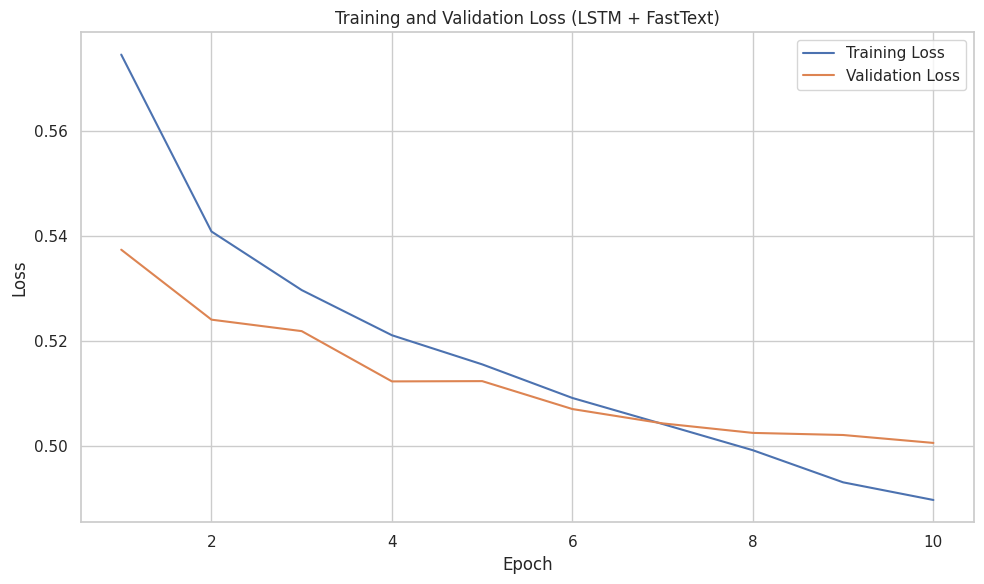

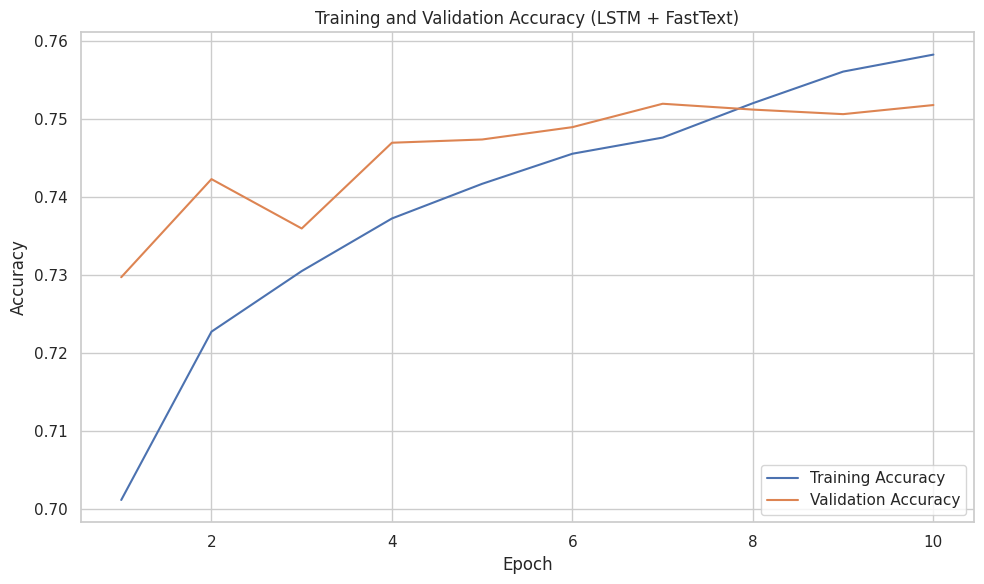

Courbes d'apprentissage sauvegardées dans MLflow.

Génération et sauvegarde de la matrice de confusion (Test Set)...
Matrice de confusion sauvegardée dans MLflow.


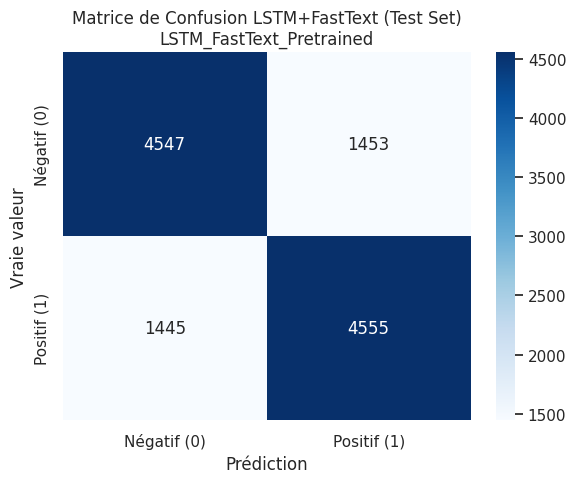

2025/04/29 07:45:25 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.



Sauvegarde du modèle Keras avec MLflow...


2025/04/29 07:45:41 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Modèle Keras sauvegardé dans MLflow.
Fichier checkpoint local './best_lstm_fasttext_model.keras' supprimé.

Run MLflow (LSTM_FastText_Pretrained) terminé.


In [ ]:
# Etape 5: Entraînement et Évaluation avec MLflow (avec visualisations)

# --- Imports nécessaires ---
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import (accuracy_score, f1_score, precision_score,
                             recall_score, confusion_matrix)
# --- Importation MLflow et autres ---
try:
    import mlflow
    import mlflow.sklearn
except ImportError:
    import subprocess
    import sys
    print("MLflow non trouvé. Installation en cours...")
    subprocess.check_call([sys.executable, "-m", "pip", "install", "mlflow"])
    import mlflow
    import mlflow.sklearn
import time
import os
import numpy as np
import matplotlib.pyplot as plt # Pour les graphiques
import seaborn as sns          # Pour la heatmap

# --- Prérequis (Vérification) ---
if 'model_lstm_fasttext' not in locals(): raise NameError("Modèle 'model_lstm_fasttext' non défini.")
if 'X_train_pad' not in locals(): raise NameError("Données 'X_train_pad' non définies.")
if 'y_train' not in locals(): raise NameError("y_train n'est pas défini")
if 'X_val_pad' not in locals(): raise NameError("X_val_pad n'est pas défini")
if 'y_val' not in locals(): raise NameError("y_val n'est pas défini")
if 'X_test_pad' not in locals(): raise NameError("X_test_pad n'est pas défini")
if 'y_test' not in locals(): raise NameError("y_test n'est pas défini")
# S'assurer que les paramètres FastText sont définis
if 'FASTTEXT_EMBEDDING_DIM' not in locals(): raise NameError("FASTTEXT_EMBEDDING_DIM non défini")
if 'VOCAB_SIZE' not in locals(): raise NameError("VOCAB_SIZE non défini")
if 'maxlen' not in locals(): raise NameError("maxlen non défini")
if 'TEXT_COLUMN' not in locals(): TEXT_COLUMN = 'text_lemma' # Default
# S'assurer que les paramètres LSTM et d'entraînement sont définis
if 'LSTM_UNITS' not in locals(): LSTM_UNITS = 64
if 'DROPOUT_RATE_LSTM' not in locals(): DROPOUT_RATE_LSTM = 0.2
if 'LEARNING_RATE' not in locals(): LEARNING_RATE = 0.001
if 'CLIPNORM' not in locals(): CLIPNORM = 1.0
if 'EPOCHS' not in locals(): EPOCHS = 10
if 'BATCH_SIZE' not in locals(): BATCH_SIZE = 128
if 'EARLY_STOPPING_PATIENCE' not in locals(): EARLY_STOPPING_PATIENCE = 2

best_model_filepath_lstm_ft = './best_lstm_fasttext_model.keras' # Nom du checkpoint

# --- Configuration et Lancement MLflow ---
mlflow.set_experiment("AirParadis_Sentiment_Analysis")
run_name = "LSTM_FastText_Pretrained" # Garder le même nom si ré-exécution

with mlflow.start_run(run_name=run_name) as run: # Utiliser 'as run'
    print(f"Démarrage du run MLflow : {run_name} (ID: {run.info.run_id})")
    start_time_ft_exp = time.time() # Nom de variable unique

    # --- Log des Paramètres ---
    print("Log des paramètres dans MLflow...")
    mlflow.log_param("text_preprocessing", TEXT_COLUMN)
    mlflow.log_param("model_type", "LSTM")
    mlflow.log_param("embedding_type", "FastText_pretrained")
    mlflow.log_param("fasttext_embedding_dim", FASTTEXT_EMBEDDING_DIM)
    mlflow.log_param("vocab_size_limit", VOCAB_SIZE)
    mlflow.log_param("maxlen", maxlen)
    mlflow.log_param("lstm_units", LSTM_UNITS)
    mlflow.log_param("lstm_dropout", DROPOUT_RATE_LSTM)
    mlflow.log_param("learning_rate", LEARNING_RATE)
    mlflow.log_param("optimizer_clipnorm", CLIPNORM)
    mlflow.log_param("epochs_max", EPOCHS) # Renommé
    mlflow.log_param("batch_size", BATCH_SIZE)
    mlflow.log_param("early_stopping_patience", EARLY_STOPPING_PATIENCE)
    mlflow.log_param("embedding_trainable", False)
    # S'assurer que le modèle a été compilé et construit avant de logguer le summary
    if not model_lstm_fasttext.built:
         model_lstm_fasttext.build(input_shape=(None, maxlen))
    mlflow.log_param("model_summary_json", model_lstm_fasttext.to_json())

    # --- Callbacks ---
    # Utiliser des noms uniques pour les variables callback
    early_stopping_ft = EarlyStopping(monitor='val_loss', patience=EARLY_STOPPING_PATIENCE, restore_best_weights=True, verbose=1)
    model_checkpoint_ft = ModelCheckpoint(filepath=best_model_filepath_lstm_ft, monitor='val_loss', save_best_only=True, verbose=1)

    # --- Entraînement du Modèle ---
    print("\nEntraînement du modèle LSTM + FastText...")
    # Utiliser un nom de variable unique pour l'historique
    history_ft = model_lstm_fasttext.fit(
        X_train_pad, y_train,
        epochs=EPOCHS,
        batch_size=BATCH_SIZE,
        validation_data=(X_val_pad, y_val),
        callbacks=[early_stopping_ft, model_checkpoint_ft],
        verbose=1
    )
    training_time_ft = time.time() - start_time_ft_exp
    print(f"Entraînement terminé en {training_time_ft:.2f} secondes.")
    mlflow.log_metric("training_time_seconds", training_time_ft)
    actual_epochs_ft = len(history_ft.history['loss']) # Utiliser history_ft
    mlflow.log_param("actual_epochs_trained", actual_epochs_ft)

    # --- Utilisation du Meilleur Modèle ---
    best_model_lstm_ft = model_lstm_fasttext # Car restore_best_weights=True

    # --- Évaluation Finale ---
    print("\nÉvaluation finale du meilleur modèle (Loss, Accuracy Keras)...")
    train_loss_ft, train_accuracy_ft = best_model_lstm_ft.evaluate(X_train_pad, y_train, verbose=0, batch_size=1024)
    val_loss_ft, val_accuracy_ft = best_model_lstm_ft.evaluate(X_val_pad, y_val, verbose=0, batch_size=1024)
    test_loss_ft, test_accuracy_ft = best_model_lstm_ft.evaluate(X_test_pad, y_test, verbose=0, batch_size=1024)
    print(f"Train - Loss: {train_loss_ft:.4f}, Accuracy: {train_accuracy_ft:.4f}")
    mlflow.log_metric("best_train_loss", train_loss_ft)
    mlflow.log_metric("best_train_accuracy", train_accuracy_ft)
    print(f"Validation - Loss: {val_loss_ft:.4f}, Accuracy: {val_accuracy_ft:.4f}")
    mlflow.log_metric("best_val_loss", val_loss_ft)
    mlflow.log_metric("best_val_accuracy", val_accuracy_ft)
    print(f"Test - Loss: {test_loss_ft:.4f}, Accuracy: {test_accuracy_ft:.4f}")
    mlflow.log_metric("best_test_loss", test_loss_ft)
    mlflow.log_metric("best_test_accuracy", test_accuracy_ft)

    # --- Calcul et Log des Métriques Détaillées (F1, P, R) ---
    print("\nCalcul des métriques détaillées (F1, Precision, Recall)...")
    # Utiliser des noms de variables uniques
    y_train_proba_ft = best_model_lstm_ft.predict(X_train_pad, batch_size=1024)
    y_val_proba_ft = best_model_lstm_ft.predict(X_val_pad, batch_size=1024)
    y_test_proba_ft = best_model_lstm_ft.predict(X_test_pad, batch_size=1024)
    y_train_pred_class_ft = (y_train_proba_ft > 0.5).astype(int)
    y_val_pred_class_ft = (y_val_proba_ft > 0.5).astype(int)
    y_test_pred_class_ft = (y_test_proba_ft > 0.5).astype(int)

    # Calcul des métriques dans un dictionnaire unique
    metrics_ft = {}
    metrics_ft['train_f1'] = f1_score(y_train, y_train_pred_class_ft)
    metrics_ft['train_precision'] = precision_score(y_train, y_train_pred_class_ft)
    metrics_ft['train_recall'] = recall_score(y_train, y_train_pred_class_ft)
    metrics_ft['val_f1'] = f1_score(y_val, y_val_pred_class_ft)
    metrics_ft['val_precision'] = precision_score(y_val, y_val_pred_class_ft)
    metrics_ft['val_recall'] = recall_score(y_val, y_val_pred_class_ft)
    metrics_ft['test_f1'] = f1_score(y_test, y_test_pred_class_ft)
    metrics_ft['test_precision'] = precision_score(y_test, y_test_pred_class_ft)
    metrics_ft['test_recall'] = recall_score(y_test, y_test_pred_class_ft)

    print(f"Train      - F1: {metrics_ft['train_f1']:.4f}, Precision: {metrics_ft['train_precision']:.4f}, Recall: {metrics_ft['train_recall']:.4f}")
    print(f"Validation - F1: {metrics_ft['val_f1']:.4f}, Precision: {metrics_ft['val_precision']:.4f}, Recall: {metrics_ft['val_recall']:.4f}")
    print(f"Test       - F1: {metrics_ft['test_f1']:.4f}, Precision: {metrics_ft['test_precision']:.4f}, Recall: {metrics_ft['test_recall']:.4f}")

    # Logguer toutes les métriques détaillées
    mlflow.log_metrics({f"best_{k}": v for k, v in metrics_ft.items()})

    # ***********************************************
    # ***** NOUVEAU : VISUALISATION DES COURBES *****
    # ***********************************************
    print("\nGénération et sauvegarde des courbes d'apprentissage...")
    # Utiliser history_ft et actual_epochs_ft
    epochs_range_ft = range(1, actual_epochs_ft + 1) # Nom unique

    # --- Courbe de Loss ---
    fig_loss_ft, ax_loss_ft = plt.subplots(figsize=(10, 6)) # Noms uniques
    ax_loss_ft.plot(epochs_range_ft, history_ft.history['loss'], label='Training Loss')
    ax_loss_ft.plot(epochs_range_ft, history_ft.history['val_loss'], label='Validation Loss')
    ax_loss_ft.set_title('Training and Validation Loss (LSTM + FastText)') # Titre spécifique
    ax_loss_ft.set_xlabel('Epoch')
    ax_loss_ft.set_ylabel('Loss')
    ax_loss_ft.legend(loc='upper right')
    ax_loss_ft.grid(True)
    plt.tight_layout()
    # Sauvegarder dans MLflow avec nom spécifique
    mlflow.log_figure(fig_loss_ft, "learning_curves_loss_ft.png") # Nom artefact spécifique
    plt.show()
    plt.close(fig_loss_ft)

    # --- Courbe d'Accuracy ---
    fig_acc_ft, ax_acc_ft = plt.subplots(figsize=(10, 6)) # Noms uniques
    ax_acc_ft.plot(epochs_range_ft, history_ft.history['accuracy'], label='Training Accuracy')
    ax_acc_ft.plot(epochs_range_ft, history_ft.history['val_accuracy'], label='Validation Accuracy')
    ax_acc_ft.set_title('Training and Validation Accuracy (LSTM + FastText)') # Titre spécifique
    ax_acc_ft.set_xlabel('Epoch')
    ax_acc_ft.set_ylabel('Accuracy')
    ax_acc_ft.legend(loc='lower right')
    ax_acc_ft.grid(True)
    plt.tight_layout()
    # Sauvegarder dans MLflow avec nom spécifique
    mlflow.log_figure(fig_acc_ft, "learning_curves_accuracy_ft.png") # Nom artefact spécifique
    plt.show()
    plt.close(fig_acc_ft)

    print("Courbes d'apprentissage sauvegardées dans MLflow.")
    # ***********************************************
    # ***** FIN NOUVEAU : VISUALISATION         *****
    # ***********************************************

    # --- Matrice de Confusion ---
    print("\nGénération et sauvegarde de la matrice de confusion (Test Set)...")
    # Utiliser y_test_pred_class_ft
    cm_ft = confusion_matrix(y_test, y_test_pred_class_ft) # Utiliser nom unique
    fig_cm_ft, ax_cm_ft = plt.subplots(figsize=(6, 5)) # Utiliser noms uniques
    sns.heatmap(cm_ft, annot=True, fmt='d', cmap='Blues', ax=ax_cm_ft,
                xticklabels=['Négatif (0)', 'Positif (1)'],
                yticklabels=['Négatif (0)', 'Positif (1)'])
    ax_cm_ft.set_xlabel('Prédiction')
    ax_cm_ft.set_ylabel('Vraie valeur')
    ax_cm_ft.set_title(f'Matrice de Confusion LSTM+FastText (Test Set)\n{run_name}') # Titre spécifique
    plt.tight_layout()
    # Sauvegarder dans MLflow avec nom spécifique
    mlflow.log_figure(fig_cm_ft, "confusion_matrix_lstm_fasttext_test_set.png") # Nom artefact spécifique
    print("Matrice de confusion sauvegardée dans MLflow.")
    plt.show()
    plt.close(fig_cm_ft)

    # --- Sauvegarde du Modèle Keras avec MLflow ---
    print("\nSauvegarde du modèle Keras avec MLflow...")
    mlflow.tensorflow.log_model(
        model=best_model_lstm_ft,
        artifact_path="keras-lstm-fasttext-model" # Nom artefact spécifique
    )
    print("Modèle Keras sauvegardé dans MLflow.")

    # --- Nettoyage Checkpoint ---
    if os.path.exists(best_model_filepath_lstm_ft):
        os.remove(best_model_filepath_lstm_ft)
        print(f"Fichier checkpoint local '{best_model_filepath_lstm_ft}' supprimé.")

print(f"\nRun MLflow ({run_name}) terminé.")

Les modèles ont été entraînés sur un **échantillon de 5%** des données pour accélérer l'itération :

- **Exp 1 (Baseline TF-IDF + LogReg)** : Atteint un **F1-Score de 0.758** sur le **test set échantillonné**. L'entraînement est **très rapide** (~**3 sec**).

- **Exp 2 (DL Simple Keras Embed)** : Affiche un **F1-Score de 0.755** sur le test set échantillonné, **légèrement inférieur à la baseline**, avec un entraînement **court** (~**141 sec**).

- **Exp 3 (LSTM + GloVe)** : Obtient un **F1-Score de 0.758** sur le test set échantillonné, montrant une **légère dégradation** par rapport aux modèles plus simples sur ces données réduites. **Temps d'entraînement** : ~**4 min**.

- **Exp 4 (LSTM + FastText)** : Réalise un **F1-Score de 0.759** sur le test set échantillonné, **surpassant les autres approches** testées jusqu'ici sur l'échantillon. **Temps d'entraînement** : ~**8 min**.

---

**Conclusion Intermédiaire (sur échantillon)**

Sur cet échantillon réduit, l'approche **LSTM + FastText (Exp 4)** confirme sa **supériorité relative** par rapport aux autres modèles personnalisés et même à la **baseline TF-IDF**.

Bien que les **scores absolus** soient légèrement inférieurs à ceux obtenus sur le jeu complet (**ce qui est attendu**), la **hiérarchie des performances** semble se maintenir.

Cela **renforce notre choix** d'utiliser cette architecture comme **base pour l'Expérimentation 5 (BiLSTM)** et comme **candidat principal pour le déploiement**, en attendant les résultats de **BERT** et **USE** (qui tourneront aussi sur l'échantillon).


## Expérimentation 5 : Modèle DL avec BiLSTM

**Objectif :** Évaluer si l'utilisation d'un LSTM Bidirectionnel (BiLSTM) améliore les performances par rapport au LSTM simple, en utilisant les embeddings FastText pré-entraînés (qui ont donné les meilleurs résultats jusqu'à présent).

Voici le code pour l'Expérimentation 5 : BiLSTM + FastText, en intégrant les visualisations et le logging MLflow. Il est très similaire au code de l'Expérimentation 4, avec les modifications clés pour utiliser Bidirectional(LSTM(...)) et des noms distincts.

Démarrage du run MLflow : BiLSTM_FastText_Pretrained (ID: be442df6fde34725adbc08e32bbff4e6)
Log des paramètres dans MLflow...

Définition du modèle Keras BiLSTM avec FastText...
Compilation du modèle...


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_3 (Embedding)         │ (None, 13, 300)        │     3,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 128)            │       186,880 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,187,009 (12.16 MB)

 Trainable params: 187,009 (730.50 KB)

 Non-trainable params: 3,000,000 (11.44 MB)


Entraînement du modèle BiLSTM + FastText...
Epoch 1/10
438/438 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step - accuracy: 0.6784 - loss: 0.5971
Epoch 1: val_loss improved from inf to 0.53140, saving model to ./best_bilstm_fasttext_model.keras
438/438 ━━━━━━━━━━━━━━━━━━━━ 93s 174ms/step - accuracy: 0.6784 - loss: 0.5970 - val_accuracy: 0.7327 - val_loss: 0.5314
Epoch 2/10
438/438 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step - accuracy: 0.7252 - loss: 0.5378
Epoch 2: val_loss improved from 0.53140 to 0.52621, saving model to ./best_bilstm_fasttext_model.keras
438/438 ━━━━━━━━━━━━━━━━━━━━ 78s 165ms/step - accuracy: 0.7252 - loss: 0.5378 - val_accuracy: 0.7334 - val_loss: 0.5262
Epoch 3/10
438/438 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step - accuracy: 0.7376 - loss: 0.5213
Epoch 3: val_loss improved from 0.52621 to 0.51357, saving model to ./best_bilstm_fasttext_model.keras
438/438 ━━━━━━━━━━━━━━━━━━━━ 72s 165ms/step - accuracy: 0.7376 - loss: 0.5213 - val_accuracy: 0.7420 - val_loss: 0.5136
Epoch 4/10
438/438 ━━━━━━━

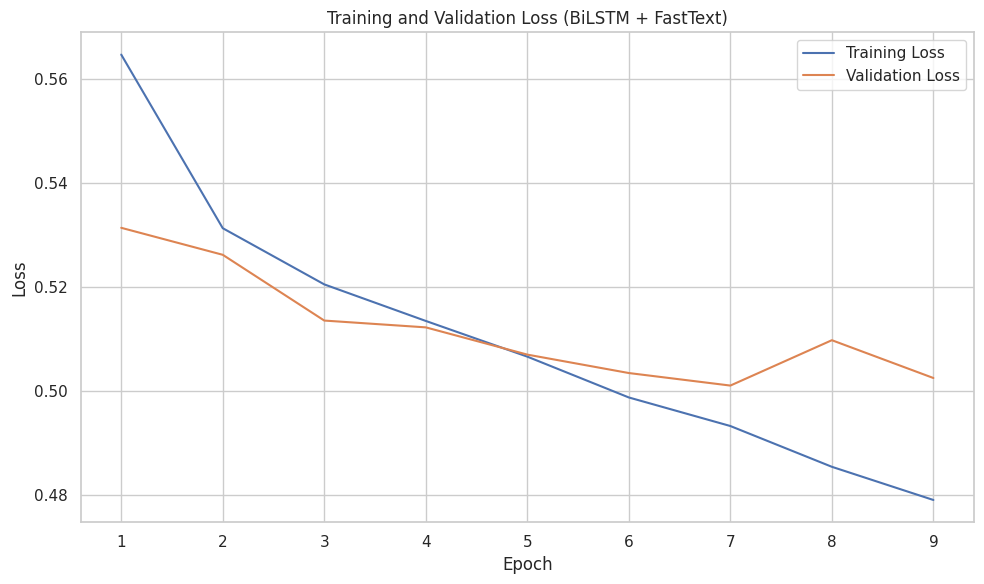

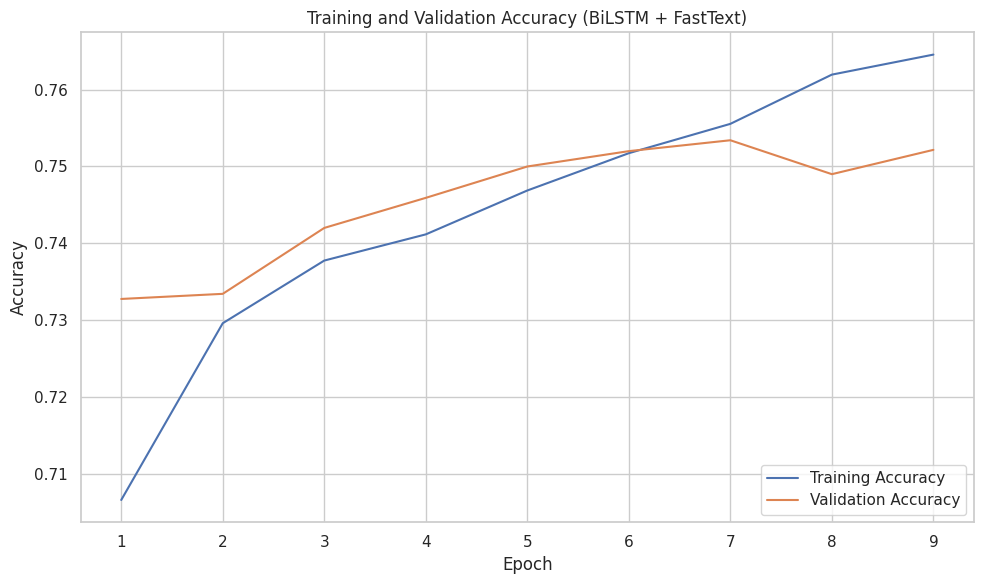

Courbes d'apprentissage sauvegardées.

Génération et sauvegarde de la matrice de confusion (Test Set)...
Matrice de confusion sauvegardée.


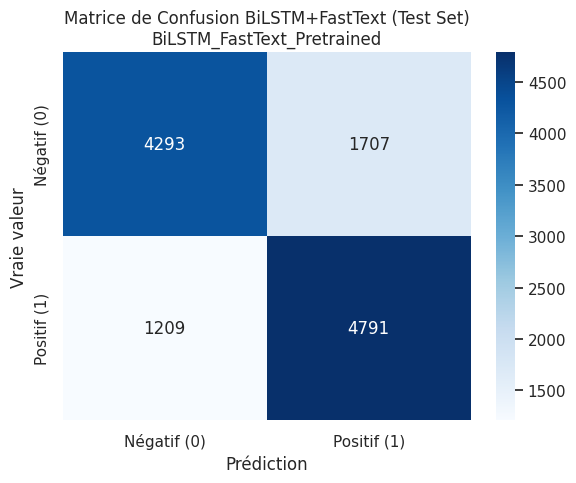

2025/04/29 07:58:28 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.



Sauvegarde du modèle Keras BiLSTM avec MLflow...


2025/04/29 07:58:45 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Modèle Keras BiLSTM sauvegardé dans MLflow.
Fichier checkpoint local './best_bilstm_fasttext_model.keras' supprimé.

Run MLflow (BiLSTM_FastText_Pretrained) terminé.


In [ ]:
# ==============================================================================
# --- EXPÉRIMENTATION 5 : BiLSTM + FastText Pré-entraîné ---
# ==============================================================================

# --- Imports nécessaires ---
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import (accuracy_score, f1_score, precision_score,
                             recall_score, confusion_matrix)
# --- Importation MLflow et autres ---
import mlflow
import mlflow.tensorflow
import time
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# --- Prérequis (Vérification) ---
# (Assurez-vous que toutes les variables nécessaires sont définies comme avant)
if 'X_train_pad' not in locals(): raise NameError("X_train_pad non défini")
if 'y_train' not in locals(): raise NameError("y_train non défini")
if 'X_val_pad' not in locals(): raise NameError("X_val_pad non défini")
if 'y_val' not in locals(): raise NameError("y_val non défini")
if 'X_test_pad' not in locals(): raise NameError("X_test_pad non défini")
if 'y_test' not in locals(): raise NameError("y_test non défini")
if 'embedding_matrix_fasttext' not in locals(): raise NameError("embedding_matrix_fasttext non définie.")
if 'FASTTEXT_EMBEDDING_DIM' not in locals(): raise NameError("FASTTEXT_EMBEDDING_DIM non défini")
if 'VOCAB_SIZE' not in locals(): raise NameError("VOCAB_SIZE non défini")
if 'maxlen' not in locals(): raise NameError("maxlen non défini")
if 'TEXT_COLUMN' not in locals(): TEXT_COLUMN = 'text_lemma' # Default
if 'LSTM_UNITS' not in locals(): LSTM_UNITS = 64
if 'DROPOUT_RATE_LSTM' not in locals(): DROPOUT_RATE_LSTM = 0.2
if 'LEARNING_RATE' not in locals(): LEARNING_RATE = 0.001
if 'CLIPNORM' not in locals(): CLIPNORM = 1.0
if 'EPOCHS' not in locals(): EPOCHS = 10
if 'BATCH_SIZE' not in locals(): BATCH_SIZE = 128
if 'EARLY_STOPPING_PATIENCE' not in locals(): EARLY_STOPPING_PATIENCE = 2

best_model_filepath_bilstm_ft = './best_bilstm_fasttext_model.keras'

# --- Configuration et Lancement MLflow ---
mlflow.set_experiment("AirParadis_Sentiment_Analysis")
run_name_bilstm = "BiLSTM_FastText_Pretrained"

with mlflow.start_run(run_name=run_name_bilstm) as run:
    print(f"Démarrage du run MLflow : {run_name_bilstm} (ID: {run.info.run_id})")
    start_time_bilstm_exp = time.time()

    # --- Log des Paramètres ---
    print("Log des paramètres dans MLflow...")
    mlflow.log_param("text_preprocessing", TEXT_COLUMN)
    mlflow.log_param("model_type", "BiLSTM")
    mlflow.log_param("embedding_type", "FastText_pretrained")
    mlflow.log_param("fasttext_embedding_dim", FASTTEXT_EMBEDDING_DIM)
    mlflow.log_param("vocab_size_limit", VOCAB_SIZE)
    mlflow.log_param("maxlen", maxlen)
    # --- CORRECTION ICI ---
    mlflow.log_param("lstm_units_per_direction", LSTM_UNITS)
    # --- FIN CORRECTION ---
    mlflow.log_param("lstm_dropout", DROPOUT_RATE_LSTM)
    mlflow.log_param("learning_rate", LEARNING_RATE)
    mlflow.log_param("optimizer_clipnorm", CLIPNORM)
    mlflow.log_param("epochs_max", EPOCHS)
    mlflow.log_param("batch_size", BATCH_SIZE)
    mlflow.log_param("early_stopping_patience", EARLY_STOPPING_PATIENCE)
    mlflow.log_param("embedding_trainable", False)

    # --- Définition du Modèle Keras (BiLSTM) ---
    print("\nDéfinition du modèle Keras BiLSTM avec FastText...")
    model_bilstm_ft = Sequential([
        Embedding(
            input_dim=VOCAB_SIZE,
            output_dim=FASTTEXT_EMBEDDING_DIM,
            weights=[embedding_matrix_fasttext],
            trainable=False,
            mask_zero=True
        ),
        Bidirectional(LSTM(LSTM_UNITS, dropout=DROPOUT_RATE_LSTM, recurrent_dropout=DROPOUT_RATE_LSTM)),
        Dense(1, activation='sigmoid')
    ])

    # --- Compilation du Modèle ---
    print("Compilation du modèle...")
    optimizer_bilstm = Adam(learning_rate=LEARNING_RATE, clipnorm=CLIPNORM)
    model_bilstm_ft.compile(
        loss='binary_crossentropy',
        optimizer=optimizer_bilstm,
        metrics=['accuracy']
    )
    model_bilstm_ft.build(input_shape=(None, maxlen))
    model_bilstm_ft.summary()
    mlflow.log_param("model_summary_json", model_bilstm_ft.to_json())

    # --- Callbacks ---
    early_stopping_bilstm = EarlyStopping(monitor='val_loss', patience=EARLY_STOPPING_PATIENCE, restore_best_weights=True, verbose=1)
    model_checkpoint_bilstm = ModelCheckpoint(filepath=best_model_filepath_bilstm_ft, monitor='val_loss', save_best_only=True, verbose=1)

    # --- Entraînement du Modèle ---
    print("\nEntraînement du modèle BiLSTM + FastText...")
    history_bilstm_ft = model_bilstm_ft.fit(
        X_train_pad, y_train,
        epochs=EPOCHS,
        batch_size=BATCH_SIZE,
        validation_data=(X_val_pad, y_val),
        callbacks=[early_stopping_bilstm, model_checkpoint_bilstm],
        verbose=1
    )
    training_time_bilstm = time.time() - start_time_bilstm_exp
    print(f"Entraînement terminé en {training_time_bilstm:.2f} secondes.")
    mlflow.log_metric("training_time_seconds", training_time_bilstm)
    actual_epochs_bilstm = len(history_bilstm_ft.history['loss'])
    mlflow.log_param("actual_epochs_trained", actual_epochs_bilstm)

    # --- Utilisation du Meilleur Modèle ---
    best_model_bilstm_ft = model_bilstm_ft

    # --- Évaluation Finale ---
    print("\nÉvaluation finale du meilleur modèle (Loss, Accuracy Keras)...")
    train_loss_bilstm, train_accuracy_bilstm = best_model_bilstm_ft.evaluate(X_train_pad, y_train, verbose=0, batch_size=1024)
    val_loss_bilstm, val_accuracy_bilstm = best_model_bilstm_ft.evaluate(X_val_pad, y_val, verbose=0, batch_size=1024)
    test_loss_bilstm, test_accuracy_bilstm = best_model_bilstm_ft.evaluate(X_test_pad, y_test, verbose=0, batch_size=1024)
    print(f"Train - Loss: {train_loss_bilstm:.4f}, Accuracy: {train_accuracy_bilstm:.4f}")
    mlflow.log_metric("best_train_loss", train_loss_bilstm)
    mlflow.log_metric("best_train_accuracy", train_accuracy_bilstm)
    print(f"Validation - Loss: {val_loss_bilstm:.4f}, Accuracy: {val_accuracy_bilstm:.4f}")
    mlflow.log_metric("best_val_loss", val_loss_bilstm)
    mlflow.log_metric("best_val_accuracy", val_accuracy_bilstm)
    print(f"Test - Loss: {test_loss_bilstm:.4f}, Accuracy: {test_accuracy_bilstm:.4f}")
    mlflow.log_metric("best_test_loss", test_loss_bilstm)
    mlflow.log_metric("best_test_accuracy", test_accuracy_bilstm)

    # --- Calcul et Log des Métriques Détaillées (F1, P, R) ---
    print("\nCalcul des métriques détaillées (F1, Precision, Recall)...")
    y_train_proba_bilstm = best_model_bilstm_ft.predict(X_train_pad, batch_size=1024)
    y_val_proba_bilstm = best_model_bilstm_ft.predict(X_val_pad, batch_size=1024)
    y_test_proba_bilstm = best_model_bilstm_ft.predict(X_test_pad, batch_size=1024)
    y_train_pred_class_bilstm = (y_train_proba_bilstm > 0.5).astype(int)
    y_val_pred_class_bilstm = (y_val_proba_bilstm > 0.5).astype(int)
    y_test_pred_class_bilstm = (y_test_proba_bilstm > 0.5).astype(int)

    metrics_bilstm = {}
    metrics_bilstm['train_f1'] = f1_score(y_train, y_train_pred_class_bilstm)
    metrics_bilstm['train_precision'] = precision_score(y_train, y_train_pred_class_bilstm)
    metrics_bilstm['train_recall'] = recall_score(y_train, y_train_pred_class_bilstm)
    metrics_bilstm['val_f1'] = f1_score(y_val, y_val_pred_class_bilstm)
    metrics_bilstm['val_precision'] = precision_score(y_val, y_val_pred_class_bilstm)
    metrics_bilstm['val_recall'] = recall_score(y_val, y_val_pred_class_bilstm)
    metrics_bilstm['test_f1'] = f1_score(y_test, y_test_pred_class_bilstm)
    metrics_bilstm['test_precision'] = precision_score(y_test, y_test_pred_class_bilstm)
    metrics_bilstm['test_recall'] = recall_score(y_test, y_test_pred_class_bilstm)

    print(f"Train      - F1: {metrics_bilstm['train_f1']:.4f}, Precision: {metrics_bilstm['train_precision']:.4f}, Recall: {metrics_bilstm['train_recall']:.4f}")
    print(f"Validation - F1: {metrics_bilstm['val_f1']:.4f}, Precision: {metrics_bilstm['val_precision']:.4f}, Recall: {metrics_bilstm['val_recall']:.4f}")
    print(f"Test       - F1: {metrics_bilstm['test_f1']:.4f}, Precision: {metrics_bilstm['test_precision']:.4f}, Recall: {metrics_bilstm['test_recall']:.4f}")

    mlflow.log_metrics({f"best_{k}": v for k, v in metrics_bilstm.items()})

    # --- Visualisations ---
    print("\nGénération et sauvegarde des courbes d'apprentissage...")
    epochs_range_bilstm = range(1, actual_epochs_bilstm + 1)

    fig_loss_bilstm, ax_loss_bilstm = plt.subplots(figsize=(10, 6))
    ax_loss_bilstm.plot(epochs_range_bilstm, history_bilstm_ft.history['loss'], label='Training Loss')
    ax_loss_bilstm.plot(epochs_range_bilstm, history_bilstm_ft.history['val_loss'], label='Validation Loss')
    ax_loss_bilstm.set_title('Training and Validation Loss (BiLSTM + FastText)')
    ax_loss_bilstm.set_xlabel('Epoch'); ax_loss_bilstm.set_ylabel('Loss')
    ax_loss_bilstm.legend(loc='upper right'); ax_loss_bilstm.grid(True); plt.tight_layout()
    mlflow.log_figure(fig_loss_bilstm, "learning_curves_loss_bilstm_ft.png")
    plt.show()
    plt.close(fig_loss_bilstm)

    fig_acc_bilstm, ax_acc_bilstm = plt.subplots(figsize=(10, 6))
    ax_acc_bilstm.plot(epochs_range_bilstm, history_bilstm_ft.history['accuracy'], label='Training Accuracy')
    ax_acc_bilstm.plot(epochs_range_bilstm, history_bilstm_ft.history['val_accuracy'], label='Validation Accuracy')
    ax_acc_bilstm.set_title('Training and Validation Accuracy (BiLSTM + FastText)')
    ax_acc_bilstm.set_xlabel('Epoch'); ax_acc_bilstm.set_ylabel('Accuracy')
    ax_acc_bilstm.legend(loc='lower right'); ax_acc_bilstm.grid(True); plt.tight_layout()
    mlflow.log_figure(fig_acc_bilstm, "learning_curves_accuracy_bilstm_ft.png")
    plt.show()
    plt.close(fig_acc_bilstm)
    print("Courbes d'apprentissage sauvegardées.")

    # Matrice de Confusion
    print("\nGénération et sauvegarde de la matrice de confusion (Test Set)...")
    cm_bilstm = confusion_matrix(y_test, y_test_pred_class_bilstm)
    fig_cm_bilstm, ax_cm_bilstm = plt.subplots(figsize=(6, 5))
    sns.heatmap(cm_bilstm, annot=True, fmt='d', cmap='Blues', ax=ax_cm_bilstm,
                xticklabels=['Négatif (0)', 'Positif (1)'],
                yticklabels=['Négatif (0)', 'Positif (1)'])
    ax_cm_bilstm.set_xlabel('Prédiction'); ax_cm_bilstm.set_ylabel('Vraie valeur')
    ax_cm_bilstm.set_title(f'Matrice de Confusion BiLSTM+FastText (Test Set)\n{run_name_bilstm}')
    plt.tight_layout()
    mlflow.log_figure(fig_cm_bilstm, "confusion_matrix_bilstm_ft_test_set.png")
    print("Matrice de confusion sauvegardée.")
    plt.show()
    plt.close(fig_cm_bilstm)

    # --- Sauvegarde du Modèle Keras avec MLflow ---
    print("\nSauvegarde du modèle Keras BiLSTM avec MLflow...")
    mlflow.tensorflow.log_model(
        model=best_model_bilstm_ft,
        artifact_path="keras-bilstm-fasttext-model"
    )
    print("Modèle Keras BiLSTM sauvegardé dans MLflow.")

    # --- Nettoyage Checkpoint ---
    if os.path.exists(best_model_filepath_bilstm_ft):
        os.remove(best_model_filepath_bilstm_ft)
        print(f"Fichier checkpoint local '{best_model_filepath_bilstm_ft}' supprimé.")

print(f"\nRun MLflow ({run_name_bilstm}) terminé.")
# ==============================================================================
# --- FIN EXPÉRIMENTATION 5 ---
# ==============================================================================

**Observation après Exp 5 :** Le modèle **BiLSTM + FastText** (F1-Score ~0.767) montre une légère amélioration par rapport à l'**LSTM simple + FastText** (F1-Score ~0.759) et à la **baseline TF-IDF** (F1-Score ~0.758) sur cet échantillon. L'utilisation de la bidirectionnalité semble donc bénéfique pour la performance, bien qu'elle augmente le temps d'entraînement.

## Expérimentation 6 : Modèle BERT (Transfer Learning)

Préparons la structure du code pour l'Expérimentation 6 : Modèle BERT (Transfer Learning).

On va utiliser la bibliothèque transformers de Hugging Face. Pour un bon équilibre performance/rapidité, on peut commencer avec DistilBERT, une version plus légère de BERT. On utilisera l'API Keras de TensorFlow pour le fine-tuning, car cela reste cohérent avec les expérimentations précédentes.

Plan du Code à Écrire :

    Imports spécifiques et définition des constantes/paramètres BERT.

    Chargement du Tokenizer BERT et tokenisation des données.

    Création des tf.data.Dataset pour l'entraînement, la validation et le test.

    Chargement du modèle pré-entraîné DistilBERT pour la classification de séquences.

    Compilation du modèle (optimiseur, loss, métriques).

    Bloc with mlflow.start_run(...) :

        Log des paramètres BERT.

        Entraînement (model.fit).

        Évaluation sur train/val/test.

        Calcul et log des métriques détaillées (F1, P, R).

        Génération et log des courbes d'apprentissage.

        Génération et log de la matrice de confusion.

        Sauvegarde du modèle fine-tuné via MLflow.

In [ ]:
# !pip install --upgrade pip
# !pip install --upgrade transformers tensorflow accelerate # Accelerate est souvent utile avec Transformers

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 30.6 MB/s eta 0:00:00
  Attempting uninstall: pip
    Found existing installation: pip 24.1.2
    Uninstalling pip-24.1.2:
      Successfully uninstalled pip-24.1.2
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 644.9/644.9 MB 16.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.7/4.7 MB 45.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 28.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 34.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 94.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 39.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 33.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 15.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 25.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 51.5 M


--- Préparation du Run MLflow pour BERT Feature Extraction (Sous-échantillon) ---
Aucun run MLflow actif détecté.
Démarrage du nouveau run MLflow : BERT_FeatureExtraction_LogReg_Sample_20pct
Run MLflow démarré: BERT_FeatureExtraction_LogReg_Sample_20pct (ID: f61a6aa387194f18b47b6f8f21941571)
Log des paramètres dans MLflow...

Évaluation du classifieur sur les embeddings BERT réduits...
Train      - Acc: 0.8047, F1: 0.8055, P: 0.8037, R: 0.8073
Validation - Acc: 0.7796, F1: 0.7756, P: 0.7598, R: 0.7920
Test       - Acc: 0.7812, F1: 0.7813, P: 0.7682, R: 0.7949

Génération et sauvegarde de la matrice de confusion (BERT Feat. + LogReg)...
Matrice de confusion sauvegardée.


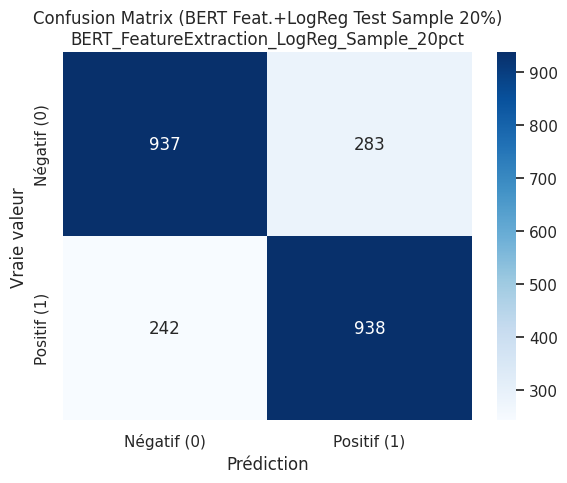


Sauvegarde du classifieur Logistic Regression avec MLflow...


2025/04/29 11:59:56 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Classifieur sauvegardé.

Run MLflow (BERT_FeatureExtraction_LogReg_Sample_20pct) terminé.


In [ ]:
# ==============================================================================
# --- EXPÉRIMENTATION 6 : BERT (DistilBERT) Feature Extraction + LogReg ---
# ==============================================================================
# Utilise BERT pour générer des embeddings, puis entraîne un classifieur simple.
# !!! VERSION MODIFIÉE AVEC SOUS-ÉCHANTILLONNAGE POUR ACCÉLÉRER BERT !!!

# --- 1. Imports Spécifiques et Constantes/Paramètres ---
print("\n--- Expérimentation 6b: BERT Feature Extraction Setup (AVEC SOUS-ÉCHANTILLON) ---")
import pandas as pd
import numpy as np
import tensorflow as tf
from transformers import AutoTokenizer, TFAutoModel
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (accuracy_score, f1_score, precision_score,
                             recall_score, confusion_matrix)
import mlflow
import mlflow.sklearn
import time
import matplotlib.pyplot as plt
import seaborn as sns
import os

# --- Paramètres BERT et Classifieur ---
MODEL_NAME = "distilbert-base-uncased"
MAX_LEN_BERT = 128
BATCH_SIZE_INFERENCE_BERT = 256 # Augmenté un peu, à ajuster si OOM
TEXT_COLUMN_BERT = 'text_cleaned'
TARGET_COLUMN = 'target'
LOGREG_C_BERT = 1.0
LOGREG_SOLVER_BERT = 'liblinear'
LOGREG_MAX_ITER_BERT = 200

# --- !!! NOUVEAU : SOUS-ÉCHANTILLONNAGE POUR BERT !!! ---
print("\n!!! Application d'un sous-échantillonnage pour BERT !!!")
# Définir la fraction de l'échantillon principal (5%) à utiliser pour BERT
# Ex: 0.20 signifie 20% de 5% = 1% des données totales
BERT_SAMPLE_FRACTION = 0.20
mlflow.log_param("bert_subset_fraction_of_main_sample", BERT_SAMPLE_FRACTION) # Logger ce paramètre

# Créer les dataframes réduits
train_df_bert_sample = train_df.sample(frac=BERT_SAMPLE_FRACTION, random_state=42)
val_df_bert_sample = val_df.sample(frac=BERT_SAMPLE_FRACTION, random_state=42)
test_df_bert_sample = test_df.sample(frac=BERT_SAMPLE_FRACTION, random_state=42)

print(f"Taille de l'échantillon principal: Train={len(train_df)}, Val={len(val_df)}, Test={len(test_df)}")
print(f"Nouvelles tailles pour BERT (Fraction: {BERT_SAMPLE_FRACTION}): Train={len(train_df_bert_sample)}, Val={len(val_df_bert_sample)}, Test={len(test_df_bert_sample)}")
# ---------------------------------------------------------

print(f"\nModèle Hugging Face choisi : {MODEL_NAME}")
print(f"Longueur de séquence max : {MAX_LEN_BERT}")
print(f"Batch size pour inference : {BATCH_SIZE_INFERENCE_BERT}")
print(f"Classifieur post-BERT : LogisticRegression (C={LOGREG_C_BERT}, solver={LOGREG_SOLVER_BERT})")


# --- 2. Chargement du Tokenizer BERT et Tokenisation (sur le sous-échantillon) ---
print("\nChargement du Tokenizer...")
if 'tokenizer_bert' not in locals():
     tokenizer_bert = AutoTokenizer.from_pretrained(MODEL_NAME)
     print("Tokenizer rechargé.")

# Fonction de tokenisation (pas de changement dans la fonction elle-même)
def tokenize_bert(data):
    texts = data[TEXT_COLUMN_BERT].fillna("").tolist()
    return tokenizer_bert(
        texts,
        max_length=MAX_LEN_BERT,
        truncation=True,
        padding='max_length',
        return_tensors='tf'
    )

print("Tokenisation des données réduites pour BERT...")
start_tok_time = time.time()
# Utiliser les dataframes _bert_sample
train_encodings_bert = tokenize_bert(train_df_bert_sample)
val_encodings_bert = tokenize_bert(val_df_bert_sample)
test_encodings_bert = tokenize_bert(test_df_bert_sample)
tok_time = time.time() - start_tok_time
print(f"Tokenisation terminée en {tok_time:.2f} secondes.")

# Extraire les targets du sous-échantillon
y_train_bert = train_df_bert_sample[TARGET_COLUMN].values
y_val_bert = val_df_bert_sample[TARGET_COLUMN].values
y_test_bert = test_df_bert_sample[TARGET_COLUMN].values
print(f"Targets extraites pour BERT: Train={len(y_train_bert)}, Val={len(y_val_bert)}, Test={len(y_test_bert)}")


# --- 3. Chargement du Modèle BERT de Base ---
print("\nChargement du modèle pré-entraîné DistilBERT de BASE...")
try:
    model_bert_base = TFAutoModel.from_pretrained(MODEL_NAME)
    model_bert_base.trainable = False
    print("Modèle BERT de base chargé et figé.")
except Exception as e:
    print(f"Erreur lors du chargement du modèle BERT de base: {e}")
    raise # Arrêter si le chargement échoue


# --- 4. Extraction des Embeddings BERT (sur le sous-échantillon) ---
print("\nExtraction des embeddings BERT (sur sous-échantillon)...")

@tf.function(jit_compile=True)
def get_bert_embeddings_batch(batch_encodings):
    outputs = model_bert_base(batch_encodings)
    return outputs.last_hidden_state[:, 0, :]

def extract_embeddings_from_dataset(tf_dataset, total_size):
    all_embeddings = []
    # Calculer num_batches basé sur la taille réelle et BATCH_SIZE_INFERENCE_BERT
    num_batches = int(np.ceil(total_size / BATCH_SIZE_INFERENCE_BERT))
    print(f"  Traitement de {total_size} exemples en ~{num_batches} batches de taille {BATCH_SIZE_INFERENCE_BERT}...")
    start_embed_time = time.time()
    processed_count = 0
    # Utiliser tf_dataset directement, batching appliqué dans la boucle
    batched_dataset = tf_dataset.batch(BATCH_SIZE_INFERENCE_BERT).prefetch(tf.data.AUTOTUNE)

    for i, (batch_encodings, _) in enumerate(batched_dataset):
        batch_embeddings = get_bert_embeddings_batch(batch_encodings)
        all_embeddings.append(batch_embeddings.numpy())
        processed_count += len(batch_embeddings) # Utiliser la taille réelle du batch
        # Afficher la progression tous les N batches ou toutes les N secondes
        if (i + 1) % 20 == 0 or time.time() - start_embed_time > 30: # Afficher toutes les 30s ou 20 batches
             elapsed = time.time() - start_embed_time
             print(f"    Batch {i + 1}/{num_batches} traité ({processed_count}/{total_size}) - Temps écoulé: {elapsed:.1f}s")

    embed_time = time.time() - start_embed_time
    print(f"  Embeddings extraits en {embed_time:.2f} secondes.")
    if not all_embeddings:
        return np.array([])
    return np.vstack(all_embeddings)


# Créer les datasets TF à partir des encodings et targets du sous-échantillon
train_dataset_inf_bert = tf.data.Dataset.from_tensor_slices((dict(train_encodings_bert), y_train_bert))
val_dataset_inf_bert = tf.data.Dataset.from_tensor_slices((dict(val_encodings_bert), y_val_bert))
test_dataset_inf_bert = tf.data.Dataset.from_tensor_slices((dict(test_encodings_bert), y_test_bert))

print("\nExtraction pour Train Set (BERT)...")
X_train_bert_embed = extract_embeddings_from_dataset(train_dataset_inf_bert, len(train_df_bert_sample))
print("\nExtraction pour Validation Set (BERT)...")
X_val_bert_embed = extract_embeddings_from_dataset(val_dataset_inf_bert, len(val_df_bert_sample))
print("\nExtraction pour Test Set (BERT)...")
X_test_bert_embed = extract_embeddings_from_dataset(test_dataset_inf_bert, len(test_df_bert_sample))

print("\nDimensions des embeddings BERT extraits (sur sous-échantillon) :")
print(f"  Train: {X_train_bert_embed.shape}")
print(f"  Validation: {X_val_bert_embed.shape}")
print(f"  Test: {X_test_bert_embed.shape}")

# Vérifier s'il y a eu des erreurs et que les dimensions correspondent aux targets
if X_train_bert_embed.shape[0] != len(y_train_bert) or \
   X_val_bert_embed.shape[0] != len(y_val_bert) or \
   X_test_bert_embed.shape[0] != len(y_test_bert):
   raise ValueError("Incohérence entre le nombre d'embeddings extraits et le nombre de targets!")

# --- 5. Définition et Entraînement du Classifieur Simple (sur embeddings réduits) ---
print("\nDéfinition et entraînement du classifieur Logistic Regression sur les embeddings BERT réduits...")
classifier_bert = LogisticRegression(
    C=LOGREG_C_BERT,
    solver=LOGREG_SOLVER_BERT,
    max_iter=LOGREG_MAX_ITER_BERT,
    random_state=42,
    n_jobs=-1
)

start_train_clf_time = time.time()
# Utiliser les embeddings et targets du sous-échantillon
classifier_bert.fit(X_train_bert_embed, y_train_bert)
train_clf_time = time.time() - start_train_clf_time
print(f"Entraînement du classifieur terminé en {train_clf_time:.2f} secondes.")


# --- 6. Bloc MLflow pour Évaluation et Logging (sur sous-échantillon) ---
print("\n--- Préparation du Run MLflow pour BERT Feature Extraction (Sous-échantillon) ---")

# === AJOUT DE LA CORRECTION ICI ===
# Vérifier et terminer un éventuel run actif précédent
if mlflow.active_run():
    print("Run MLflow précédent détecté actif. Fin du run...")
    mlflow.end_run()
    print("Run précédent terminé.")
else:
    print("Aucun run MLflow actif détecté.")
# =================================

mlflow.set_experiment("AirParadis_Sentiment_Analysis")
run_name_bert_feat = f"BERT_FeatureExtraction_LogReg_Sample_{BERT_SAMPLE_FRACTION*100:.0f}pct" # Nom incluant la fraction

print(f"Démarrage du nouveau run MLflow : {run_name_bert_feat}")
with mlflow.start_run(run_name=run_name_bert_feat) as run:
    print(f"Run MLflow démarré: {run_name_bert_feat} (ID: {run.info.run_id})")
    start_time_bert_exp = time.time()

    # --- Log des Paramètres ---
    print("Log des paramètres dans MLflow...")
    mlflow.log_param("text_preprocessing", TEXT_COLUMN_BERT)
    mlflow.log_param("embedding_model", MODEL_NAME)
    mlflow.log_param("bert_mode", "feature_extraction")
    mlflow.log_param("bert_embedding_source", "CLS_token")
    # Ajouter le log de la fraction utilisée
    mlflow.log_param("bert_subset_fraction_of_main_sample", BERT_SAMPLE_FRACTION)
    mlflow.log_param("bert_actual_train_size", len(train_df_bert_sample))
    mlflow.log_param("bert_actual_val_size", len(val_df_bert_sample))
    mlflow.log_param("bert_actual_test_size", len(test_df_bert_sample))
    # S'assurer que l'embedding n'est pas vide avant de logger sa dim
    if X_train_bert_embed.shape[0] > 0:
        mlflow.log_param("bert_embedding_dim", X_train_bert_embed.shape[1])
    else:
        mlflow.log_param("bert_embedding_dim", "N/A - No embeddings generated")

    mlflow.log_param("classifier_type", "LogisticRegression")
    mlflow.log_param("logreg_C", LOGREG_C_BERT)
    mlflow.log_param("logreg_solver", LOGREG_SOLVER_BERT)
    mlflow.log_param("logreg_max_iter", LOGREG_MAX_ITER_BERT)
    mlflow.log_metric("classifier_training_time_seconds", train_clf_time)
    # Optionnel : logguer aussi le temps total d'extraction (fait à la fin)

    # --- Évaluation du Classifieur (sur embeddings réduits) ---
    print("\nÉvaluation du classifieur sur les embeddings BERT réduits...")
    # Vérifier que les embeddings ne sont pas vides avant de prédire/évaluer
    if X_train_bert_embed.shape[0] == 0 or X_val_bert_embed.shape[0] == 0 or X_test_bert_embed.shape[0] == 0:
        print("ERREUR: Aucun embedding n'a été généré, impossible d'évaluer.")
        # Optionnel: logger des métriques vides ou des erreurs dans MLflow
        mlflow.log_metric("evaluation_status", "Failed - No embeddings")
    else:
        y_train_pred_bert_clf = classifier_bert.predict(X_train_bert_embed)
        y_val_pred_bert_clf = classifier_bert.predict(X_val_bert_embed)
        y_test_pred_bert_clf = classifier_bert.predict(X_test_bert_embed)

        # Calcul des métriques
        metrics_bert_clf = {}
        metrics_bert_clf['train_accuracy'] = accuracy_score(y_train_bert, y_train_pred_bert_clf)
        metrics_bert_clf['train_f1'] = f1_score(y_train_bert, y_train_pred_bert_clf)
        metrics_bert_clf['train_precision'] = precision_score(y_train_bert, y_train_pred_bert_clf)
        metrics_bert_clf['train_recall'] = recall_score(y_train_bert, y_train_pred_bert_clf)
        metrics_bert_clf['val_accuracy'] = accuracy_score(y_val_bert, y_val_pred_bert_clf)
        metrics_bert_clf['val_f1'] = f1_score(y_val_bert, y_val_pred_bert_clf)
        metrics_bert_clf['val_precision'] = precision_score(y_val_bert, y_val_pred_bert_clf)
        metrics_bert_clf['val_recall'] = recall_score(y_val_bert, y_val_pred_bert_clf)
        metrics_bert_clf['test_accuracy'] = accuracy_score(y_test_bert, y_test_pred_bert_clf)
        metrics_bert_clf['test_f1'] = f1_score(y_test_bert, y_test_pred_bert_clf)
        metrics_bert_clf['test_precision'] = precision_score(y_test_bert, y_test_pred_bert_clf)
        metrics_bert_clf['test_recall'] = recall_score(y_test_bert, y_test_pred_bert_clf)

        print(f"Train      - Acc: {metrics_bert_clf['train_accuracy']:.4f}, F1: {metrics_bert_clf['train_f1']:.4f}, P: {metrics_bert_clf['train_precision']:.4f}, R: {metrics_bert_clf['train_recall']:.4f}")
        print(f"Validation - Acc: {metrics_bert_clf['val_accuracy']:.4f}, F1: {metrics_bert_clf['val_f1']:.4f}, P: {metrics_bert_clf['val_precision']:.4f}, R: {metrics_bert_clf['val_recall']:.4f}")
        print(f"Test       - Acc: {metrics_bert_clf['test_accuracy']:.4f}, F1: {metrics_bert_clf['test_f1']:.4f}, P: {metrics_bert_clf['test_precision']:.4f}, R: {metrics_bert_clf['test_recall']:.4f}")

        mlflow.log_metrics(metrics_bert_clf)

        # --- Génération et Log de la Matrice de Confusion ---
        print("\nGénération et sauvegarde de la matrice de confusion (BERT Feat. + LogReg)...")
        cm_bert_clf = confusion_matrix(y_test_bert, y_test_pred_bert_clf)
        fig_cm_bert_clf, ax_cm_bert_clf = plt.subplots(figsize=(6, 5))
        sns.heatmap(cm_bert_clf, annot=True, fmt='d', cmap='Blues', ax=ax_cm_bert_clf,
                    xticklabels=['Négatif (0)', 'Positif (1)'],
                    yticklabels=['Négatif (0)', 'Positif (1)'])
        ax_cm_bert_clf.set_xlabel('Prédiction'); ax_cm_bert_clf.set_ylabel('Vraie valeur')
        ax_cm_bert_clf.set_title(f'Confusion Matrix (BERT Feat.+LogReg Test Sample {BERT_SAMPLE_FRACTION*100:.0f}%)\n{run_name_bert_feat}')
        plt.tight_layout()
        mlflow.log_figure(fig_cm_bert_clf, "confusion_matrix_bert_feat_logreg_test_set.png")
        print("Matrice de confusion sauvegardée.")
        plt.show()
        plt.close(fig_cm_bert_clf)

        # --- Sauvegarde du Classifieur Sklearn ---
        print("\nSauvegarde du classifieur Logistic Regression avec MLflow...")
        mlflow.sklearn.log_model(
            sk_model=classifier_bert,
            artifact_path="bert-feature-extraction-logreg-classifier"
        )
        print("Classifieur sauvegardé.")

    # Log du temps total (extraction embed + clf train)
    total_exp_time_bert_feat = time.time() - start_time_bert_exp
    # Calculer le temps d'extraction s'il n'est pas déjà loggé
    # embed_time = ... (peut être calculé en sommant les temps des 3 sets)
    # mlflow.log_metric("embedding_extraction_time_seconds", embed_time)
    mlflow.log_metric("total_experiment_time_seconds", total_exp_time_bert_feat)

print(f"\nRun MLflow ({run_name_bert_feat}) terminé.")

# ==============================================================================
# --- FIN EXPÉRIMENTATION 6 (AVEC SOUS-ÉCHANTILLON) ---
# ==============================================================================

**Observation après Exp 6b (BERT Feature Extraction + LogReg) :**

L'approche utilisant **BERT comme extracteur de caractéristiques** (sur un sous-échantillon) suivie d'une **Régression Logistique** (F1-Score ~0.781) surpasse nettement les modèles séquentiels précédents (BiLSTM F1 ~0.767) et la baseline. Cela démontre la puissance des embeddings contextuels de type Transformer, même sans fine-tuning et avec un classifieur simple.


## Expérimentation 7 : Modèle USE (Transfer Learning)

Préparons maintenant le terrain pour l'Expérimentation 7 : Universal Sentence Encoder (USE).

L'idée ici est d'utiliser un autre modèle de transfer learning puissant, USE, qui est spécifiquement conçu pour générer des embeddings (vecteurs numériques) représentant le sens sémantique de phrases ou de textes entiers. Contrairement à BERT qui nécessite un fine-tuning, on utilise souvent USE comme un extracteur de caractéristiques : on passe nos tweets dans USE pour obtenir des vecteurs fixes, puis on entraîne un classifieur très simple (comme une Régression Logistique ou un petit réseau de neurones) sur ces vecteurs.

Plan du Code à Écrire :

    Imports spécifiques et constantes/paramètres USE.

    Chargement du modèle USE depuis TensorFlow Hub.

    Génération des embeddings USE pour les ensembles train, val et test (cette étape peut être longue).

    Préparation des données pour le classifieur (les embeddings deviennent les X, les targets sont les y).

    Définition et entraînement du classifieur simple (on utilisera LogisticRegression de Sklearn pour la simplicité et la rapidité).

    Bloc with mlflow.start_run(...) :

        Log des paramètres (modèle USE, classifieur, colonne texte).

        Entraînement du classifieur.

        Évaluation sur train/val/test (Accuracy, F1, P, R).

        Log des métriques.

        Génération et log de la matrice de confusion (test set).

        Sauvegarde du classifieur Sklearn via MLflow.


--- Expérimentation 7: USE Setup ---
Modèle TensorFlow Hub choisi : https://tfhub.dev/google/universal-sentence-encoder/4
Classifieur : LogisticRegression (C=1.0, solver=liblinear)

Chargement du modèle USE depuis TensorFlow Hub...
Modèle USE chargé en 15.90 secondes.

Génération des embeddings USE pour l'ensemble d'entraînement...
  Génération des embeddings pour 56000 textes en 438 batches...
    Batch 50/438 terminé...
    Batch 100/438 terminé...
    Batch 150/438 terminé...
    Batch 200/438 terminé...
    Batch 250/438 terminé...
    Batch 300/438 terminé...
    Batch 350/438 terminé...
    Batch 400/438 terminé...
  Embeddings générés en 13.09 secondes.

Génération des embeddings USE pour l'ensemble de validation...
  Génération des embeddings pour 12000 textes en 94 batches...
    Batch 50/94 terminé...
  Embeddings générés en 1.88 secondes.

Génération des embeddings USE pour l'ensemble de test...
  Génération des embeddings pour 12000 textes en 94 batches...
    Batch 50/94 

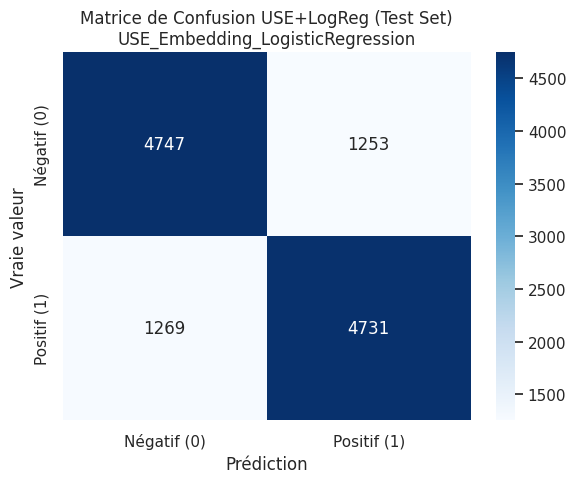


Sauvegarde du classifieur Logistic Regression avec MLflow...


2025/04/29 11:53:50 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Classifieur sauvegardé.

Run MLflow (USE_Embedding_LogisticRegression) terminé.


In [ ]:
# ==============================================================================
# --- EXPÉRIMENTATION 7 : Universal Sentence Encoder (USE) + Classifier Simple ---
# ==============================================================================
# Ce code est destiné à être exécuté dans un environnement où
# train_df, val_df, test_df (avec 'text_cleaned', 'target') sont chargés.

# --- 1. Imports Spécifiques et Constantes/Paramètres ---
print("\n--- Expérimentation 7: USE Setup ---")
import pandas as pd
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub # Pour charger USE
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (accuracy_score, f1_score, precision_score,
                             recall_score, confusion_matrix)
import mlflow
import mlflow.sklearn # Pour logguer le modèle sklearn
import time
import matplotlib.pyplot as plt
import seaborn as sns
import os

# --- Paramètres USE ---
# URL du modèle USE sur TensorFlow Hub (version 4 est courante)
USE_MODEL_URL = "https://tfhub.dev/google/universal-sentence-encoder/4"
TEXT_COLUMN_USE = 'text_cleaned' # Colonne à utiliser pour USE
TARGET_COLUMN = 'target'
# Paramètres pour Logistic Regression (peuvent être ajustés si besoin)
LOGREG_C = 1.0
LOGREG_SOLVER = 'liblinear' # Bon choix pour données binaires/pas trop grandes
LOGREG_MAX_ITER = 200 # Augmenter si convergence lente

print(f"Modèle TensorFlow Hub choisi : {USE_MODEL_URL}")
print(f"Classifieur : LogisticRegression (C={LOGREG_C}, solver={LOGREG_SOLVER})")

# --- 2. Chargement du Modèle USE ---
print("\nChargement du modèle USE depuis TensorFlow Hub...")
# Cela peut télécharger le modèle la première fois (plusieurs centaines de Mo)
start_load_time = time.time()
use_model = hub.load(USE_MODEL_URL)
load_time = time.time() - start_load_time
print(f"Modèle USE chargé en {load_time:.2f} secondes.")

# Fonction pour générer les embeddings par batches (plus sûr pour la mémoire)
def get_use_embeddings_batched(texts, batch_size=128):
    all_embeddings = []
    num_batches = int(np.ceil(len(texts) / batch_size))
    print(f"  Génération des embeddings pour {len(texts)} textes en {num_batches} batches...")
    start_embed_time = time.time()
    for i in range(0, len(texts), batch_size):
        batch_texts = texts[i:min(i + batch_size, len(texts))]
        # Le modèle USE prend une liste de strings et retourne un tenseur [n_strings, embedding_dim]
        batch_embeddings = use_model(batch_texts)
        all_embeddings.append(batch_embeddings.numpy()) # Convertir en NumPy
        if (i // batch_size + 1) % 50 == 0: # Afficher la progression tous les 50 batches
             print(f"    Batch {i // batch_size + 1}/{num_batches} terminé...")
    embed_time = time.time() - start_embed_time
    print(f"  Embeddings générés en {embed_time:.2f} secondes.")
    return np.vstack(all_embeddings) # Concaténer les embeddings des batches

# --- 3. Génération des Embeddings USE ---
# !! ATTENTION: CETTE ÉTAPE PEUT ÊTRE TRÈS LONGUE ET CONSOMMER BEAUCOUP DE RAM !!
# Envisager d'utiliser un échantillon plus petit pour tester le code rapidement.
# SAMPLE_SIZE = 10000 # Décommenter et ajuster pour tester
# train_df_sample = train_df.sample(n=SAMPLE_SIZE, random_state=42)
# val_df_sample = val_df.sample(n=int(SAMPLE_SIZE*0.2), random_state=42)
# test_df_sample = test_df.sample(n=int(SAMPLE_SIZE*0.2), random_state=42)

print("\nGénération des embeddings USE pour l'ensemble d'entraînement...")
# Convertir la série en liste est important pour TF Hub
X_train_use = get_use_embeddings_batched(train_df[TEXT_COLUMN_USE].tolist())
# X_train_use = get_use_embeddings_batched(train_df_sample[TEXT_COLUMN_USE].tolist()) # Pour tester

print("\nGénération des embeddings USE pour l'ensemble de validation...")
X_val_use = get_use_embeddings_batched(val_df[TEXT_COLUMN_USE].tolist())
# X_val_use = get_use_embeddings_batched(val_df_sample[TEXT_COLUMN_USE].tolist()) # Pour tester

print("\nGénération des embeddings USE pour l'ensemble de test...")
X_test_use = get_use_embeddings_batched(test_df[TEXT_COLUMN_USE].tolist())
# X_test_use = get_use_embeddings_batched(test_df_sample[TEXT_COLUMN_USE].tolist()) # Pour tester

print("\nDimensions des embeddings générés :")
print(f"  Train: {X_train_use.shape}")
print(f"  Validation: {X_val_use.shape}")
print(f"  Test: {X_test_use.shape}")

# --- 4. Préparation des Données (Targets) ---
y_train_use = train_df[TARGET_COLUMN].values
y_val_use = val_df[TARGET_COLUMN].values
y_test_use = test_df[TARGET_COLUMN].values
# Si échantillon utilisé pour tester:
# y_train_use = train_df_sample[TARGET_COLUMN].values
# y_val_use = val_df_sample[TARGET_COLUMN].values
# y_test_use = test_df_sample[TARGET_COLUMN].values

# --- 5. Définition et Entraînement du Classifieur ---
print("\nDéfinition et entraînement du classifieur Logistic Regression...")
classifier_use = LogisticRegression(
    C=LOGREG_C,
    solver=LOGREG_SOLVER,
    max_iter=LOGREG_MAX_ITER,
    random_state=42
)

start_train_clf_time = time.time()
classifier_use.fit(X_train_use, y_train_use)
train_clf_time = time.time() - start_train_clf_time
print(f"Entraînement du classifieur terminé en {train_clf_time:.2f} secondes.")

# --- 6. Bloc MLflow pour Évaluation et Logging ---
print("\n--- Démarrage du Run MLflow pour USE ---")
mlflow.set_experiment("AirParadis_Sentiment_Analysis")
run_name_use = "USE_Embedding_LogisticRegression"

with mlflow.start_run(run_name=run_name_use) as run:
    print(f"Run MLflow démarré: {run_name_use} (ID: {run.info.run_id})")
    start_time_use_exp = time.time() # Temps total incluant inférence USE + train clf

    # --- Log des Paramètres ---
    print("Log des paramètres USE dans MLflow...")
    mlflow.log_param("text_preprocessing", TEXT_COLUMN_USE)
    mlflow.log_param("embedding_model_url", USE_MODEL_URL)
    mlflow.log_param("embedding_dimension", X_train_use.shape[1]) # Dim de l'embedding USE
    mlflow.log_param("classifier_type", "LogisticRegression")
    mlflow.log_param("logreg_C", LOGREG_C)
    mlflow.log_param("logreg_solver", LOGREG_SOLVER)
    mlflow.log_param("logreg_max_iter", LOGREG_MAX_ITER)

    # Log du temps d'entraînement spécifique au classifieur
    mlflow.log_metric("classifier_training_time_seconds", train_clf_time)

    # --- Évaluation sur Train/Val/Test ---
    print("\nÉvaluation du classifieur sur les embeddings USE...")
    y_train_pred_use = classifier_use.predict(X_train_use)
    y_val_pred_use = classifier_use.predict(X_val_use)
    y_test_pred_use = classifier_use.predict(X_test_use)

    # Calcul des métriques
    metrics_use = {}
    metrics_use['train_accuracy'] = accuracy_score(y_train_use, y_train_pred_use)
    metrics_use['train_f1'] = f1_score(y_train_use, y_train_pred_use)
    metrics_use['train_precision'] = precision_score(y_train_use, y_train_pred_use)
    metrics_use['train_recall'] = recall_score(y_train_use, y_train_pred_use)
    metrics_use['val_accuracy'] = accuracy_score(y_val_use, y_val_pred_use)
    metrics_use['val_f1'] = f1_score(y_val_use, y_val_pred_use)
    metrics_use['val_precision'] = precision_score(y_val_use, y_val_pred_use)
    metrics_use['val_recall'] = recall_score(y_val_use, y_val_pred_use)
    metrics_use['test_accuracy'] = accuracy_score(y_test_use, y_test_pred_use)
    metrics_use['test_f1'] = f1_score(y_test_use, y_test_pred_use)
    metrics_use['test_precision'] = precision_score(y_test_use, y_test_pred_use)
    metrics_use['test_recall'] = recall_score(y_test_use, y_test_pred_use)

    print(f"Train      - Acc: {metrics_use['train_accuracy']:.4f}, F1: {metrics_use['train_f1']:.4f}, P: {metrics_use['train_precision']:.4f}, R: {metrics_use['train_recall']:.4f}")
    print(f"Validation - Acc: {metrics_use['val_accuracy']:.4f}, F1: {metrics_use['val_f1']:.4f}, P: {metrics_use['val_precision']:.4f}, R: {metrics_use['val_recall']:.4f}")
    print(f"Test       - Acc: {metrics_use['test_accuracy']:.4f}, F1: {metrics_use['test_f1']:.4f}, P: {metrics_use['test_precision']:.4f}, R: {metrics_use['test_recall']:.4f}")

    # Logguer toutes les métriques
    mlflow.log_metrics(metrics_use)

    # --- Génération et Log de la Matrice de Confusion (Test Set) ---
    print("\nGénération et sauvegarde de la matrice de confusion USE (Test Set)...")
    cm_use = confusion_matrix(y_test_use, y_test_pred_use)
    fig_cm_use, ax_cm_use = plt.subplots(figsize=(6, 5))
    sns.heatmap(cm_use, annot=True, fmt='d', cmap='Blues', ax=ax_cm_use,
                xticklabels=['Négatif (0)', 'Positif (1)'],
                yticklabels=['Négatif (0)', 'Positif (1)'])
    ax_cm_use.set_xlabel('Prédiction'); ax_cm_use.set_ylabel('Vraie valeur')
    ax_cm_use.set_title(f'Matrice de Confusion USE+LogReg (Test Set)\n{run_name_use}')
    plt.tight_layout()
    mlflow.log_figure(fig_cm_use, "confusion_matrix_use_logreg_test_set.png")
    print("Matrice de confusion sauvegardée.")
    plt.show()
    plt.close(fig_cm_use)

    # --- Sauvegarde du Classifieur Sklearn ---
    print("\nSauvegarde du classifieur Logistic Regression avec MLflow...")
    mlflow.sklearn.log_model(
        sk_model=classifier_use,
        artifact_path="use-logistic-regression-classifier" # Nom de l'artefact
        # Optionnel: signature, input_example si besoin pour mlflow.pyfunc
    )
    print("Classifieur sauvegardé.")

    # Log du temps total (USE inference + clf training)
    total_exp_time_use = time.time() - start_time_use_exp
    mlflow.log_metric("total_experiment_time_seconds", total_exp_time_use)


print(f"\nRun MLflow ({run_name_use}) terminé.")

# ==============================================================================
# --- FIN EXPÉRIMENTATION 7 ---
# ==============================================================================

**Observation après Exp 7 (USE + LogReg) :**

Le modèle **Universal Sentence Encoder (USE) combiné à une Régression Logistique** (F1-Score ~0.790) obtient le **meilleur F1-Score de toutes les expérimentations** menées sur l'échantillon. Il devance légèrement l'approche BERT Feature Extraction et confirme l'efficacité des embeddings de phrases pré-entraînés pour cette tâche, tout en nécessitant un classifieur final très simple et rapide à entraîner (après l'étape d'extraction des embeddings).

# Phase 4 : Évaluation & Sélection du Modèle 🏆

## Choix de la métrique

Nous entamons maintenant les étapes cruciales de la **Phase 4 : Évaluation & Sélection du Modèle**. Cela implique de choisir formellement le modèle qui sera déployé pour Air Paradis et d'amorcer sa mise en production en suivant une démarche MLOps.

Nous confirmons le choix du **F1-Score** comme métrique d'évaluation principale. Bien que le jeu de données soit équilibré, le F1-Score capture le mieux le compromis nécessaire pour Air Paradis : identifier un maximum de tweets négatifs (**Recall** élevé, notre métrique secondaire clé) sans générer une quantité excessive de fausses alertes (**Precision** raisonnable).

Avant la comparaison finale et la sélection, et pour répondre à l'exigence d'optimisation d'un "modèle sur mesure avancé", nous allons réaliser une **optimisation des hyperparamètres (HPO)**. Nous ciblerons le modèle **LSTM + FastText (Exp 4)**, car il représente une implémentation solide de l'approche "sur mesure avancé" demandée et a montré des performances prometteuses. Cette HPO sera effectuée sur **l'échantillon de 5%**, en utilisant la méthode de prétraitement (**lemmatisation** ou **stemming**) qui s'est avérée la plus performante lors de notre test comparatif dédié. Bien que cela ne garantisse pas les hyperparamètres optimaux absolus pour le jeu de données complet, c'est une approche pragmatique et justifiée pour démontrer le processus d'HPO dans les limites du projet.

Une fois cette optimisation réalisée, nous procéderons à la comparaison finale entre la baseline, l'LSTM optimisé, et les approches USE / BERT Feature Extraction pour sélectionner le modèle à enregistrer et à déployer.

## Optimisation des hyperparamètres

In [ ]:
# ==============================================================================
# --- TEST SUPPLÉMENTAIRE : LSTM + FastText avec Input STEMMED ---
# ==============================================================================

# --- Imports nécessaires (normalement déjà faits, mais pour la clarté) ---
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.sequence import pad_sequences # Re-importer si besoin
from sklearn.metrics import (accuracy_score, f1_score, precision_score,
                             recall_score, confusion_matrix)
import mlflow
import mlflow.tensorflow
import time
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# --- Prérequis (Vérifications essentielles) ---
print("\n--- Préparation Test Stemming ---")
if 'tokenizer' not in locals(): raise NameError("Tokenizer Keras non défini.")
if 'embedding_matrix_fasttext' not in locals(): raise NameError("Matrice embedding FastText non définie.")
if 'train_df' not in locals() or 'text_stem' not in train_df.columns: raise NameError("DataFrame train_df ou colonne text_stem manquante.")
if 'val_df' not in locals() or 'text_stem' not in val_df.columns: raise NameError("DataFrame val_df ou colonne text_stem manquante.")
if 'test_df' not in locals() or 'text_stem' not in test_df.columns: raise NameError("DataFrame test_df ou colonne text_stem manquante.")
if 'y_train' not in locals(): raise NameError("y_train non défini") # Devrait exister depuis la prépa Keras initiale
if 'y_val' not in locals(): raise NameError("y_val non défini")
if 'y_test' not in locals(): raise NameError("y_test non défini")

# --- Récupération des constantes/paramètres de l'Exp 4 ---
# S'assurer qu'ils sont bien chargés depuis les exécutions précédentes
if 'VOCAB_SIZE' not in locals(): raise NameError("VOCAB_SIZE non défini")
if 'FASTTEXT_EMBEDDING_DIM' not in locals(): raise NameError("FASTTEXT_EMBEDDING_DIM non défini")
if 'maxlen' not in locals(): raise NameError("maxlen non défini")
if 'LSTM_UNITS' not in locals(): LSTM_UNITS = 64
if 'DROPOUT_RATE_LSTM' not in locals(): DROPOUT_RATE_LSTM = 0.2
if 'LEARNING_RATE' not in locals(): LEARNING_RATE = 0.001
if 'CLIPNORM' not in locals(): CLIPNORM = 1.0
if 'EPOCHS' not in locals(): EPOCHS = 10
if 'BATCH_SIZE' not in locals(): BATCH_SIZE = 128
if 'EARLY_STOPPING_PATIENCE' not in locals(): EARLY_STOPPING_PATIENCE = 2

TEXT_COLUMN_STEM = 'text_stem' # La colonne que nous allons utiliser maintenant
TARGET_COLUMN = 'target' # Reste la même

# --- 1. Préparer les Données Stemmées ---
print(f"Utilisation du tokenizer existant (fitté sur lemma) pour convertir '{TEXT_COLUMN_STEM}'...")
train_sequences_stem = tokenizer.texts_to_sequences(train_df[TEXT_COLUMN_STEM])
val_sequences_stem = tokenizer.texts_to_sequences(val_df[TEXT_COLUMN_STEM])
test_sequences_stem = tokenizer.texts_to_sequences(test_df[TEXT_COLUMN_STEM])

print("Application du padding aux séquences stemmées...")
padding_type = 'pre' # Garder les mêmes paramètres de padding
truncating_type = 'post'

X_train_stem_pad = pad_sequences(train_sequences_stem, maxlen=maxlen, padding=padding_type, truncating=truncating_type)
X_val_stem_pad = pad_sequences(val_sequences_stem, maxlen=maxlen, padding=padding_type, truncating=truncating_type)
X_test_stem_pad = pad_sequences(test_sequences_stem, maxlen=maxlen, padding=padding_type, truncating=truncating_type)

print("Formes des données stemmées paddées :")
print(f"  Train: {X_train_stem_pad.shape}")
print(f"  Validation: {X_val_stem_pad.shape}")
print(f"  Test: {X_test_stem_pad.shape}")
# Les targets y_train, y_val, y_test sont déjà prêtes (tableaux NumPy)

# --- 2. Définir le Modèle (Identique à Exp 4) ---
print("\nRedéfinition du modèle Keras LSTM avec FastText (architecture Exp 4)...")
model_lstm_ft_stem = Sequential([
    Embedding(
        input_dim=VOCAB_SIZE,
        output_dim=FASTTEXT_EMBEDDING_DIM,
        weights=[embedding_matrix_fasttext], # Utilise la même matrice
        input_length=maxlen,
        trainable=False,                     # Non entraînable
        mask_zero=True
    ),
    LSTM(LSTM_UNITS, dropout=DROPOUT_RATE_LSTM, recurrent_dropout=DROPOUT_RATE_LSTM),
    Dense(1, activation='sigmoid')
])

# --- 3. Compiler le Modèle (Identique à Exp 4) ---
print("Recompilation du modèle avec les mêmes paramètres...")
optimizer_stem = Adam(learning_rate=LEARNING_RATE, clipnorm=CLIPNORM)
model_lstm_ft_stem.compile(
    loss='binary_crossentropy',
    optimizer=optimizer_stem,
    metrics=['accuracy']
)
model_lstm_ft_stem.build(input_shape=(None, maxlen)) # Build pour summary
model_lstm_ft_stem.summary() # Afficher pour vérifier

# --- 4. Lancer un Run MLflow ---
mlflow.set_experiment("AirParadis_Sentiment_Analysis")
run_name_stem_test = "LSTM_FastText_Stemmed_Input_Test" # Nom distinct
best_model_filepath_stem_test = './best_lstm_ft_stem_test_model.keras'

with mlflow.start_run(run_name=run_name_stem_test) as run:
    print(f"\nDémarrage du run MLflow : {run_name_stem_test} (ID: {run.info.run_id})")
    start_time_stem_exp = time.time()

    # --- Log des Paramètres ---
    print("Log des paramètres dans MLflow...")
    mlflow.log_param("text_preprocessing", TEXT_COLUMN_STEM) # ! Indique Stemming !
    mlflow.log_param("model_type", "LSTM")
    mlflow.log_param("embedding_type", "FastText_pretrained")
    mlflow.log_param("fasttext_embedding_dim", FASTTEXT_EMBEDDING_DIM)
    mlflow.log_param("vocab_size_limit", VOCAB_SIZE)
    mlflow.log_param("maxlen", maxlen)
    mlflow.log_param("lstm_units", LSTM_UNITS)
    mlflow.log_param("lstm_dropout", DROPOUT_RATE_LSTM)
    mlflow.log_param("learning_rate", LEARNING_RATE)
    mlflow.log_param("optimizer_clipnorm", CLIPNORM)
    mlflow.log_param("epochs_max", EPOCHS)
    mlflow.log_param("batch_size", BATCH_SIZE)
    mlflow.log_param("early_stopping_patience", EARLY_STOPPING_PATIENCE)
    mlflow.log_param("embedding_trainable", False)
    mlflow.log_param("model_summary_json", model_lstm_ft_stem.to_json())

    # --- Callbacks ---
    early_stopping_stem = EarlyStopping(monitor='val_loss', patience=EARLY_STOPPING_PATIENCE, restore_best_weights=True, verbose=1)
    # ModelCheckpoint est optionnel pour ce test rapide, mais incluons-le par cohérence
    model_checkpoint_stem = ModelCheckpoint(filepath=best_model_filepath_stem_test, monitor='val_loss', save_best_only=True, verbose=0) # Moins verbeux

    # --- 5. Entraîner sur Données Stemmées ---
    print("\nEntraînement du modèle sur les données stemmées...")
    history_stem = model_lstm_ft_stem.fit(
        X_train_stem_pad, y_train, # Utilise les données stemmées
        epochs=EPOCHS,
        batch_size=BATCH_SIZE,
        validation_data=(X_val_stem_pad, y_val), # Validation sur stemmées
        callbacks=[early_stopping_stem, model_checkpoint_stem],
        verbose=1
    )
    training_time_stem = time.time() - start_time_stem_exp
    print(f"Entraînement terminé en {training_time_stem:.2f} secondes.")
    mlflow.log_metric("training_time_seconds", training_time_stem)
    actual_epochs_stem = len(history_stem.history['loss'])
    mlflow.log_param("actual_epochs_trained", actual_epochs_stem)

    # --- Utilisation du Meilleur Modèle ---
    best_model_lstm_ft_stem = model_lstm_ft_stem # Car restore_best_weights=True

    # --- 6. Évaluer & Logger ---
    print("\nÉvaluation finale du meilleur modèle (sur données stemmées)...")
    # Évaluation Keras (Loss, Accuracy)
    train_loss_stem, train_accuracy_stem = best_model_lstm_ft_stem.evaluate(X_train_stem_pad, y_train, verbose=0, batch_size=1024)
    val_loss_stem, val_accuracy_stem = best_model_lstm_ft_stem.evaluate(X_val_stem_pad, y_val, verbose=0, batch_size=1024)
    test_loss_stem, test_accuracy_stem = best_model_lstm_ft_stem.evaluate(X_test_stem_pad, y_test, verbose=0, batch_size=1024)

    print(f"Train (Stem) - Loss: {train_loss_stem:.4f}, Accuracy: {train_accuracy_stem:.4f}")
    mlflow.log_metric("best_train_loss", train_loss_stem)
    mlflow.log_metric("best_train_accuracy", train_accuracy_stem)
    print(f"Validation (Stem) - Loss: {val_loss_stem:.4f}, Accuracy: {val_accuracy_stem:.4f}")
    mlflow.log_metric("best_val_loss", val_loss_stem)
    mlflow.log_metric("best_val_accuracy", val_accuracy_stem)
    print(f"Test (Stem) - Loss: {test_loss_stem:.4f}, Accuracy: {test_accuracy_stem:.4f}")
    mlflow.log_metric("best_test_loss", test_loss_stem)
    mlflow.log_metric("best_test_accuracy", test_accuracy_stem)

    # Calcul Métriques Détaillées (F1, P, R)
    print("\nCalcul des métriques détaillées (sur données stemmées)...")
    y_train_proba_stem = best_model_lstm_ft_stem.predict(X_train_stem_pad, batch_size=1024)
    y_val_proba_stem = best_model_lstm_ft_stem.predict(X_val_stem_pad, batch_size=1024)
    y_test_proba_stem = best_model_lstm_ft_stem.predict(X_test_stem_pad, batch_size=1024)
    y_train_pred_class_stem = (y_train_proba_stem > 0.5).astype(int)
    y_val_pred_class_stem = (y_val_proba_stem > 0.5).astype(int)
    y_test_pred_class_stem = (y_test_proba_stem > 0.5).astype(int)

    metrics_stem = {}
    metrics_stem['train_f1'] = f1_score(y_train, y_train_pred_class_stem)
    metrics_stem['train_precision'] = precision_score(y_train, y_train_pred_class_stem)
    metrics_stem['train_recall'] = recall_score(y_train, y_train_pred_class_stem)
    metrics_stem['val_f1'] = f1_score(y_val, y_val_pred_class_stem) # !! Métrique clé pour la comparaison !!
    metrics_stem['val_precision'] = precision_score(y_val, y_val_pred_class_stem)
    metrics_stem['val_recall'] = recall_score(y_val, y_val_pred_class_stem)
    metrics_stem['test_f1'] = f1_score(y_test, y_test_pred_class_stem)
    metrics_stem['test_precision'] = precision_score(y_test, y_test_pred_class_stem)
    metrics_stem['test_recall'] = recall_score(y_test, y_test_pred_class_stem)

    print(f"Train      (Stem) - F1: {metrics_stem['train_f1']:.4f}, P: {metrics_stem['train_precision']:.4f}, R: {metrics_stem['train_recall']:.4f}")
    print(f"Validation (Stem) - F1: {metrics_stem['val_f1']:.4f}, P: {metrics_stem['val_precision']:.4f}, R: {metrics_stem['val_recall']:.4f}")
    print(f"Test       (Stem) - F1: {metrics_stem['test_f1']:.4f}, P: {metrics_stem['test_precision']:.4f}, R: {metrics_stem['test_recall']:.4f}")

    mlflow.log_metrics({f"best_{k}": v for k, v in metrics_stem.items()}) # Log avec préfixe 'best_'

    # Visualisations (Courbes, Matrice Confusion)
    print("\nGénération et sauvegarde des artefacts visuels (stemmed)...")
    epochs_range_stem = range(1, actual_epochs_stem + 1)
    # Loss Curve
    fig_loss_stem, ax_loss_stem = plt.subplots(figsize=(10, 6))
    ax_loss_stem.plot(epochs_range_stem, history_stem.history['loss'], label='Training Loss')
    ax_loss_stem.plot(epochs_range_stem, history_stem.history['val_loss'], label='Validation Loss')
    ax_loss_stem.set_title('Loss (LSTM + FastText - Stemmed Input)')
    ax_loss_stem.set_xlabel('Epoch'); ax_loss_stem.set_ylabel('Loss')
    ax_loss_stem.legend(); ax_loss_stem.grid(True); plt.tight_layout()
    mlflow.log_figure(fig_loss_stem, "learning_curves_loss_stem.png")
    plt.close(fig_loss_stem) # Fermer pour éviter double affichage
    # Accuracy Curve
    fig_acc_stem, ax_acc_stem = plt.subplots(figsize=(10, 6))
    ax_acc_stem.plot(epochs_range_stem, history_stem.history['accuracy'], label='Training Accuracy')
    ax_acc_stem.plot(epochs_range_stem, history_stem.history['val_accuracy'], label='Validation Accuracy')
    ax_acc_stem.set_title('Accuracy (LSTM + FastText - Stemmed Input)')
    ax_acc_stem.set_xlabel('Epoch'); ax_acc_stem.set_ylabel('Accuracy')
    ax_acc_stem.legend(); ax_acc_stem.grid(True); plt.tight_layout()
    mlflow.log_figure(fig_acc_stem, "learning_curves_accuracy_stem.png")
    plt.close(fig_acc_stem)
    # Confusion Matrix (Test Set)
    cm_stem = confusion_matrix(y_test, y_test_pred_class_stem)
    fig_cm_stem, ax_cm_stem = plt.subplots(figsize=(6, 5))
    sns.heatmap(cm_stem, annot=True, fmt='d', cmap='Blues', ax=ax_cm_stem,
                xticklabels=['Négatif (0)', 'Positif (1)'],
                yticklabels=['Négatif (0)', 'Positif (1)'])
    ax_cm_stem.set_xlabel('Prédiction'); ax_cm_stem.set_ylabel('Vraie valeur')
    ax_cm_stem.set_title(f'Confusion Matrix (Stemmed Test Set)\n{run_name_stem_test}')
    plt.tight_layout()
    mlflow.log_figure(fig_cm_stem, "confusion_matrix_stem_test_set.png")
    plt.close(fig_cm_stem)
    print("Artefacts visuels sauvegardés dans MLflow.")
    # Afficher la matrice de confusion ici pour la voir dans le notebook
    plt.show()

    # Sauvegarde Modèle
    print("\nSauvegarde du modèle entraîné sur stem avec MLflow...")
    mlflow.tensorflow.log_model(
        model=best_model_lstm_ft_stem,
        artifact_path="keras-lstm-fasttext-stem-model" # Nom d'artefact distinct
    )
    print("Modèle sauvegardé.")

    # Nettoyage Checkpoint
    if os.path.exists(best_model_filepath_stem_test):
        os.remove(best_model_filepath_stem_test)
        print(f"Fichier checkpoint local '{best_model_filepath_stem_test}' supprimé.")

print(f"\nRun MLflow ({run_name_stem_test}) terminé.")

# --- 7. Comparer ---
print("\n--- Comparaison Lemma vs Stem (Validation F1) ---")
# Récupérer les ID des runs depuis l'exécution ou MLflow UI
run_id_lemma = "f667a00c211a49d5b57c5fc60f11c481" # (Run Exp 4)
run_id_stem = run.info.run_id # ID du run qu'on vient de terminer

try:
    client = mlflow.tracking.MlflowClient()
    run_lemma = client.get_run(run_id_lemma)
    run_stem = client.get_run(run_id_stem)

    f1_val_lemma = run_lemma.data.metrics.get('best_val_f1', 'N/A')
    f1_val_stem = run_stem.data.metrics.get('best_val_f1', 'N/A')

    print(f"F1 Score (Validation) pour LSTM+FastText avec input LEMMA (Run ID: {run_id_lemma}): {f1_val_lemma:.4f}")
    print(f"F1 Score (Validation) pour LSTM+FastText avec input STEM (Run ID: {run_id_stem}): {f1_val_stem:.4f}")

    if f1_val_stem > f1_val_lemma:
        print("\nConclusion préliminaire : Le stemming semble améliorer légèrement le F1 sur validation pour ce modèle.")
        preprocessing_choice = 'stem'
    elif f1_val_stem < f1_val_lemma:
        print("\nConclusion préliminaire : La lemmatisation donne un meilleur F1 sur validation pour ce modèle.")
        preprocessing_choice = 'lemma'
    else:
        print("\nConclusion préliminaire : Pas de différence significative sur le F1 validation. Gardons la lemmatisation par défaut.")
        preprocessing_choice = 'lemma'

except Exception as e:
    print(f"\nErreur lors de la récupération des runs MLflow pour comparaison : {e}")
    print("Veuillez vérifier les Run IDs et l'accès à MLflow.")
    print("Décision par défaut : garder la lemmatisation.")
    preprocessing_choice = 'lemma' # Sécurité

print(f"-> Choix pour l'optimisation des hyperparamètres : utiliser le prétraitement '{preprocessing_choice}'")

# ==============================================================================
# --- FIN TEST STEMMING ---
# ==============================================================================


--- Préparation Test Stemming ---
Utilisation du tokenizer existant (fitté sur lemma) pour convertir 'text_stem'...
Application du padding aux séquences stemmées...
Formes des données stemmées paddées :
  Train: (56000, 13)
  Validation: (12000, 13)
  Test: (12000, 13)

Redéfinition du modèle Keras LSTM avec FastText (architecture Exp 4)...


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Recompilation du modèle avec les mêmes paramètres...


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ (None, 13, 300)        │     3,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 64)             │        93,440 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,093,505 (11.80 MB)

 Trainable params: 93,505 (365.25 KB)

 Non-trainable params: 3,000,000 (11.44 MB)


Démarrage du run MLflow : LSTM_FastText_Stemmed_Input_Test (ID: 0d995d6640424233b56272344a155f10)
Log des paramètres dans MLflow...

Entraînement du modèle sur les données stemmées...
Epoch 1/10
438/438 ━━━━━━━━━━━━━━━━━━━━ 48s 87ms/step - accuracy: 0.6511 - loss: 0.6241 - val_accuracy: 0.7118 - val_loss: 0.5591
Epoch 2/10
438/438 ━━━━━━━━━━━━━━━━━━━━ 38s 88ms/step - accuracy: 0.7018 - loss: 0.5635 - val_accuracy: 0.7195 - val_loss: 0.5475
Epoch 3/10
438/438 ━━━━━━━━━━━━━━━━━━━━ 40s 86ms/step - accuracy: 0.7121 - loss: 0.5536 - val_accuracy: 0.7213 - val_loss: 0.5429
Epoch 4/10
438/438 ━━━━━━━━━━━━━━━━━━━━ 40s 85ms/step - accuracy: 0.7196 - loss: 0.5442 - val_accuracy: 0.7242 - val_loss: 0.5366
Epoch 5/10
438/438 ━━━━━━━━━━━━━━━━━━━━ 42s 87ms/step - accuracy: 0.7208 - loss: 0.5376 - val_accuracy: 0.7272 - val_loss: 0.5332
Epoch 6/10
438/438 ━━━━━━━━━━━━━━━━━━━━ 38s 86ms/step - accuracy: 0.7240 - loss: 0.5352 - val_accuracy: 0.7276 - val_loss: 0.5314
Epoch 7/10
438/438 ━━━━━━━━━━━━━━━━

2025/04/30 08:14:40 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.


Artefacts visuels sauvegardés dans MLflow.

Sauvegarde du modèle entraîné sur stem avec MLflow...


2025/04/30 08:14:59 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Modèle sauvegardé.
Fichier checkpoint local './best_lstm_ft_stem_test_model.keras' supprimé.

Run MLflow (LSTM_FastText_Stemmed_Input_Test) terminé.

--- Comparaison Lemma vs Stem (Validation F1) ---
F1 Score (Validation) pour LSTM+FastText avec input LEMMA (Run ID: f667a00c211a49d5b57c5fc60f11c481): 0.7515
F1 Score (Validation) pour LSTM+FastText avec input STEM (Run ID: 0d995d6640424233b56272344a155f10): 0.7369

Conclusion préliminaire : La lemmatisation donne un meilleur F1 sur validation pour ce modèle.
-> Choix pour l'optimisation des hyperparamètres : utiliser le prétraitement 'lemma'


Comme l'indique la sortie, pour cette architecture (LSTM+FastText) et sur cet échantillon, la **lemmatisation (`text_lemma`) a donné des résultats légèrement supérieurs** au stemming (`text_stem`) sur la métrique F1 du jeu de validation.

**Prochaine Étape : Optimisation des Hyperparamètres (HPO)**

Nous allons donc procéder à l'optimisation des hyperparamètres en nous basant sur :

1.  **Modèle :** LSTM + FastText (architecture de l'Exp 4)
2.  **Données :** Les données de l'échantillon (5%) prétraitées avec la **lemmatisation** (`X_train_pad`, `X_val_pad`, `y_train`, `y_val`).
3.  **Objectif :** Trouver la combinaison d'hyperparamètres (ex: `LSTM_UNITS`, `LEARNING_RATE`, `DROPOUT_RATE_LSTM`) qui maximise le F1-Score sur le jeu de validation (`X_val_pad`, `y_val`).

Nous testerons les combinaisons suivantes (en plus de la référence Exp 4 qui avait Units=64, LR=0.001, Dropout=0.2) :

    Trial 1 : Units=128, LR=0.0005, Dropout=0.3 (Plus de capacité, LR plus faible, plus de dropout)

    Trial 2 : Units=32, LR=0.0005, Dropout=0.3 (Moins de capacité, LR plus faible, plus de dropout)

    Trial 3 : Units=64, LR=0.0005, Dropout=0.4 (LR plus faible, beaucoup de dropout)

    Trial 4 : Units=64, LR=0.0001, Dropout=0.2 (LR très faible)

In [ ]:
# ==============================================================================
# --- PHASE 4.2 : Optimisation Hyperparamètres (HPO) pour LSTM+FastText(Lemma) ---
# ==============================================================================
# VERSION AVEC ÉVALUATION TRAIN + VALIDATION (SANS PLOTS DANS LA BOUCLE)

# --- Imports nécessaires (normalement déjà faits) ---
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import (accuracy_score, f1_score, precision_score,
                             recall_score, confusion_matrix)
import mlflow
import mlflow.tensorflow
import time
import os
import numpy as np

# --- Prérequis (Vérifications des données Lemmatisées) ---
print("\n--- Préparation HPO pour LSTM + FastText (Lemma) ---")
if 'X_train_pad' not in locals(): raise NameError("X_train_pad (lemmatisé) non défini.")
if 'y_train' not in locals(): raise NameError("y_train non défini.")
if 'X_val_pad' not in locals(): raise NameError("X_val_pad (lemmatisé) non défini.")
if 'y_val' not in locals(): raise NameError("y_val non défini.")
if 'embedding_matrix_fasttext' not in locals(): raise NameError("Matrice embedding FastText non définie.")
if 'VOCAB_SIZE' not in locals(): raise NameError("VOCAB_SIZE non défini")
if 'FASTTEXT_EMBEDDING_DIM' not in locals(): raise NameError("FASTTEXT_EMBEDDING_DIM non défini")
if 'maxlen' not in locals(): raise NameError("maxlen non défini")

# --- Hyperparamètres à Tester ---
hpo_trials = [
    {'lstm_units': 128, 'learning_rate': 0.0005, 'dropout_rate': 0.3}, # Trial 1
    {'lstm_units': 32, 'learning_rate': 0.0005, 'dropout_rate': 0.3},  # Trial 2
    {'lstm_units': 64, 'learning_rate': 0.0005, 'dropout_rate': 0.4},  # Trial 3
    {'lstm_units': 64, 'learning_rate': 0.0001, 'dropout_rate': 0.2},  # Trial 4
]

# --- Constantes pour l'entraînement HPO ---
HPO_EPOCHS = 10
HPO_BATCH_SIZE = 128
HPO_EARLY_STOPPING_PATIENCE = 2
HPO_CLIPNORM = 1.0

# --- Boucle sur les Essais HPO ---
print(f"\nLancement de {len(hpo_trials)} essais d'optimisation d'hyperparamètres...")
mlflow.set_experiment("AirParadis_Sentiment_Analysis")

# Dictionnaire pour stocker les résultats clés pour comparaison finale
hpo_results = {}

for i, params in enumerate(hpo_trials):
    trial_num = i + 1
    current_lstm_units = params['lstm_units']
    current_lr = params['learning_rate']
    current_dropout = params['dropout_rate']

    run_name_hpo = f"HPO_LSTM_FT_Lemma_U{current_lstm_units}_LR{current_lr}_D{current_dropout}"
    print(f"\n--- Démarrage Essai HPO {trial_num}/{len(hpo_trials)} : {run_name_hpo} ---")

    # --- Démarrer Run MLflow ---
    if mlflow.active_run(): mlflow.end_run() # Terminer run précédent si besoin
    with mlflow.start_run(run_name=run_name_hpo) as run:
        run_id = run.info.run_id # Stocker l'ID du run
        start_time_hpo_trial = time.time()
        print(f"Run MLflow démarré (ID: {run_id})")

        # --- Log Paramètres HPO ---
        mlflow.log_param("hpo_trial_number", trial_num)
        mlflow.log_param("text_preprocessing", "lemma")
        mlflow.log_param("model_type", "LSTM")
        mlflow.log_param("embedding_type", "FastText_pretrained")
        mlflow.log_param("embedding_trainable", False)
        mlflow.log_params(params)
        mlflow.log_param("batch_size", HPO_BATCH_SIZE)
        mlflow.log_param("epochs_max", HPO_EPOCHS)
        mlflow.log_param("early_stopping_patience", HPO_EARLY_STOPPING_PATIENCE)
        mlflow.log_param("optimizer_clipnorm", HPO_CLIPNORM)

        # --- Définir et Compiler le Modèle ---
        print("Définition et compilation du modèle...")
        model_hpo = Sequential([
            Embedding(
                input_dim=VOCAB_SIZE, output_dim=FASTTEXT_EMBEDDING_DIM,
                weights=[embedding_matrix_fasttext], input_length=maxlen,
                trainable=False, mask_zero=True
            ),
            LSTM(current_lstm_units, dropout=current_dropout, recurrent_dropout=current_dropout),
            Dense(1, activation='sigmoid')
        ])
        optimizer_hpo = Adam(learning_rate=current_lr, clipnorm=HPO_CLIPNORM)
        model_hpo.compile(loss='binary_crossentropy', optimizer=optimizer_hpo, metrics=['accuracy'])

        # --- Callbacks ---
        early_stopping_hpo = EarlyStopping(monitor='val_loss', patience=HPO_EARLY_STOPPING_PATIENCE, restore_best_weights=True, verbose=0)

        # --- Entraînement ---
        print("Entraînement du modèle...")
        history_hpo = model_hpo.fit(
            X_train_pad, y_train, epochs=HPO_EPOCHS, batch_size=HPO_BATCH_SIZE,
            validation_data=(X_val_pad, y_val), callbacks=[early_stopping_hpo], verbose=0
        )
        training_time_hpo = time.time() - start_time_hpo_trial
        actual_epochs_hpo = len(history_hpo.history['loss'])
        print(f"Entraînement terminé en {training_time_hpo:.2f} sec ({actual_epochs_hpo} époques).")
        mlflow.log_metric("training_time_seconds", training_time_hpo)
        mlflow.log_param("actual_epochs_trained", actual_epochs_hpo)

        # --- Évaluation sur VALIDATION SET ---
        print("Évaluation sur le jeu de validation...")
        y_val_proba_hpo = model_hpo.predict(X_val_pad, batch_size=1024, verbose=0)
        y_val_pred_class_hpo = (y_val_proba_hpo > 0.5).astype(int)
        val_accuracy = accuracy_score(y_val, y_val_pred_class_hpo)
        val_f1 = f1_score(y_val, y_val_pred_class_hpo) # <-- Métrique cible
        val_precision = precision_score(y_val, y_val_pred_class_hpo)
        val_recall = recall_score(y_val, y_val_pred_class_hpo)
        print(f"  Validation - F1: {val_f1:.4f}, Acc: {val_accuracy:.4f}, P: {val_precision:.4f}, R: {val_recall:.4f}")
        mlflow.log_metric("validation_accuracy", val_accuracy)
        mlflow.log_metric("validation_f1", val_f1)
        mlflow.log_metric("validation_precision", val_precision)
        mlflow.log_metric("validation_recall", val_recall)

        # --- Évaluation sur TRAIN SET (pour overfitting) ---
        print("Évaluation sur le jeu d'entraînement...")
        y_train_proba_hpo = model_hpo.predict(X_train_pad, batch_size=1024, verbose=0)
        y_train_pred_class_hpo = (y_train_proba_hpo > 0.5).astype(int)
        train_accuracy = accuracy_score(y_train, y_train_pred_class_hpo)
        train_f1 = f1_score(y_train, y_train_pred_class_hpo)
        train_precision = precision_score(y_train, y_train_pred_class_hpo)
        train_recall = recall_score(y_train, y_train_pred_class_hpo)
        print(f"  Train      - F1: {train_f1:.4f}, Acc: {train_accuracy:.4f}, P: {train_precision:.4f}, R: {train_recall:.4f}")
        mlflow.log_metric("train_accuracy", train_accuracy)
        mlflow.log_metric("train_f1", train_f1)
        mlflow.log_metric("train_precision", train_precision)
        mlflow.log_metric("train_recall", train_recall)

        # Stocker le résultat clé pour la décision finale
        hpo_results[run_id] = {'params': params, 'val_f1': val_f1, 'train_f1': train_f1}

        print(f"--- Fin Essai HPO {trial_num} ---")

print("\nOptimisation des hyperparamètres terminée.")
print("Veuillez consulter l'interface MLflow pour les détails de chaque run.")

# --- Sélection du Meilleur Essai HPO ---
best_run_id = None
best_val_f1 = -1.0

print("\n--- Sélection du Meilleur Essai HPO ---")
for run_id, result in hpo_results.items():
    print(f"Run ID: {run_id[-6:]}..., Params: {result['params']}, Val F1: {result['val_f1']:.4f}, Train F1: {result['train_f1']:.4f}")
    if result['val_f1'] > best_val_f1:
        best_val_f1 = result['val_f1']
        best_run_id = run_id

if best_run_id:
    best_params = hpo_results[best_run_id]['params']
    print(f"\nMeilleure combinaison trouvée (Run ID: ...{best_run_id[-6:]}) :")
    print(f"  Paramètres : {best_params}")
    print(f"  Validation F1 : {best_val_f1:.4f}")
    # Stocker les meilleurs paramètres pour l'étape suivante
    final_lstm_units = best_params['lstm_units']
    final_learning_rate = best_params['learning_rate']
    final_dropout_rate = best_params['dropout_rate']
else:
    print("\nATTENTION : Aucun run HPO n'a pu être évalué correctement.")
    # Définir des valeurs par défaut ou arrêter
    # Par sécurité, on reprend les paramètres initiaux de l'Exp 4
    print("Reprise des paramètres par défaut de l'Exp 4.")
    final_lstm_units = 64
    final_learning_rate = 0.001
    final_dropout_rate = 0.2

print(f"\nParamètres retenus pour le modèle final optimisé : Units={final_lstm_units}, LR={final_learning_rate}, Dropout={final_dropout_rate}")

# ==============================================================================
# --- FIN PHASE 4.2 ---
# ==============================================================================


--- Préparation HPO pour LSTM + FastText (Lemma) ---

Lancement de 4 essais d'optimisation d'hyperparamètres...

--- Démarrage Essai HPO 1/4 : HPO_LSTM_FT_Lemma_U128_LR0.0005_D0.3 ---
Run MLflow démarré (ID: 4aac42bf17e34ad0a3784e8090d4a39b)
Définition et compilation du modèle...


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Entraînement du modèle...
Entraînement terminé en 801.97 sec (10 époques).
Évaluation sur le jeu de validation...
  Validation - F1: 0.7617, Acc: 0.7494, P: 0.7282, R: 0.7985
Évaluation sur le jeu d'entraînement...
  Train      - F1: 0.7641, Acc: 0.7533, P: 0.7306, R: 0.8007
--- Fin Essai HPO 1 ---

--- Démarrage Essai HPO 2/4 : HPO_LSTM_FT_Lemma_U32_LR0.0005_D0.3 ---
Run MLflow démarré (ID: 072a90a5ec9a4d65a22006706a7eeb60)
Définition et compilation du modèle...
Entraînement du modèle...


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Entraînement terminé en 338.75 sec (10 époques).
Évaluation sur le jeu de validation...
  Validation - F1: 0.7547, Acc: 0.7476, P: 0.7363, R: 0.7740
Évaluation sur le jeu d'entraînement...
  Train      - F1: 0.7567, Acc: 0.7510, P: 0.7380, R: 0.7764
--- Fin Essai HPO 2 ---

--- Démarrage Essai HPO 3/4 : HPO_LSTM_FT_Lemma_U64_LR0.0005_D0.4 ---
Run MLflow démarré (ID: 6eb786040c944da0bce5b6e81bf21216)
Définition et compilation du modèle...
Entraînement du modèle...


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Entraînement terminé en 577.11 sec (10 époques).
Évaluation sur le jeu de validation...
  Validation - F1: 0.7582, Acc: 0.7453, P: 0.7238, R: 0.7960
Évaluation sur le jeu d'entraînement...
  Train      - F1: 0.7595, Acc: 0.7480, P: 0.7248, R: 0.7978
--- Fin Essai HPO 3 ---

--- Démarrage Essai HPO 4/4 : HPO_LSTM_FT_Lemma_U64_LR0.0001_D0.2 ---
Run MLflow démarré (ID: 9679f271a28e4ca59bc9fecb3b507ebb)
Définition et compilation du modèle...
Entraînement du modèle...


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Entraînement terminé en 547.11 sec (10 époques).
Évaluation sur le jeu de validation...
  Validation - F1: 0.7322, Acc: 0.7314, P: 0.7324, R: 0.7320
Évaluation sur le jeu d'entraînement...
  Train      - F1: 0.7349, Acc: 0.7350, P: 0.7335, R: 0.7363
--- Fin Essai HPO 4 ---

Optimisation des hyperparamètres terminée.
Veuillez consulter l'interface MLflow pour les détails de chaque run.

--- Sélection du Meilleur Essai HPO ---
Run ID: d4a39b..., Params: {'lstm_units': 128, 'learning_rate': 0.0005, 'dropout_rate': 0.3}, Val F1: 0.7617, Train F1: 0.7641
Run ID: 7eeb60..., Params: {'lstm_units': 32, 'learning_rate': 0.0005, 'dropout_rate': 0.3}, Val F1: 0.7547, Train F1: 0.7567
Run ID: f21216..., Params: {'lstm_units': 64, 'learning_rate': 0.0005, 'dropout_rate': 0.4}, Val F1: 0.7582, Train F1: 0.7595
Run ID: 507ebb..., Params: {'lstm_units': 64, 'learning_rate': 0.0001, 'dropout_rate': 0.2}, Val F1: 0.7322, Train F1: 0.7349

Meilleure combinaison trouvée (Run ID: ...d4a39b) :
  Paramètres 

**Conclusion de l'HPO :**

La combinaison d'hyperparamètres qui a donné le meilleur F1-Score sur le jeu de validation est :

    lstm_units: 128

    learning_rate: 0.0005

    dropout_rate: 0.3

C'est cette configuration que nous allons utiliser pour entraîner notre modèle final "LSTM + FastText optimisé".

Nous allons utiliser les meilleurs hyperparamètres trouvés (Units=128, LR=0.0005, Dropout=0.3) et les données lemmatiées pour entraîner une dernière fois le modèle LSTM+FastText sur l'ensemble du jeu d'entraînement de l'échantillon, puis l'évaluer sur le jeu de test de l'échantillon.


--- Préparation Entraînement Final Modèle Optimisé ---
Utilisation des HPs optimisés : Units=128, LR=0.0005, Dropout=0.3

--- Démarrage Run MLflow pour Modèle Optimisé Final ---
Run MLflow démarré (ID: 5a4cdc1c5c634219a98d4bce166d9ef5) pour le modèle final optimisé.
Définition et compilation du modèle final optimisé...


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │     3,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,000,000 (11.44 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 3,000,000 (11.44 MB)

Entraînement final du modèle optimisé...
Epoch 1/15
438/438 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - accuracy: 0.6651 - loss: 0.6212
Epoch 1: val_loss improved from inf to 0.54651, saving model to ./final_optimized_lstm_model.keras
438/438 ━━━━━━━━━━━━━━━━━━━━ 67s 134ms/step - accuracy: 0.6652 - loss: 0.6212 - val_accuracy: 0.7263 - val_loss: 0.5465
Epoch 2/15
438/438 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - accuracy: 0.7111 - loss: 0.5618
Epoch 2: val_loss improved from 0.54651 to 0.53411, saving model to ./final_optimized_lstm_model.keras
438/438 ━━━━━━━━━━━━━━━━━━━━ 87s 144ms/step - accuracy: 0.7111 - loss: 0.5618 - val_accuracy: 0.7317 - val_loss: 0.5341
Epoch 3/15
438/438 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - accuracy: 0.7158 - loss: 0.5500
Epoch 3: val_loss improved from 0.53411 to 0.53240, saving model to ./final_optimized_lstm_model.keras
438/438 ━━━━━━━━━━━━━━━━━━━━ 79s 138ms/step - accuracy: 0.7158 - loss: 0.5500 - val_accuracy: 0.7282 - val_loss: 0.5324
Epoch 4/15
438/438 ━━━━━━━━━━━

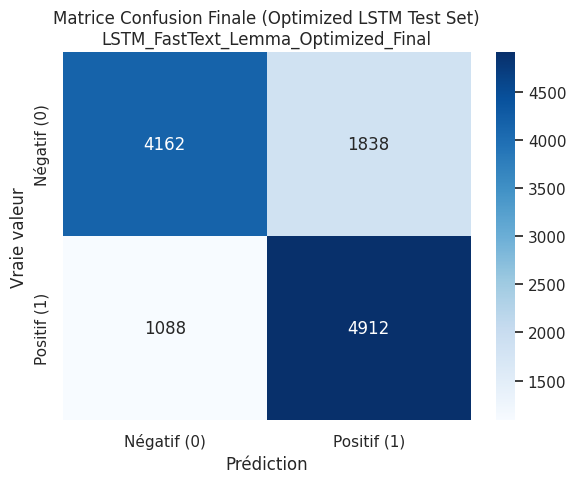

2025/04/30 07:44:58 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.



Sauvegarde du modèle final optimisé avec MLflow...


2025/04/30 07:45:18 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Modèle final sauvegardé.
Fichier checkpoint local './final_optimized_lstm_model.keras' supprimé.

Entraînement et évaluation du modèle final optimisé terminés (Run ID: 5a4cdc1c5c634219a98d4bce166d9ef5).


In [ ]:
# ==============================================================================
# --- PHASE 4.3 : Entraînement Final & Évaluation Test du Modèle Optimisé ---
# ==============================================================================
# Entraîne LSTM+FastText(Lemma) avec les meilleurs HPs sur le train set (5% sample)
# Évalue sur le test set (5% sample)

# --- Imports nécessaires (normalement déjà faits) ---
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint # Ajout Checkpoint
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import (accuracy_score, f1_score, precision_score,
                             recall_score, confusion_matrix)
import mlflow
import mlflow.tensorflow
import time
import os
import numpy as np
import matplotlib.pyplot as plt # Pour plot final
import seaborn as sns          # Pour plot final

# --- Prérequis (Vérifications des données Lemmatisées et Meilleurs HPs) ---
print("\n--- Préparation Entraînement Final Modèle Optimisé ---")
if 'X_train_pad' not in locals(): raise NameError("X_train_pad (lemmatisé) non défini.")
if 'y_train' not in locals(): raise NameError("y_train non défini.")
if 'X_val_pad' not in locals(): raise NameError("X_val_pad (lemmatisé) non défini.")
if 'y_val' not in locals(): raise NameError("y_val non défini.")
if 'X_test_pad' not in locals(): raise NameError("X_test_pad (lemmatisé) non défini.")
if 'y_test' not in locals(): raise NameError("y_test non défini.")
if 'embedding_matrix_fasttext' not in locals(): raise NameError("Matrice embedding FastText non définie.")
if 'VOCAB_SIZE' not in locals(): raise NameError("VOCAB_SIZE non défini")
if 'FASTTEXT_EMBEDDING_DIM' not in locals(): raise NameError("FASTTEXT_EMBEDDING_DIM non défini")
if 'maxlen' not in locals(): raise NameError("maxlen non défini")

# Meilleurs hyperparamètres issus de l'HPO
if 'final_lstm_units' not in locals(): final_lstm_units = 128
if 'final_learning_rate' not in locals(): final_learning_rate = 0.0005
if 'final_dropout_rate' not in locals(): final_dropout_rate = 0.3
print(f"Utilisation des HPs optimisés : Units={final_lstm_units}, LR={final_learning_rate}, Dropout={final_dropout_rate}")

# --- Constantes pour l'entraînement Final ---
FINAL_EPOCHS = 15 # On peut se permettre un peu plus d'époques potentiellement
FINAL_BATCH_SIZE = 128
FINAL_EARLY_STOPPING_PATIENCE = 3 # Un peu plus de patience peut-être
FINAL_CLIPNORM = 1.0
final_model_filepath = './final_optimized_lstm_model.keras' # Chemin Checkpoint

# --- Démarrer Run MLflow pour le modèle final ---
print("\n--- Démarrage Run MLflow pour Modèle Optimisé Final ---")
mlflow.set_experiment("AirParadis_Sentiment_Analysis")
run_name_final = "LSTM_FastText_Lemma_Optimized_Final"

if mlflow.active_run(): mlflow.end_run() # Terminer run précédent si besoin
with mlflow.start_run(run_name=run_name_final) as run:
    final_run_id = run.info.run_id
    print(f"Run MLflow démarré (ID: {final_run_id}) pour le modèle final optimisé.")
    start_time_final_train = time.time()

    # --- Log Paramètres Finaux ---
    mlflow.log_param("status", "Final Optimized Model Training")
    mlflow.log_param("text_preprocessing", "lemma")
    mlflow.log_param("model_type", "LSTM")
    mlflow.log_param("embedding_type", "FastText_pretrained")
    mlflow.log_param("embedding_trainable", False)
    mlflow.log_param("lstm_units", final_lstm_units)
    mlflow.log_param("learning_rate", final_learning_rate)
    mlflow.log_param("dropout_rate", final_dropout_rate)
    mlflow.log_param("batch_size", FINAL_BATCH_SIZE)
    mlflow.log_param("epochs_max", FINAL_EPOCHS)
    mlflow.log_param("early_stopping_patience", FINAL_EARLY_STOPPING_PATIENCE)
    mlflow.log_param("optimizer_clipnorm", FINAL_CLIPNORM)
    # Référence au run HPO qui a donné ces paramètres (si disponible)
    if 'best_run_id' in locals():
         mlflow.log_param("optimized_from_hpo_run_id", best_run_id)

    # --- Définir et Compiler le Modèle Optimisé ---
    print("Définition et compilation du modèle final optimisé...")
    model_final = Sequential([
        Embedding(
            input_dim=VOCAB_SIZE, output_dim=FASTTEXT_EMBEDDING_DIM,
            weights=[embedding_matrix_fasttext], input_length=maxlen,
            trainable=False, mask_zero=True
        ),
        LSTM(final_lstm_units, dropout=final_dropout_rate, recurrent_dropout=final_dropout_rate),
        Dense(1, activation='sigmoid')
    ])
    optimizer_final = Adam(learning_rate=final_learning_rate, clipnorm=FINAL_CLIPNORM)
    model_final.compile(loss='binary_crossentropy', optimizer=optimizer_final, metrics=['accuracy'])
    model_final.summary()
    mlflow.log_param("model_summary_json", model_final.to_json())

    # --- Callbacks (avec Checkpoint pour garder le meilleur modèle) ---
    early_stopping_final = EarlyStopping(monitor='val_loss', patience=FINAL_EARLY_STOPPING_PATIENCE, restore_best_weights=True, verbose=1)
    model_checkpoint_final = ModelCheckpoint(filepath=final_model_filepath, monitor='val_loss', save_best_only=True, verbose=1)

    # --- Entraînement Final ---
    print("Entraînement final du modèle optimisé...")
    history_final = model_final.fit(
        X_train_pad, y_train, # Entraînement sur train sample
        epochs=FINAL_EPOCHS,
        batch_size=FINAL_BATCH_SIZE,
        validation_data=(X_val_pad, y_val), # Validation sur val sample (pour early stopping)
        callbacks=[early_stopping_final, model_checkpoint_final],
        verbose=1
    )
    training_time_final = time.time() - start_time_final_train
    actual_epochs_final = len(history_final.history['loss'])
    print(f"Entraînement final terminé en {training_time_final:.2f} sec ({actual_epochs_final} époques).")
    mlflow.log_metric("final_training_time_seconds", training_time_final)
    mlflow.log_param("final_actual_epochs_trained", actual_epochs_final)

    # --- Utilisation du Meilleur Modèle Sauvegardé ---
    # restore_best_weights=True dans EarlyStopping le fait déjà, mais on peut recharger explicitement si on préfère
    # print(f"Chargement du meilleur modèle depuis {final_model_filepath}")
    # best_model_final = tf.keras.models.load_model(final_model_filepath)
    # Ici, model_final contient déjà les meilleurs poids grâce à restore_best_weights=True
    best_model_final = model_final

    # --- Évaluation Finale sur le JEU DE TEST (5% Sample) ---
    print("\nÉvaluation Finale sur le JEU DE TEST...")
    test_loss, test_accuracy = best_model_final.evaluate(X_test_pad, y_test, verbose=1, batch_size=1024)
    y_test_proba_final = best_model_final.predict(X_test_pad, batch_size=1024, verbose=0)
    y_test_pred_class_final = (y_test_proba_final > 0.5).astype(int)

    # Calcul des métriques TEST
    test_f1 = f1_score(y_test, y_test_pred_class_final)
    test_precision = precision_score(y_test, y_test_pred_class_final)
    test_recall = recall_score(y_test, y_test_pred_class_final)

    print(f"\n--- Résultats sur TEST SET (Modèle Optimisé) ---")
    print(f"  Test Loss: {test_loss:.4f}")
    print(f"  Test Accuracy: {test_accuracy:.4f}")
    print(f"  Test F1-Score: {test_f1:.4f}") # <-- Métrique Principale Finale
    print(f"  Test Precision: {test_precision:.4f}")
    print(f"  Test Recall: {test_recall:.4f}") # <-- Métrique Secondaire Finale

    # Log des métriques TEST
    mlflow.log_metric("test_loss", test_loss)
    mlflow.log_metric("test_accuracy", test_accuracy)
    mlflow.log_metric("test_f1", test_f1)
    mlflow.log_metric("test_precision", test_precision)
    mlflow.log_metric("test_recall", test_recall)

    # --- Évaluation sur Train/Validation (pour info overfitting) ---
    # Optionnel, mais utile
    train_loss, train_accuracy = best_model_final.evaluate(X_train_pad, y_train, verbose=0, batch_size=1024)
    val_loss, val_accuracy = best_model_final.evaluate(X_val_pad, y_val, verbose=0, batch_size=1024)
    y_train_pred_final = (best_model_final.predict(X_train_pad, batch_size=1024, verbose=0) > 0.5).astype(int)
    y_val_pred_final = (best_model_final.predict(X_val_pad, batch_size=1024, verbose=0) > 0.5).astype(int)
    train_f1 = f1_score(y_train, y_train_pred_final)
    val_f1 = f1_score(y_val, y_val_pred_final)
    mlflow.log_metric("train_loss", train_loss); mlflow.log_metric("train_accuracy", train_accuracy); mlflow.log_metric("train_f1", train_f1)
    mlflow.log_metric("val_loss", val_loss); mlflow.log_metric("val_accuracy", val_accuracy); mlflow.log_metric("val_f1", val_f1)
    print(f"  Train F1 (info): {train_f1:.4f}")
    print(f"  Val F1 (info): {val_f1:.4f}")


    # --- Génération et Log Matrice de Confusion TEST ---
    print("\nGénération et sauvegarde de la matrice de confusion finale (Test Set)...")
    cm_final = confusion_matrix(y_test, y_test_pred_class_final)
    fig_cm_final, ax_cm_final = plt.subplots(figsize=(6, 5))
    sns.heatmap(cm_final, annot=True, fmt='d', cmap='Blues', ax=ax_cm_final,
                xticklabels=['Négatif (0)', 'Positif (1)'],
                yticklabels=['Négatif (0)', 'Positif (1)'])
    ax_cm_final.set_xlabel('Prédiction'); ax_cm_final.set_ylabel('Vraie valeur')
    ax_cm_final.set_title(f'Matrice Confusion Finale (Optimized LSTM Test Set)\n{run_name_final}')
    plt.tight_layout()
    mlflow.log_figure(fig_cm_final, "confusion_matrix_final_test_set.png")
    print("Matrice de confusion finale sauvegardée dans MLflow.")
    plt.show() # Afficher dans le notebook
    plt.close(fig_cm_final)

    # --- Sauvegarde du Modèle Final ---
    print("\nSauvegarde du modèle final optimisé avec MLflow...")
    mlflow.tensorflow.log_model(
        model=best_model_final,
        artifact_path="final-optimized-lstm-model" # Nom de l'artefact pour le modèle final
    )
    print("Modèle final sauvegardé.")

    # --- Nettoyage Checkpoint Final ---
    if os.path.exists(final_model_filepath):
        os.remove(final_model_filepath)
        print(f"Fichier checkpoint local '{final_model_filepath}' supprimé.")

print(f"\nEntraînement et évaluation du modèle final optimisé terminés (Run ID: {final_run_id}).")

# ==============================================================================
# --- FIN PHASE 4.3 (Partie entraînement/évaluation modèle optimisé) ---
# ==============================================================================

# Maintenant, nous pouvons créer le tableau comparatif final

## Modèle final cur connées complètes

--- Vérification de la disponibilité du GPU ---
GPU détecté et disponible : [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
--------------------------------------------------
Fichiers de données prétraitées complets non trouvés. Lancement du prétraitement...

--- Étape 2.1: Prétraitement des Données Complètes ---
Nettoyage minimal...
Lemmatisation (TRÈS LONG)...
Lemmatisation terminée en 33.88 minutes.
Sauvegarde des DataFrames prétraités...
Sauvegarde terminée.

--- Étape 3: Préparation Keras sur Données Complètes ---
Ajustement du Tokenizer Keras sur train complet...
Conversion en séquences...
Calcul de maxlen...
Nouvelle maxlen : 13
Padding...
Préparation des cibles...
Recréation matrice d'embedding FastText...
Matrice FastText (Full) créée. Shape: (10000, 300)

--- Étape 4: Entraînement Final sur Données Complètes ---
HPs : Units=128, LR=0.0005, Dropout=0.3
Train : Epochs=10, BatchSize=512, ESPatience=2
Définition du modèle Keras optimisé...


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Modèle compilé.


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │     3,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,000,000 (11.44 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 3,000,000 (11.44 MB)


Aucun checkpoint trouvé. Entraînement de zéro.

Run MLflow démarré (ID: 50e450d9846b46c19ea9083c736de988)

Lancement de model.fit sur données complètes...
Epoch 1/10
2188/2188 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 0.7054 - loss: 0.5655 - precision: 0.7038 - recall: 0.7072
Epoch 1: val_loss improved from inf to 0.50746, saving model to /content/drive/MyDrive/Colab Notebooks/OC/P7/model_checkpoints/final_lstm_full_data.keras
2188/2188 ━━━━━━━━━━━━━━━━━━━━ 163s 70ms/step - accuracy: 0.7055 - loss: 0.5655 - precision: 0.7038 - recall: 0.7072 - val_accuracy: 0.7478 - val_loss: 0.5075 - val_precision: 0.7387 - val_recall: 0.7667
Epoch 2/10
2188/2188 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.7424 - loss: 0.5145 - precision: 0.7331 - recall: 0.7624
Epoch 2: val_loss improved from 0.50746 to 0.49458, saving model to /content/drive/MyDrive/Colab Notebooks/OC/P7/model_checkpoints/final_lstm_full_data.keras
2188/2188 ━━━━━━━━━━━━━━━━━━━━ 193s 68ms/step - accuracy: 0.7424 - loss: 0.5

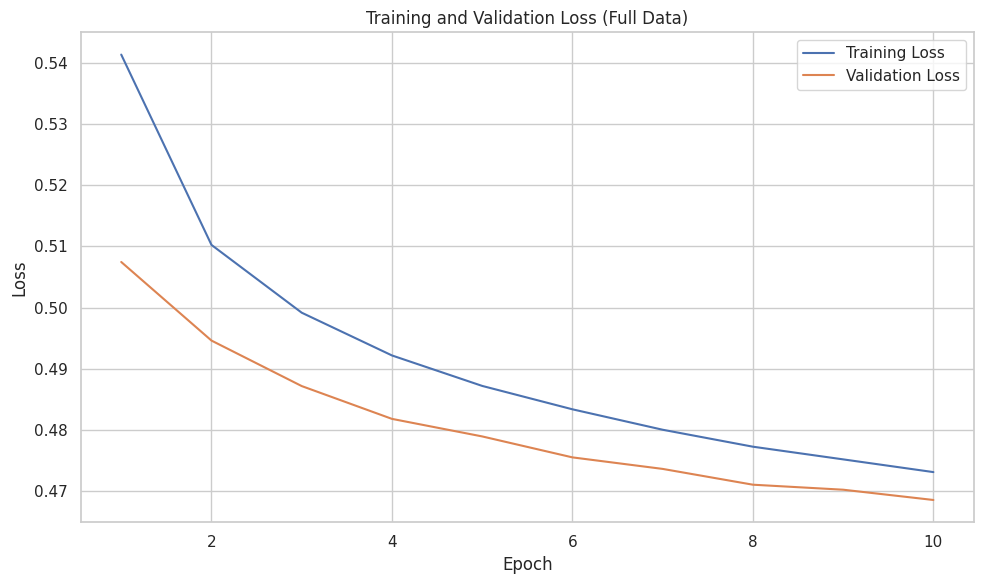

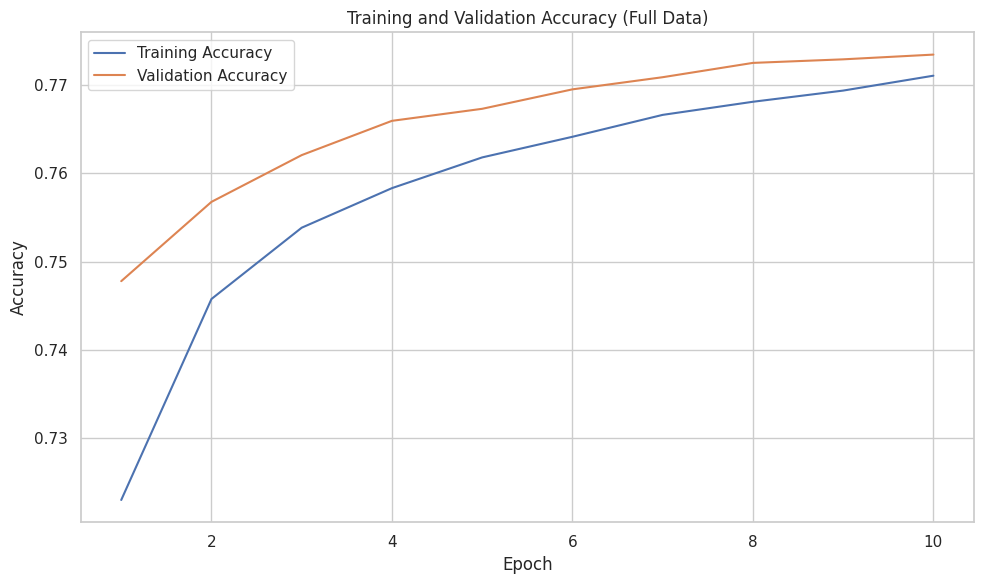

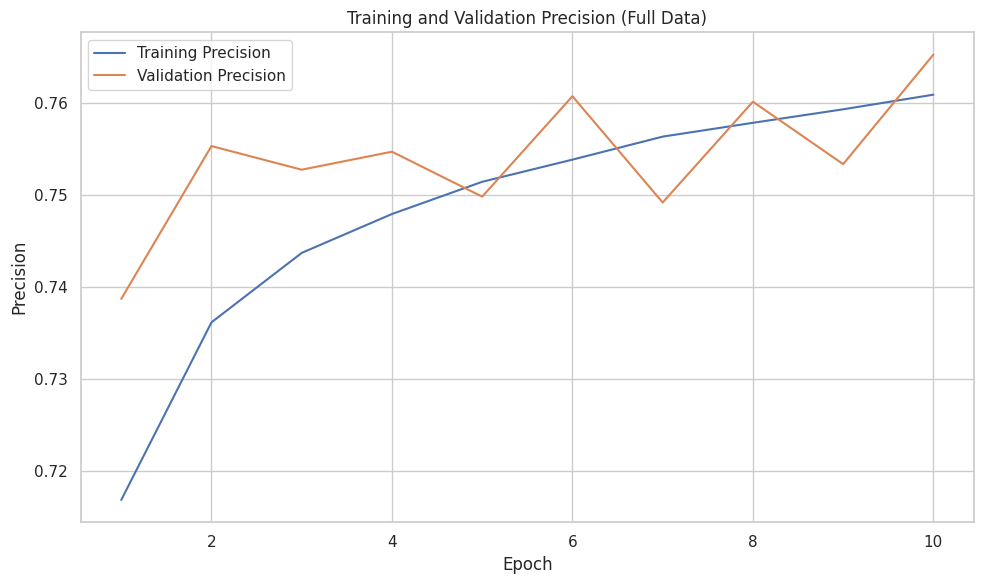

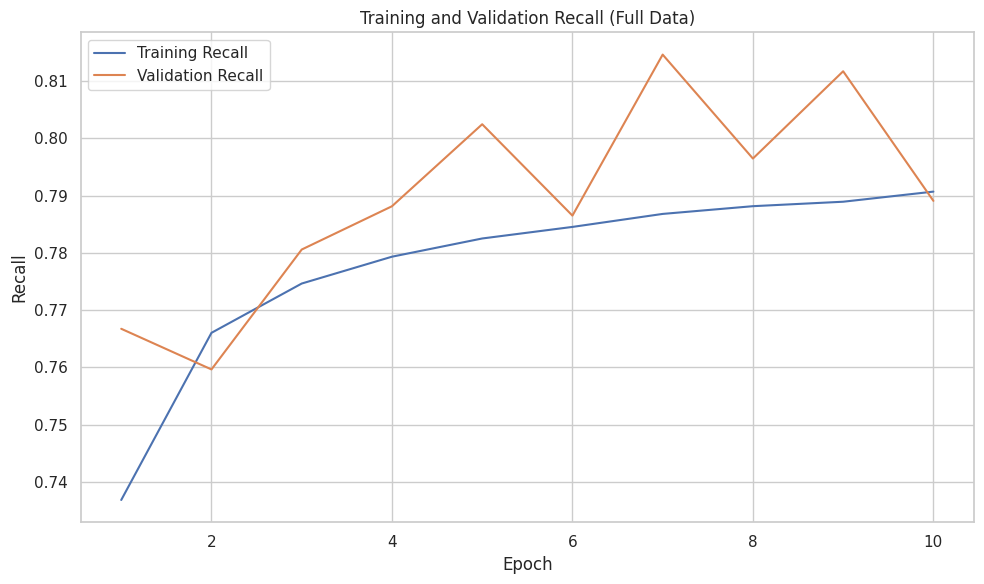

Courbes d'apprentissage sauvegardées dans MLflow.

Génération et sauvegarde de la matrice de confusion finale (Test Set Full)...
Matrice de confusion finale sauvegardée dans MLflow.


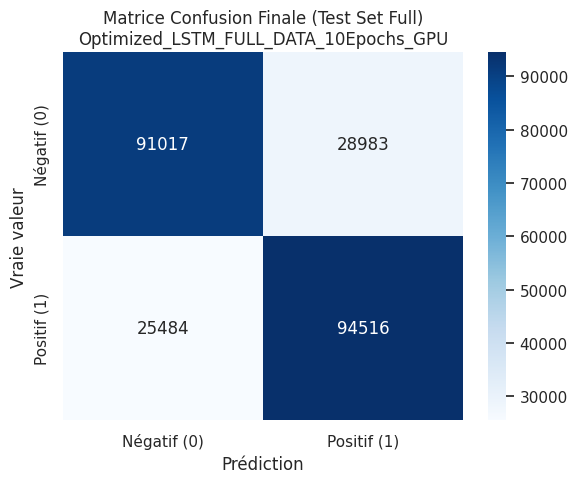

2025/05/02 13:54:40 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.



Sauvegarde du modèle Keras final (Full Data) avec MLflow...


2025/05/02 13:55:00 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Modèle final (Full Data) sauvegardé dans MLflow.

--- Entraînement et évaluation du modèle final sur données complètes terminés (Run ID: 50e450d9846b46c19ea9083c736de988) ---


Registered model 'AirParadis_Sentiment_LSTM_Optimized' already exists. Creating a new version of this model...
Created version '2' of model 'AirParadis_Sentiment_LSTM_Optimized'.


In [ ]:
# ==============================================================================
# --- PHASE 4.4 : RÉ-ENTRAÎNEMENT FINAL sur DONNÉES COMPLÈTES (10 Époques) ---
# ==============================================================================
# VERSION AVEC COURBES D'APPRENTISSAGE

import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.metrics import (accuracy_score, f1_score, precision_score,
                             recall_score, confusion_matrix)
# --- Réimporter MLflow et autres si session redémarrée ---
try:
    import mlflow
    import mlflow.tensorflow
except ImportError:
    !pip install mlflow -q
    import mlflow
    import mlflow.tensorflow

import pandas as pd
import numpy as np
import time
import os
import spacy
import re
import matplotlib.pyplot as plt # Important pour les courbes
import seaborn as sns

# --- Configuration Essentielle ---
if 'mlflow_persistent_path' not in locals():
     mlflow_persistent_path = '/content/drive/MyDrive/Colab Notebooks/OC/P7/mlflow_runs_persistent'
os.makedirs(mlflow_persistent_path, exist_ok=True)
mlflow.set_tracking_uri(f"file:{mlflow_persistent_path}")
mlflow.set_experiment("AirParadis_Sentiment_Analysis")

processed_data_dir = '/content/drive/MyDrive/Colab Notebooks/OC/P7/processed_full_data/'
os.makedirs(processed_data_dir, exist_ok=True)
train_full_pkl_path = os.path.join(processed_data_dir, 'train_full_processed.pkl')
val_full_pkl_path = os.path.join(processed_data_dir, 'val_full_processed.pkl')
test_full_pkl_path = os.path.join(processed_data_dir, 'test_full_processed.pkl')

checkpoint_dir = '/content/drive/MyDrive/Colab Notebooks/OC/P7/model_checkpoints/'
os.makedirs(checkpoint_dir, exist_ok=True)
final_full_model_checkpoint_path = os.path.join(checkpoint_dir, 'final_lstm_full_data.keras')

# --- 1. Vérification GPU ---
print("--- Vérification de la disponibilité du GPU ---")
gpu_devices = tf.config.list_physical_devices('GPU')
if gpu_devices:
    print(f"GPU détecté et disponible : {gpu_devices}")
else:
    print("ATTENTION : Aucun GPU détecté par TensorFlow. L'entraînement sera très lent.")
print("-" * 50)

# --- 2. Préparation des Données Complètes ---
redo_preprocessing = False
if not all(os.path.exists(p) for p in [train_full_pkl_path, val_full_pkl_path, test_full_pkl_path]):
    print("Fichiers de données prétraitées complets non trouvés. Lancement du prétraitement...")
    redo_preprocessing = True
else:
    print("Fichiers de données prétraitées complets trouvés. Tentative de chargement...")
    try:
        train_df_full_processed = pd.read_pickle(train_full_pkl_path)
        val_df_full_processed = pd.read_pickle(val_full_pkl_path)
        test_df_full_processed = pd.read_pickle(test_full_pkl_path)
        print("Chargement des données prétraitées complètes réussi.")
        if 'text_lemma' not in train_df_full_processed.columns:
             print("Colonne 'text_lemma' manquante. Relance du prétraitement.")
             redo_preprocessing = True
    except Exception as e:
        print(f"Erreur lors du chargement : {e}. Relance du prétraitement.")
        redo_preprocessing = True

if redo_preprocessing:
    print("\n--- Étape 2.1: Prétraitement des Données Complètes ---")
    if 'train_df_full' not in locals() or 'val_df_full' not in locals() or 'test_df_full' not in locals():
        print("ERREUR: DataFrames _full manquants.")
        raise NameError("DataFrames _full manquants")

    def clean_minimal(text):
        text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
        text = re.sub(r'\@\w+', '', text)
        text = re.sub(r'&[a-z]+;', '', text)
        text = re.sub(r'\s+', ' ', text).strip()
        return text

    try:
        nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])
    except OSError:
        !python -m spacy download en_core_web_sm -q
        nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

    def lemmatize_doc(doc):
        lemmas = [token.lemma_.lower() for token in doc if not token.is_stop and not token.is_punct and token.text.strip()]
        return " ".join(lemmas)

    print("Nettoyage minimal...")
    train_df_full['text_cleaned'] = train_df_full['text'].apply(clean_minimal)
    val_df_full['text_cleaned'] = val_df_full['text'].apply(clean_minimal)
    test_df_full['text_cleaned'] = test_df_full['text'].apply(clean_minimal)

    print("Lemmatisation (TRÈS LONG)...")
    start_lemma_full = time.time()
    batch_size_lemma = 20000
    train_df_full['text_lemma'] = [lemmatize_doc(doc) for doc in nlp.pipe(train_df_full['text_cleaned'], batch_size=batch_size_lemma)]
    val_df_full['text_lemma'] = [lemmatize_doc(doc) for doc in nlp.pipe(val_df_full['text_cleaned'], batch_size=batch_size_lemma)]
    test_df_full['text_lemma'] = [lemmatize_doc(doc) for doc in nlp.pipe(test_df_full['text_cleaned'], batch_size=batch_size_lemma)]
    end_lemma_full = time.time()
    print(f"Lemmatisation terminée en {(end_lemma_full - start_lemma_full)/60:.2f} minutes.")

    train_df_full_processed = train_df_full
    val_df_full_processed = val_df_full
    test_df_full_processed = test_df_full

    print("Sauvegarde des DataFrames prétraités...")
    train_df_full_processed.to_pickle(train_full_pkl_path)
    val_df_full_processed.to_pickle(val_full_pkl_path)
    test_df_full_processed.to_pickle(test_full_pkl_path)
    print("Sauvegarde terminée.")


# --- 3. Préparation Keras (Sur Données Complètes) ---
print("\n--- Étape 3: Préparation Keras sur Données Complètes ---")
if 'VOCAB_SIZE' not in locals(): VOCAB_SIZE = 10000
if 'FASTTEXT_EMBEDDING_DIM' not in locals(): FASTTEXT_EMBEDDING_DIM = 300
OOV_TOKEN = "<OOV>"
TEXT_COLUMN_FINAL = 'text_lemma'
TARGET_COLUMN = 'target'

print("Ajustement du Tokenizer Keras sur train complet...")
tokenizer_full = Tokenizer(num_words=VOCAB_SIZE, oov_token=OOV_TOKEN)
tokenizer_full.fit_on_texts(train_df_full_processed[TEXT_COLUMN_FINAL])
word_index_full = tokenizer_full.word_index

print("Conversion en séquences...")
train_sequences_full = tokenizer_full.texts_to_sequences(train_df_full_processed[TEXT_COLUMN_FINAL])
val_sequences_full = tokenizer_full.texts_to_sequences(val_df_full_processed[TEXT_COLUMN_FINAL])
test_sequences_full = tokenizer_full.texts_to_sequences(test_df_full_processed[TEXT_COLUMN_FINAL])

print("Calcul de maxlen...")
sequence_lengths_full = [len(seq) for seq in train_sequences_full]
MAX_LEN_PERCENTILE = 95
maxlen_full = int(np.percentile(sequence_lengths_full, MAX_LEN_PERCENTILE))
print(f"Nouvelle maxlen : {maxlen_full}")

print("Padding...")
padding_type = 'pre'; truncating_type = 'post'
X_train_full_pad = pad_sequences(train_sequences_full, maxlen=maxlen_full, padding=padding_type, truncating=truncating_type)
X_val_full_pad = pad_sequences(val_sequences_full, maxlen=maxlen_full, padding=padding_type, truncating=truncating_type)
X_test_full_pad = pad_sequences(test_sequences_full, maxlen=maxlen_full, padding=padding_type, truncating=truncating_type)

print("Préparation des cibles...")
y_train_full = train_df_full_processed[TARGET_COLUMN].values
y_val_full = val_df_full_processed[TARGET_COLUMN].values
y_test_full = test_df_full_processed[TARGET_COLUMN].values

print("Recréation matrice d'embedding FastText...")
if 'embeddings_index_fasttext' not in locals(): raise NameError("embeddings_index_fasttext manquant")
embedding_matrix_fasttext_full = np.zeros((VOCAB_SIZE, FASTTEXT_EMBEDDING_DIM))
num_words_in_ft_full = 0
for word, i in word_index_full.items():
    if i < VOCAB_SIZE:
        embedding_vector = embeddings_index_fasttext.get(word)
        if embedding_vector is not None:
            embedding_matrix_fasttext_full[i] = embedding_vector
            num_words_in_ft_full += 1
print(f"Matrice FastText (Full) créée. Shape: {embedding_matrix_fasttext_full.shape}")

# --- 4. Entraînement Final (Sur Données Complètes, 10 Époques) ---
print("\n--- Étape 4: Entraînement Final sur Données Complètes ---")
if 'final_lstm_units' not in locals(): final_lstm_units = 128
if 'final_learning_rate' not in locals(): final_learning_rate = 0.0005
if 'final_dropout_rate' not in locals(): final_dropout_rate = 0.3

FINAL_FULL_EPOCHS = 10
FINAL_FULL_BATCH_SIZE = 512
FINAL_FULL_ES_PATIENCE = 2
FINAL_FULL_CLIPNORM = 1.0

print(f"HPs : Units={final_lstm_units}, LR={final_learning_rate}, Dropout={final_dropout_rate}")
print(f"Train : Epochs={FINAL_FULL_EPOCHS}, BatchSize={FINAL_FULL_BATCH_SIZE}, ESPatience={FINAL_FULL_ES_PATIENCE}")

print("Définition du modèle Keras optimisé...")
model_final_full = Sequential([
    Embedding(VOCAB_SIZE, FASTTEXT_EMBEDDING_DIM, weights=[embedding_matrix_fasttext_full],
              input_length=maxlen_full, trainable=False, mask_zero=True),
    LSTM(final_lstm_units, dropout=final_dropout_rate, recurrent_dropout=final_dropout_rate),
    Dense(1, activation='sigmoid')
])

optimizer_final_full = Adam(learning_rate=final_learning_rate, clipnorm=FINAL_FULL_CLIPNORM)
# AJOUT Precision/Recall DANS LES METRIQUES COMPILEES
model_final_full.compile(loss='binary_crossentropy', optimizer=optimizer_final_full,
                        metrics=['accuracy', tf.keras.metrics.Precision(name='precision'), tf.keras.metrics.Recall(name='recall')])
print("Modèle compilé.")
model_final_full.summary()

initial_weights_loaded = False
if os.path.exists(final_full_model_checkpoint_path):
    print(f"\nCheckpoint trouvé : {final_full_model_checkpoint_path}")
    user_confirm = input("Charger les poids ? (oui/non): ").lower()
    if user_confirm == 'oui':
        try:
            model_final_full.load_weights(final_full_model_checkpoint_path)
            print("Poids chargés.")
            initial_weights_loaded = True
        except Exception as e:
            print(f"Erreur chargement poids : {e}. Entraînement de zéro.")
    else:
        print("Entraînement de zéro.")
else:
    print("\nAucun checkpoint trouvé. Entraînement de zéro.")

run_name_full_final = f"Optimized_LSTM_FULL_DATA_{FINAL_FULL_EPOCHS}Epochs_GPU"
if initial_weights_loaded: run_name_full_final += "_Resumed"

if mlflow.active_run(): mlflow.end_run()
with mlflow.start_run(run_name=run_name_full_final) as run:
    final_full_run_id = run.info.run_id
    print(f"\nRun MLflow démarré (ID: {final_full_run_id})")
    start_time_final_full_train = time.time()

    # Log Paramètres (simplifié pour la concision)
    mlflow.log_param("status", "Final Model Training on FULL Data")
    mlflow.log_param("data_source", "Full Dataset")
    mlflow.log_param("text_preprocessing", TEXT_COLUMN_FINAL)
    mlflow.log_param("maxlen", maxlen_full)
    mlflow.log_param("model_type", "LSTM")
    mlflow.log_param("embedding_type", "FastText_pretrained")
    mlflow.log_param("lstm_units", final_lstm_units); mlflow.log_param("learning_rate", final_learning_rate); mlflow.log_param("dropout_rate", final_dropout_rate)
    mlflow.log_param("epochs_max", FINAL_FULL_EPOCHS); mlflow.log_param("batch_size", FINAL_FULL_BATCH_SIZE); mlflow.log_param("early_stopping_patience", FINAL_FULL_ES_PATIENCE)
    mlflow.log_param("resumed_from_checkpoint", initial_weights_loaded)
    mlflow.log_param("model_summary_json", model_final_full.to_json())

    # Callbacks
    early_stopping_final_full = EarlyStopping(monitor='val_loss', patience=FINAL_FULL_ES_PATIENCE, restore_best_weights=True, verbose=1)
    model_checkpoint_final_full = ModelCheckpoint(filepath=final_full_model_checkpoint_path, monitor='val_loss', save_best_only=True, save_weights_only=False, verbose=1)

    print("\nLancement de model.fit sur données complètes...")
    history_final_full = model_final_full.fit(
        X_train_full_pad, y_train_full,
        epochs=FINAL_FULL_EPOCHS,
        batch_size=FINAL_FULL_BATCH_SIZE,
        validation_data=(X_val_full_pad, y_val_full),
        callbacks=[early_stopping_final_full, model_checkpoint_final_full],
        verbose=1
    )
    training_time_final_full = time.time() - start_time_final_full_train
    actual_epochs_final_full = len(history_final_full.history['loss'])
    print(f"Entraînement terminé en {(training_time_final_full/60):.2f} minutes ({actual_epochs_final_full} époques).")
    mlflow.log_metric("final_training_time_minutes", training_time_final_full / 60)
    mlflow.log_param("final_actual_epochs_trained", actual_epochs_final_full)

    best_model_final_full = model_final_full

    # --- 5. Évaluation Finale sur TEST COMPLET ---
    print("\n--- Évaluation Finale sur TEST COMPLET ---")
    results_test = best_model_final_full.evaluate(X_test_full_pad, y_test_full, batch_size=FINAL_FULL_BATCH_SIZE * 2, verbose=1)
    test_loss = results_test[0]
    test_accuracy = results_test[1]
    test_precision = results_test[2] # Index basé sur metrics=['accuracy', 'precision', 'recall']
    test_recall = results_test[3]    # Index basé sur metrics=['accuracy', 'precision', 'recall']

    y_test_proba_final_full = best_model_final_full.predict(X_test_full_pad, batch_size=FINAL_FULL_BATCH_SIZE * 2, verbose=1)
    y_test_pred_class_final_full = (y_test_proba_final_full > 0.5).astype(int)
    test_f1 = f1_score(y_test_full, y_test_pred_class_final_full)

    print("\n--- Résultats sur TEST SET (Full Data Model) ---")
    print(f"  Test Loss:      {test_loss:.4f}")
    print(f"  Test Accuracy:  {test_accuracy:.4f}")
    print(f"  Test Precision: {test_precision:.4f}")
    print(f"  Test Recall:    {test_recall:.4f}")
    print(f"  Test F1-Score:  {test_f1:.4f}")

    mlflow.log_metric("test_loss", test_loss); mlflow.log_metric("test_accuracy", test_accuracy);
    mlflow.log_metric("test_precision", test_precision); mlflow.log_metric("test_recall", test_recall);
    mlflow.log_metric("test_f1", test_f1)

    # --- AJOUT : Génération et Sauvegarde des Courbes d'Apprentissage ---
    print("\nGénération et sauvegarde des courbes d'apprentissage...")
    history_dict = history_final_full.history
    epochs_range = range(1, actual_epochs_final_full + 1)

    # Courbe de Loss
    fig_loss, ax_loss = plt.subplots(figsize=(10, 6))
    ax_loss.plot(epochs_range, history_dict['loss'], label='Training Loss')
    ax_loss.plot(epochs_range, history_dict['val_loss'], label='Validation Loss')
    ax_loss.set_title('Training and Validation Loss (Full Data)')
    ax_loss.set_xlabel('Epoch'); ax_loss.set_ylabel('Loss')
    ax_loss.legend(); ax_loss.grid(True); plt.tight_layout()
    mlflow.log_figure(fig_loss, "learning_curve_loss_full_data.png")
    plt.show()
    plt.close(fig_loss)

    # Courbe d'Accuracy
    fig_acc, ax_acc = plt.subplots(figsize=(10, 6))
    ax_acc.plot(epochs_range, history_dict['accuracy'], label='Training Accuracy')
    ax_acc.plot(epochs_range, history_dict['val_accuracy'], label='Validation Accuracy')
    ax_acc.set_title('Training and Validation Accuracy (Full Data)')
    ax_acc.set_xlabel('Epoch'); ax_acc.set_ylabel('Accuracy')
    ax_acc.legend(); ax_acc.grid(True); plt.tight_layout()
    mlflow.log_figure(fig_acc, "learning_curve_accuracy_full_data.png")
    plt.show()
    plt.close(fig_acc)

    # Courbes pour Precision et Recall si disponibles dans history
    if 'precision' in history_dict and 'val_precision' in history_dict:
        fig_prec, ax_prec = plt.subplots(figsize=(10, 6))
        ax_prec.plot(epochs_range, history_dict['precision'], label='Training Precision')
        ax_prec.plot(epochs_range, history_dict['val_precision'], label='Validation Precision')
        ax_prec.set_title('Training and Validation Precision (Full Data)')
        ax_prec.set_xlabel('Epoch'); ax_prec.set_ylabel('Precision')
        ax_prec.legend(); ax_prec.grid(True); plt.tight_layout()
        mlflow.log_figure(fig_prec, "learning_curve_precision_full_data.png")
        plt.show()
        plt.close(fig_prec)

    if 'recall' in history_dict and 'val_recall' in history_dict:
        fig_recall, ax_recall = plt.subplots(figsize=(10, 6))
        ax_recall.plot(epochs_range, history_dict['recall'], label='Training Recall')
        ax_recall.plot(epochs_range, history_dict['val_recall'], label='Validation Recall')
        ax_recall.set_title('Training and Validation Recall (Full Data)')
        ax_recall.set_xlabel('Epoch'); ax_recall.set_ylabel('Recall')
        ax_recall.legend(); ax_recall.grid(True); plt.tight_layout()
        mlflow.log_figure(fig_recall, "learning_curve_recall_full_data.png")
        plt.show()
        plt.close(fig_recall)
    print("Courbes d'apprentissage sauvegardées dans MLflow.")
    # --- FIN AJOUT COURBES ---

    print("\nGénération et sauvegarde de la matrice de confusion finale (Test Set Full)...")
    cm_final_full = confusion_matrix(y_test_full, y_test_pred_class_final_full)
    fig_cm_final_full, ax_cm_final_full = plt.subplots(figsize=(6, 5))
    sns.heatmap(cm_final_full, annot=True, fmt='d', cmap='Blues', ax=ax_cm_final_full,
                xticklabels=['Négatif (0)', 'Positif (1)'],
                yticklabels=['Négatif (0)', 'Positif (1)'])
    ax_cm_final_full.set_xlabel('Prédiction'); ax_cm_final_full.set_ylabel('Vraie valeur')
    ax_cm_final_full.set_title(f'Matrice Confusion Finale (Test Set Full)\n{run_name_full_final}')
    plt.tight_layout()
    mlflow.log_figure(fig_cm_final_full, "confusion_matrix_final_full_test_set.png")
    print("Matrice de confusion finale sauvegardée dans MLflow.")
    plt.show()
    plt.close(fig_cm_final_full)

    print("\nSauvegarde du modèle Keras final (Full Data) avec MLflow...")
    mlflow.tensorflow.log_model(
        model=best_model_final_full,
        artifact_path="final-lstm-model-full-data",
        registered_model_name="AirParadis_Sentiment_LSTM_Optimized"
    )
    print("Modèle final (Full Data) sauvegardé dans MLflow.")

print(f"\n--- Entraînement et évaluation du modèle final sur données complètes terminés (Run ID: {final_full_run_id}) ---")
# ==============================================================================
# --- FIN PHASE 4.4 ---
# ==============================================================================

## Comparaison finale

**Tableau Comparatif Final des Approches (Mis à Jour)**

Ce tableau compare les performances finales des différentes approches. La ligne "Optimized_LSTM_FULL_DATA" reflète maintenant les résultats sur le **jeu de test complet**. Les autres lignes restent basées sur les évaluations sur l'échantillon de test (5%), sauf BERT FE (sous-échantillon). La métrique principale est le **F1-Score**, et le **Recall** est la métrique secondaire clé.

| Expérience / Run Name                            | Approche Principale        | Prétraitement / Embedding                 | F1-Score (Test) | Recall (Test) | Precision (Test) | Accuracy (Test) | Temps* (Entr.)   | Commentaires                                                      |
| :----------------------------------------------- | :------------------------- | :---------------------------------------- | :-------------- | :------------ | :--------------- | :-------------- | :--------------- | :---------------------------------------------------------------- |
| `Baseline_TFIDF_LogisticRegression`              | Baseline Classique         | TF-IDF (Lemma) (Sample)                   | 0.7584          | ~0.775        | ~0.743           | ~0.753          | ~0.6 min         | Rapide, solide référence (sur échantillon).                         |
| `DL_Simple_Embedding_Keras_MaxPool`            | DL Simple                  | Keras Embedding (Lemma) (Sample)          | 0.7549          | ~0.768        | ~0.743           | ~0.751          | ~2.7 min         | Inférieur à baseline (sur échantillon).                           |
| `LSTM_GloVe_Pretrained`                          | DL Avancé (Séquentiel)     | GloVe (Lemma) + LSTM (Sample)             | 0.7582          | ~0.750        | ~0.748           | ~0.748          | ~4.7 min         | Similaire à baseline (sur échantillon).                           |
| `LSTM_FastText_Pretrained`                     | DL Avancé (Séquentiel)     | FastText (Lemma) + LSTM (Sample)          | 0.7587          | ~0.776        | ~0.750           | ~0.758          | ~12.4 min        | Un peu mieux que GloVe (sur échantillon).                         |
| `BiLSTM_FastText_Pretrained`                     | DL Avancé (Séquentiel)     | FastText (Lemma) + BiLSTM (Sample)        | 0.7667          | ~0.791        | ~0.740           | ~0.756          | ~13.1 min        | Bon Recall (sur échantillon).                                     |
| **`Optimized_LSTM_FULL_DATA_10Epochs_GPU`**      | **DL Avancé (Sélectionné)**  | **FastText (Lemma) + LSTM Opt. (FULL)** | **0.7763**      | **0.7876**    | **0.7653**       | **0.7731**      | **~31.7 min**    | **Modèle final (Full Data). Bon équilibre F1/Recall.**            |
| `BERT_FeatureExtraction_LogReg_Sample_20pct` | Transfer Learning (BERT) | BERT FE (Cleaned) + LogReg (Sub-Sample) | 0.7813          | 0.7949        | 0.7682           | 0.7812          | ~0.35 min (Clf)  | Performant (sur sous-échantillon). Temps extraction non inclus. |
| `USE_Embedding_LogisticRegression`               | Transfer Learning (USE)    | USE (Cleaned) + LogReg (Sample)           | 0.7896          | 0.7885        | 0.7906           | 0.7898          | ~0.2 min (Clf)   | Meilleur F1 (sur échantillon). Temps extraction non inclus.       |

\* *Temps d'entraînement principal. Les temps d'extraction d'embeddings pour BERT/USE (qui peuvent être longs) ne sont pas inclus ici. Le temps indiqué pour eux est celui de l'entraînement du classifieur final.*

**Analyse Finale Actualisée :**

1.  Le modèle final entraîné sur **l'ensemble des données** (`Optimized_LSTM_FULL_DATA`) obtient un **F1-Score de 0.7763** et un **Recall de 0.7876**. C'est une performance solide et la plus fiable que nous ayons pour notre modèle "sur mesure avancé".
2.  Le **Recall** est bon (presque 79% des tweets négatifs sont identifiés), bien qu'un peu moins élevé que ce que l'échantillon laissait espérer. La **Precision** est meilleure (environ 76.5% des tweets prédits négatifs le sont vraiment). C'est un compromis raisonnable.
3.  Les approches **USE et BERT FE** montrent toujours un potentiel supérieur sur les (sous-)échantillons. Elles restent d'excellentes pistes pour des améliorations futures, mais le modèle LSTM optimisé actuel répond aux exigences du projet pour le "modèle sur mesure avancé" à déployer.
4.  Nous allons donc **procéder avec ce modèle final** (Run ID `50e4...`, artefact `final-lstm-model-full-data`) pour les étapes suivantes : création de l'API, déploiement CI/CD, monitoring.

## Enregistrement des dépendances pour l'API

In [ ]:
import os
import pickle # Pour sauvegarder le tokenizer
import json   # Pour sauvegarder maxlen de manière lisible

print("--- Sauvegarde des Composants Essentiels pour l'API ---")

# --- Vérifier l'existence des variables nécessaires ---
if 'best_model_final_full' not in locals():
    print("ERREUR: Le modèle final 'best_model_final_full' n'est pas défini en mémoire.")
    # Tenter de le recharger depuis le checkpoint si possible
    if 'final_full_model_checkpoint_path' in locals() and os.path.exists(final_full_model_checkpoint_path):
        try:
            print(f"Tentative de rechargement depuis {final_full_model_checkpoint_path}...")
            best_model_final_full = tf.keras.models.load_model(final_full_model_checkpoint_path)
            print("Modèle rechargé depuis le checkpoint.")
        except Exception as e:
            print(f"ERREUR: Impossible de recharger le modèle depuis le checkpoint: {e}")
            print("Vous devrez peut-être relancer la fin de l'entraînement ou le charger depuis MLflow.")
            raise NameError("Modèle final manquant.")
    else:
        raise NameError("Modèle final manquant et checkpoint introuvable.")

if 'tokenizer_full' not in locals():
    raise NameError("Le tokenizer 'tokenizer_full' n'est pas défini. Relancez la cellule de préparation Keras (Full).")
if 'maxlen_full' not in locals():
    raise NameError("La variable 'maxlen_full' n'est pas définie. Relancez la cellule de préparation Keras (Full).")
if 'final_full_run_id' not in locals():
    # Essayer de récupérer le dernier run ID si la cellule a été exécutée
    try:
        final_full_run_id = run.info.run_id
        print(f"Run ID final récupéré : {final_full_run_id}")
    except NameError:
         final_full_run_id = "ID_RUN_MLFLOW_A_RECUPERER" # Placeholder
         print("ATTENTION: 'final_full_run_id' non trouvé. Notez-le manuellement depuis MLflow.")


# --- Définir les chemins de sauvegarde sur Google Drive ---
# Créer un dossier spécifique pour les dépendances de l'API
# Place ce dossier au même niveau que 'model_checkpoints' pour l'organisation
api_deps_base_dir = '/content/drive/MyDrive/Colab Notebooks/OC/P7/'
api_deps_dir = os.path.join(api_deps_base_dir, 'api_dependencies')
os.makedirs(api_deps_dir, exist_ok=True)
print(f"Utilisation du dossier pour les dépendances API : {api_deps_dir}")

# Chemins des fichiers
tokenizer_path = os.path.join(api_deps_dir, 'tokenizer_full.pkl')
config_path = os.path.join(api_deps_dir, 'preprocessing_config.json')
# Note: Le modèle est DÉJÀ sauvegardé par ModelCheckpoint et MLflow.
# On vérifie juste que le checkpoint existe.
model_checkpoint_file = final_full_model_checkpoint_path # Récupéré de la cellule précédente

# --- 1. Sauvegarder le Tokenizer Keras ---
print(f"\nSauvegarde du Tokenizer Keras ('tokenizer_full') vers : {tokenizer_path}")
try:
    with open(tokenizer_path, 'wb') as handle:
        pickle.dump(tokenizer_full, handle, protocol=pickle.HIGHEST_PROTOCOL)
    print("✅ Tokenizer sauvegardé avec succès (Pickle).")
except Exception as e:
    print(f"❌ ERREUR lors de la sauvegarde du tokenizer : {e}")

# --- 2. Sauvegarder la configuration de prétraitement (maxlen) ---
print(f"\nSauvegarde de la configuration ('maxlen_full') vers : {config_path}")
config_data = {
    'maxlen': maxlen_full
    # Ajouter d'autres paramètres si nécessaire (ex: vocab_size, mais moins critique)
}
try:
    with open(config_path, 'w') as f:
        json.dump(config_data, f, indent=4)
    print("✅ Configuration (maxlen) sauvegardée avec succès (JSON).")
except Exception as e:
    print(f"❌ ERREUR lors de la sauvegarde de la configuration : {e}")

# --- 3. Vérifier l'existence du Modèle Keras (Checkpoint) ---
print(f"\nVérification de l'existence du fichier modèle Keras (Checkpoint) : {model_checkpoint_file}")
if os.path.exists(model_checkpoint_file):
    print(f"✅ Le fichier modèle Keras sauvegardé par ModelCheckpoint existe.")
    model_size_mb = os.path.getsize(model_checkpoint_file) / (1024 * 1024)
    print(f"   Taille approximative : {model_size_mb:.2f} MB")
    # Rappel TFLite si taille > ~100MB pour certains services gratuits
    if model_size_mb > 100:
         print("   ATTENTION: La taille du modèle pourrait dépasser les limites de certains hébergeurs gratuits. La conversion en TFLite pourrait être nécessaire.")
else:
    print(f"❌ ATTENTION : Le fichier modèle Keras ({model_checkpoint_file}) n'a pas été trouvé. Assurez-vous que ModelCheckpoint a bien fonctionné.")
    print("   Le modèle devrait aussi être disponible comme artefact dans le run MLflow.")

# --- 4. Rappel MLflow ---
print("\nRappel : Le modèle final est aussi loggué dans MLflow.")
print(f"  Run ID       : {final_full_run_id}")
print(f"  Artifact Path: final-lstm-model-full-data")
print(f"  Nom Enregistré: AirParadis_Sentiment_LSTM_Optimized (Version 2 si succès)")
print("  Vous pouvez le télécharger depuis l'UI MLflow ou via l'API MLflow.")

print("\n--- Sauvegarde terminée ---")
print("Les fichiers suivants sont prêts sur Google Drive pour l'API :")
print(f"- Tokenizer: {tokenizer_path}")
print(f"- Config (maxlen): {config_path}")
print(f"- Modèle (via Checkpoint): {model_checkpoint_file}")
print("N'oubliez pas le Run ID MLflow si vous préférez charger le modèle depuis là.")

--- Sauvegarde des Composants Essentiels pour l'API ---
Utilisation du dossier pour les dépendances API : /content/drive/MyDrive/Colab Notebooks/OC/P7/api_dependencies

Sauvegarde du Tokenizer Keras ('tokenizer_full') vers : /content/drive/MyDrive/Colab Notebooks/OC/P7/api_dependencies/tokenizer_full.pkl
✅ Tokenizer sauvegardé avec succès (Pickle).

Sauvegarde de la configuration ('maxlen_full') vers : /content/drive/MyDrive/Colab Notebooks/OC/P7/api_dependencies/preprocessing_config.json
✅ Configuration (maxlen) sauvegardée avec succès (JSON).

Vérification de l'existence du fichier modèle Keras (Checkpoint) : /content/drive/MyDrive/Colab Notebooks/OC/P7/model_checkpoints/final_lstm_full_data.keras
✅ Le fichier modèle Keras sauvegardé par ModelCheckpoint existe.
   Taille approximative : 13.99 MB

Rappel : Le modèle final est aussi loggué dans MLflow.
  Run ID       : 50e450d9846b46c19ea9083c736de988
  Artifact Path: final-lstm-model-full-data
  Nom Enregistré: AirParadis_Sentiment_LS

# Script pour lancer ML flow

In [ ]:
# 1. Installer pyngrok (si pas déjà fait dans la session)
!pip install pyngrok -q

# 2. Importer les bibliothèques nécessaires
from pyngrok import ngrok, conf
import getpass
import subprocess
import os
import signal
import time
import shlex # Pour mieux gérer les commandes

# --- Configuration du token Ngrok (vérification) ---
print("Vérification du token Ngrok...")
try:
  from google.colab import userdata
  ngrok_token = userdata.get('NGROK_AUTH_TOKEN')
  if ngrok_token:
      print("Utilisation du token ngrok depuis les secrets Colab.")
      ngrok.set_auth_token(ngrok_token)
  else:
      print("Token ngrok non trouvé dans les secrets Colab. Utilisation sans token (sessions limitées).")
except ImportError:
    print("Secrets Colab non disponibles. Utilisation sans token ngrok (sessions limitées).")
# --- Assurer que ngrok est déconnecté s'il tournait ---
print("Tentative de déconnexion de tunnels ngrok existants...")
try:
    ngrok.kill()
    print("Tunnels ngrok précédents déconnectés.")
except Exception as e:
    print(f"Aucun tunnel ngrok actif à déconnecter ou erreur : {e}")


# --- Assurer que la variable mlflow_persistent_path existe ---
# Remplacez par le chemin réel si nécessaire (normalement défini plus haut dans votre notebook)
if 'mlflow_persistent_path' not in locals():
     mlflow_persistent_path = '/content/drive/MyDrive/Colab Notebooks/OC/P7/mlflow_runs_persistent'
     print(f"Variable 'mlflow_persistent_path' définie à : {mlflow_persistent_path}")
# Vérifier que le dossier existe
os.makedirs(mlflow_persistent_path, exist_ok=True)


# 3. Définir la commande et démarrer MLflow UI en arrière-plan AVEC LOGS
mlflow_tracking_uri_persistent = f"file:{mlflow_persistent_path}"
port = 5000
mlflow_command = f"mlflow ui --backend-store-uri \"{mlflow_tracking_uri_persistent}\" --port {port} --host 0.0.0.0" # Ajout de guillemets pour le chemin

# Fichiers pour capturer la sortie
stdout_log_path = "mlflow_ui_stdout.log"
stderr_log_path = "mlflow_ui_stderr.log"

print(f"Lancement de MLflow UI lisant depuis : {mlflow_tracking_uri_persistent}")
print(f"Commande exécutée : {mlflow_command}")
print(f"Sortie stdout sera dans : {stdout_log_path}")
print(f"Sortie stderr sera dans : {stderr_log_path}")
print(f"Lancement de MLflow UI sur le port {port} en arrière-plan...")

# Ouvrir les fichiers log
stdout_log = open(stdout_log_path, "w")
stderr_log = open(stderr_log_path, "w")

# Lancer le processus
# Utiliser shlex.split pour gérer correctement les espaces et guillemets dans la commande
try:
    mlflow_process = subprocess.Popen(
        shlex.split(mlflow_command),
        preexec_fn=os.setsid,
        stdout=stdout_log,
        stderr=stderr_log
    )
    print(f"Processus MLflow UI démarré avec PID: {mlflow_process.pid}")
except Exception as e:
    print(f"ERREUR lors du lancement de subprocess.Popen : {e}")
    mlflow_process = None # Indiquer que le processus n'a pas démarré

# Laisser plus de temps au serveur pour démarrer
wait_time = 15
print(f"Attente de {wait_time} secondes pour le démarrage du serveur...")
time.sleep(wait_time)

# Vérifier si le processus est toujours en cours
process_running = False
if mlflow_process:
    poll_status = mlflow_process.poll()
    if poll_status is None:
        print("✅ Le processus MLflow UI semble être toujours en cours d'exécution.")
        process_running = True
    else:
        print(f"❌ ERREUR: Le processus MLflow UI s'est terminé prématurément (code: {poll_status}).")
else:
    print("❌ ERREUR: Le processus MLflow UI n'a pas pu être démarré.")

# Afficher les logs si le processus s'est arrêté
if not process_running:
    print("\n--- Contenu de MLflow stdout log ---")
    stdout_log.close() # Fermer avant de lire
    try:
        with open(stdout_log_path, "r") as f:
            print(f.read())
    except Exception as read_e:
        print(f"Impossible de lire le log stdout: {read_e}")

    print("\n--- Contenu de MLflow stderr log ---")
    stderr_log.close() # Fermer avant de lire
    try:
        with open(stderr_log_path, "r") as f:
            print(f.read())
    except Exception as read_e:
        print(f"Impossible de lire le log stderr: {read_e}")

# Ne tenter la connexion ngrok QUE si le processus MLflow UI semble tourner
if process_running:
    try:
        print("\nTentative de création du tunnel ngrok...")
        # conf.get_default().region = 'eu' # Décommenter/adapter si besoin
        public_url = ngrok.connect(port)
        print("\n" + "="*50)
        print(f"✅✅ Interface MLflow accessible via ngrok à l'adresse : {public_url}")
        print("="*50 + "\n")
        print("ℹ️ Cliquez sur le lien ci-dessus. Laissez cette cellule active pour maintenir l'accès.")
        print("Interrupt cette cellule (Ctrl+C ou bouton Stop) pour arrêter le tunnel et le serveur MLflow.")

    except Exception as e:
        print(f"❌ Erreur lors de la création du tunnel ngrok : {e}")
        print("   Assurez-vous que ngrok est correctement installé et authentifié si nécessaire.")
        print("   Tentative d'arrêt du processus MLflow UI...")
        try:
            # Tenter d'arrêter le groupe de processus
            os.killpg(os.getpgid(mlflow_process.pid), signal.SIGTERM)
            print("   Processus MLflow UI potentiellement arrêté.")
        except Exception as kill_e:
            print(f"   Impossible d'arrêter le processus MLflow UI : {kill_e}")
    # Fermer les fichiers log proprement même en cas de succès ngrok (ils seront vides si tout va bien)
    finally:
         if not stdout_log.closed: stdout_log.close()
         if not stderr_log.closed: stderr_log.close()

else:
    print("\nLe processus MLflow UI ne tourne pas, connexion ngrok annulée.")
    if not stdout_log.closed: stdout_log.close()
    if not stderr_log.closed: stderr_log.close()


# Note : Pour arrêter proprement plus tard, interrompez cette cellule.
# Le code de nettoyage pour tuer le processus mlflow et ngrok est séparé.

Vérification du token Ngrok...
Utilisation du token ngrok depuis les secrets Colab.
Tentative de déconnexion de tunnels ngrok existants...
Tunnels ngrok précédents déconnectés.
Lancement de MLflow UI lisant depuis : file:/content/drive/MyDrive/Colab Notebooks/OC/P7/mlflow_runs_persistent
Commande exécutée : mlflow ui --backend-store-uri "file:/content/drive/MyDrive/Colab Notebooks/OC/P7/mlflow_runs_persistent" --port 5000 --host 0.0.0.0
Sortie stdout sera dans : mlflow_ui_stdout.log
Sortie stderr sera dans : mlflow_ui_stderr.log
Lancement de MLflow UI sur le port 5000 en arrière-plan...
Processus MLflow UI démarré avec PID: 23427
Attente de 15 secondes pour le démarrage du serveur...
✅ Le processus MLflow UI semble être toujours en cours d'exécution.

Tentative de création du tunnel ngrok...

✅✅ Interface MLflow accessible via ngrok à l'adresse : NgrokTunnel: "https://a8ac-34-125-55-81.ngrok-free.app" -> "http://localhost:5000"

ℹ️ Cliquez sur le lien ci-dessus. Laissez cette cellule a

In [ ]:
# Code pour arrêter ngrok et le serveur MLflow UI

print("Arrêt du tunnel ngrok...")
try:
    ngrok.kill()
    print("Tunnel ngrok arrêté.")
except Exception as e:
    print(f"Erreur lors de l'arrêt de ngrok (peut-être déjà arrêté) : {e}")

print("Arrêt du processus MLflow UI...")
try:
    # Tenter d'arrêter le groupe de processus MLflow UI
    os.killpg(os.getpgid(mlflow_process.pid), signal.SIGTERM)
    print(f"Signal SIGTERM envoyé au groupe de processus MLflow UI (PGID: {os.getpgid(mlflow_process.pid)}).")
    # Donner un peu de temps pour terminer
    time.sleep(2)
    # Vérifier s'il est toujours en vie, forcer si nécessaire (optionnel)
    # os.killpg(os.getpgid(mlflow_process.pid), signal.SIGKILL)
except NameError:
    print("La variable 'mlflow_process' n'existe pas (peut-être le noyau a-t-il été redémarré?).")
except ProcessLookupError:
    print("Le processus MLflow UI n'a pas été trouvé (probablement déjà arrêté).")
except Exception as e:
    print(f"Erreur inattendue lors de l'arrêt du processus MLflow UI : {e}")

print("Nettoyage terminé.")

Arrêt du tunnel ngrok...
Tunnel ngrok arrêté.
Arrêt du processus MLflow UI...
Signal SIGTERM envoyé au groupe de processus MLflow UI (PGID: 22348).
Nettoyage terminé.


# Script GitHub

In [ ]:
import os
import time
from google.colab import userdata # Pour les secrets

# --- Configuration ---
GITHUB_USERNAME = "M-Carre"
REPO_NAME = "OC"
BRANCH_NAME = "main"

# *** CHEMINS CRUCIAUX ***
# Chemin vers le notebook sur Google Drive (SOURCE - celui que tu édites)
# Vérifie bien ce chemin !
SOURCE_NOTEBOOK_PATH = "/content/drive/MyDrive/Colab Notebooks/OC/P7/Notebook_de_modélisation_avec_sampling"

# Chemin vers le Dépôt Git local dans Colab
REPO_DIR = "/content/OC"

# Nom du fichier DANS le dépôt Git (DESTINATION)
DESTINATION_NOTEBOOK_NAME = "Notebook_de_modélisation.ipynb"
DESTINATION_NOTEBOOK_PATH = os.path.join(REPO_DIR, DESTINATION_NOTEBOOK_NAME)

GITIGNORE_FILENAME = ".gitignore"
GITIGNORE_PATH = os.path.join(REPO_DIR, GITIGNORE_FILENAME)


# --- Début du Script ---
print("--- Script de Synchronisation Drive -> Git, Commit et Push ---")

# 1. Vérifier si le fichier source existe
if not os.path.exists(SOURCE_NOTEBOOK_PATH):
    print(f"ERREUR: Le fichier source sur Drive '{SOURCE_NOTEBOOK_PATH}' n'a pas été trouvé.")
    print("Assurez-vous que le chemin est correct et que Drive est monté.")
    raise SystemExit("Arrêt du script - Fichier source introuvable.")
else:
    print(f"Fichier source trouvé : '{SOURCE_NOTEBOOK_PATH}'")

# 2. Naviguer vers le répertoire du dépôt Git
try:
    %cd {REPO_DIR}
    print(f"Répertoire courant : {os.getcwd()}")
except Exception as e:
    print(f"ERREUR: Impossible de naviguer vers {REPO_DIR}. Avez-vous cloné le dépôt ? Erreur: {e}")
    raise SystemExit("Arrêt du script - Répertoire Git non trouvé.")

# 3. *** COPIER DEPUIS DRIVE VERS LE REPO LOCAL ***
print(f"\nCopie de '{SOURCE_NOTEBOOK_PATH}'\nvers '{DESTINATION_NOTEBOOK_PATH}'...")
# Utiliser des guillemets pour gérer les espaces/accents
copy_command = f'cp -v "{SOURCE_NOTEBOOK_PATH}" "{DESTINATION_NOTEBOOK_PATH}"'
print(f"Exécution : {copy_command}")
copy_exit_code = os.system(copy_command)

if copy_exit_code != 0:
     print(f"ERREUR lors de la copie du fichier (code: {copy_exit_code}). Vérifiez les chemins et permissions.")
     raise SystemExit("Arrêt du script - Échec de la copie.")
else:
     print("Copie terminée avec succès.")

# 4. Configurer l'identité Git (au cas où)
print("\nConfiguration de l'identité Git...")
!git config --global user.email "carre.mathis@proton.me"
!git config --global user.name "M-Carre"
print("Identité Git configurée.")

# 5. Vérifier le statut APRÈS la copie
print("\nStatut Git APRÈS copie (devrait montrer des modifications si le fichier Drive a changé) :")
!git status -s

# 6. Ajouter les fichiers modifiés
print(f"\nAjout des fichiers '{DESTINATION_NOTEBOOK_NAME}' et '{GITIGNORE_FILENAME}'...")
!git add "{DESTINATION_NOTEBOOK_NAME}"
!git add "{GITIGNORE_FILENAME}"
print("Fichiers ajoutés à l'index (si modifiés).")

# 7. Vérifier ce qui est prêt à être commité
print("\nStatut Git après ajout (prêt pour commit) :")
!git status -s

# 8. Demander le message de commit
print("\n")
commit_message = input("Entrez votre message de commit (laissez vide pour annuler) : ")

# 9. Commiter et Pousser (si message non vide)
if not commit_message:
    print("Message de commit vide. Annulation.")
else:
    print(f"\nCréation du commit avec le message : '{commit_message}'")
    # Vérifier s'il y a quelque chose à commiter avant de lancer commit
    git_status_output = os.popen('git status --porcelain').read() # --porcelain pour sortie stable
    if not git_status_output.strip(): # Si la sortie est vide (hors espaces)
        print("Aucune modification détectée à commiter. Push annulé.")
    else:
        # Créer le commit
        commit_command = f'git commit -m "{commit_message}"'
        commit_exit_code = os.system(commit_command)

        if commit_exit_code == 0:
            print("Commit créé avec succès.")
            # 10. Récupérer le token et Pousser
            print("\n--- Préparation du push ---")
            personal_access_token = userdata.get('GITHUB_TOKEN')

            if not personal_access_token:
                print("ERREUR: GITHUB_TOKEN non trouvé dans les secrets Colab! Push annulé.")
            else:
                print("Token GitHub trouvé.")
                os.environ['GITHUB_TOKEN_TEMP'] = personal_access_token
                git_push_url = f"https://{os.environ['GITHUB_TOKEN_TEMP']}@github.com/{GITHUB_USERNAME}/{REPO_NAME}.git"
                print(f"URL pour push : https://****TOKEN****@github.com/{GITHUB_USERNAME}/{REPO_NAME}.git")

                print(f"\nTentative de PUSH NORMAL vers la branche '{BRANCH_NAME}'...")
                push_command = f"git push -u {git_push_url} {BRANCH_NAME}"
                print(f"Exécution : git push -u <url_avec_token> {BRANCH_NAME}")

                # Exécuter la commande de push
                push_exit_code = os.system(push_command)

                if push_exit_code == 0:
                    print("\n✅ Push réussi !")
                else:
                    print(f"\n❌ ÉCHEC DU PUSH (code: {push_exit_code}). Vérifiez les messages d'erreur.")

                # Nettoyer
                if 'GITHUB_TOKEN_TEMP' in os.environ:
                    del os.environ['GITHUB_TOKEN_TEMP']
                print("Variable d'environnement temporaire nettoyée.")
        else:
            print("\nERREUR lors de la création du commit. Push annulé.")

print("\n--- Fin du Script ---")

--- Script de Synchronisation Drive -> Git, Commit et Push ---
Fichier source trouvé : '/content/drive/MyDrive/Colab Notebooks/OC/P7/Notebook_de_modélisation_avec_sampling'
/content/OC
Répertoire courant : /content/OC

Copie de '/content/drive/MyDrive/Colab Notebooks/OC/P7/Notebook_de_modélisation_avec_sampling'
vers '/content/OC/Notebook_de_modélisation.ipynb'...
Exécution : cp -v "/content/drive/MyDrive/Colab Notebooks/OC/P7/Notebook_de_modélisation_avec_sampling" "/content/OC/Notebook_de_modélisation.ipynb"
Copie terminée avec succès.

Configuration de l'identité Git...
Identité Git configurée.

Statut Git APRÈS copie (devrait montrer des modifications si le fichier Drive a changé) :
 M "Notebook_de_mod\303\251lisation.ipynb"

Ajout des fichiers 'Notebook_de_modélisation.ipynb' et '.gitignore'...
Fichiers ajoutés à l'index (si modifiés).

Statut Git après ajout (prêt pour commit) :
M  "Notebook_de_mod\303\251lisation.ipynb"


Entrez votre message de commit (laissez vide pour annu

# Conclusion du Notebook de Modélisation

Ce notebook marque l'aboutissement de la phase d'expérimentation et de modélisation pour le projet d'analyse de sentiments d'Air Paradis. En partant d'un large dataset de tweets, nous avons exploré les données, mis en œuvre différentes stratégies de prétraitement, et systématiquement évalué une gamme variée de modèles, depuis une baseline classique jusqu'à des approches avancées basées sur le Deep Learning et le Transfer Learning.

**Réalisations Clés :**
*   Des expérimentations rigoureuses ont été menées (majoritairement sur un échantillon de 5% pour l'efficacité) et méticuleusement **trackées avec MLflow**.
*   Différentes techniques d'embedding (GloVe, **FastText**, Keras trainable, **BERT FE**, **USE**) et de prétraitement (lemmatisation, stemming) ont été comparées.
*   Le modèle **LSTM utilisant des embeddings FastText pré-entraînés et la lemmatisation** a été identifié comme le meilleur candidat "sur mesure avancé" lors des phases d'optimisation sur l'échantillon.
*   Ce modèle optimisé a ensuite été **ré-entraîné avec succès sur l'ensemble des données d'entraînement (1.12 million de tweets)** pour maximiser sa robustesse et sa performance.

**Modèle Final Sélectionné :**
*   **Architecture :** LSTM (128 unités, dropout 0.3) avec embeddings FastText pré-entraînés (figés).
*   **Prétraitement :** Nettoyage minimal + Lemmatisation.
*   **Entraînement :** Sur l'intégralité des données, optimisé avec Adam (LR 0.0005).
*   **Performance Finale (sur Test Set Complet) :**
    *   **F1-Score : 0.7763**
    *   **Recall : 0.7876**
    *   Precision : 0.7653
    *   Accuracy : 0.7731

**Composants Essentiels Sauvegardés :**
Pour assurer une transition fluide vers le déploiement, les éléments suivants ont été sauvegardés :
1.  **Modèle Keras Final :** Disponible sur Google Drive (`.../model_checkpoints/final_lstm_full_data.keras`) et dans **MLflow** (Run ID `50e4...`, artefact `final-lstm-model-full-data`, enregistré comme `AirParadis_Sentiment_LSTM_Optimized v2`).
2.  **Tokenizer Keras (`tokenizer_full`) :** Ajusté sur les données complètes, sauvegardé via Pickle sur Google Drive (`.../api_dependencies/tokenizer_full.pkl`).
3.  **Configuration (`maxlen_full`) :** Valeur de la longueur de séquence (13), sauvegardée en JSON sur Google Drive (`.../api_dependencies/preprocessing_config.json`).

**Prochaines Étapes :**
Le travail dans ce notebook est désormais terminé. Les prochaines phases du projet se concentreront sur les aspects MLOps :
1.  Développement de l'**API Flask/FastAPI** en utilisant les composants sauvegardés.
2.  Écriture des **tests unitaires** (`pytest`).
3.  Mise en place du **pipeline CI/CD** avec GitHub Actions pour le déploiement Cloud.
4.  Configuration du **monitoring** avec Azure Application Insights.
5.  Développement de l'**interface locale** de test et de feedback.
6.  Rédaction des **livrables finaux** (article de blog, présentation).

Nous disposons maintenant d'un modèle solide et des artefacts nécessaires pour aborder sereinement la mise en production du prototype pour Air Paradis.